## Load Modules & Data

In [1]:
%load_ext autoreload
%autoreload 2

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats as st
import multiprocessing as mp
from sklearn.decomposition import PCA
from tqdm import tqdm

#Save
import json, h5py
import scipy.io as sio

#Plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

#Predictive Coding Github Repository
sys.path.append('/home/dwyrick/Git/openscope_predictive_coding/')
from openscope_predictive_coding.ophys.dataset.openscope_predictive_coding_dataset import OpenScopePredictiveCodingDataset
from openscope_predictive_coding.ophys.response_analysis.response_analysis import ResponseAnalysis

#User
import openscope_predictive_coding.ophys.decoding_analysis.decoding as dc
import openscope_predictive_coding.ophys.response_analysis.utilities as openscope_utils

#Params
mainseq_ids = [68, 78, 13, 26]
oddball_ids = [6, 17, 22, 51, 71, 89, 103, 110, 111, 112]

import warnings
warnings.filterwarnings("ignore")
from multiprocessing import Pool

blocknames = ['randomized_control_pre', 'oddball', 'transition_control','randomized_control_post']
blocklabels = ['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post']
areanames = ['VISp', 'VISpm','RSP']
mainseq_labels = ['A','B','C','D']

import warnings
warnings.filterwarnings("ignore")
color_names=['windows blue',
             'red',
             'amber',
             'faded green',
             'dusty purple',
             'orange',
             'steel blue',
             'pink',
             'greyish',
             'mint',
             'clay',
             'light cyan',
             'forest green',
             'pastel purple',
             'salmon',
             'dark brown',
             'lavender',
             'pale green',
             'dark red',
             'gold',
             'dark teal',
             'rust',
             'fuchsia',
             'pale orange',
             'cobalt blue',
             'mahogany',
             'cloudy blue',
             'dark pastel green',
             'dust',
             'electric lime',
             'fresh green',
             'light eggplant',
             'nasty green']
 
color_palette = sns.xkcd_palette(color_names)
cc = sns.xkcd_palette(color_names)

In [2]:
# data streams for each imaging session are saved as .h5 files in each folder's experiment in this directory
cache_dir = '/srv/data/AllenInst/opc_analysis'

# Read in experiment manifest
manifest_file = '/srv/data/AllenInst/opc_analysis/opc_production_manifest.xlsx'
manifest = pd.read_excel(manifest_file)

# limit to experiments that passed QC
manifest = manifest[manifest['experiment_state']=='passed']
areanames = np.unique(manifest['imaging_area'])

 #Get preferred stim data for each cell
data = sio.loadmat('/home/dwyrick/projects/predictive_coding/data/preferredStim.mat')
preferred_imageIDs = data['preferred_imageIDs'][0]
cellIDs = data['cellIDs'][0]

# Get cell metadata
cell_metadata_df = pd.read_csv('/home/dwyrick/projects/predictive_coding/data/cell_metadata.csv')
cell_metadata_df.drop(columns='Unnamed: 0',inplace=True)
cell_metadata_df.drop_duplicates(subset='cell_specimen_id',inplace=True)
cell_metadata_df.set_index('cell_specimen_id', drop=True, inplace=True)

pIDs = []
for cellID in cell_metadata_df.index.values:
    
    indy = np.where(cellIDs == cellID)[0][0]
    pID = preferred_imageIDs[indy]

    pIDs.append(pID)
    
cell_metadata_df['pref_stim'] = pIDs

os.chdir('/home/dwyrick/projects/predictive_coding')

In [4]:
# Concatenate data from all experiments to create pseudopopulation response arrays
# This cell takes a while to run, which is why I've split up the functions of getting the data and selecting the data we want to decode with
stimulus_blocks = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
pop_responses = {a: {b: {} for b in stimulus_blocks} for a in areanames}
t0 = time.perf_counter()


use_events=True; variable='summed_response'
processes = []
with Pool(10) as p: 
    for area in areanames:
        processes.append(p.apply_async(dc.get_responses_per_session,args=(manifest,area,use_events,variable)))

    for area, out in zip(areanames,processes):
        X, stimulus_df = out.get()
        pop_responses[area] = X 
                        
print('Elapsed Time: {}'.format(time.perf_counter()-t0))

Elapsed Time: 199.7100783889182


In [12]:
areas_bydepth = ['VISp_superficial','VISp_deep', 'VISpm_superficial','VISpm_deep', 'RSP_superficial','RSP_deep']
area_labels = ['V1','PM','RSP']
areanames = ['VISp','VISpm','RSP']

## Ensemble Similiarity (overlap) analysis

### ABCDX Overlap in sequence stimulus context

In [50]:
ms_labels = ['A','B','C','D']
overlap_ABCDX_dict = {}
overlap_ABCDX_sess_dict = {a: {} for a in areas_bydepth}
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(pop_responses[area]['oddball'].keys())

        overlap_list = []
        for eID in experiment_ids:

            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            if nNeurons < 20:
                continue

            responses_ABCDX_oddball = []
            tickmarks = []; counter = 0
            main_boundaries = [0]
            boundaries = [0]; label_list = []
            
            X_oddball, Y_oddball, Y_sort = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCDX')
            for ii,imgID in enumerate(mainseq_ids):
                indy = np.where(Y_sort == imgID)[0]
                responses_ABCDX_oddball.append(np.array(X_oddball[indy]))
                tickmarks.append(counter + len(indy)/2); 
                counter += len(indy); boundaries.append(counter); label_list.append(ms_labels[ii])
            boundaries.append(counter)
            main_boundaries.append(counter) 
            
            for ii,imgID in enumerate(oddball_ids):
                indy = np.where(Y_sort == imgID)[0]
                responses_ABCDX_oddball.append(np.array(X_oddball[indy]))
                counter += len(indy)
                if ii == 4:
                    tickmarks.append(counter);label_list.append('Xs')
            boundaries.append(counter) 
            main_boundaries.append(counter) 
            
            X_oddball, Y_oddball, Y_sort = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df,seq_dist=0, block='oddball', trial_type='XABCD')
            for ii,imgID in enumerate(mainseq_ids):
                indy = np.where(Y_sort == imgID)[0]
                responses_ABCDX_oddball.append(np.array(X_oddball[indy]))
                tickmarks.append(counter + len(indy)/2); 
                counter += len(indy); boundaries.append(counter); label_list.append(ms_labels[ii])
            boundaries.append(counter) 
            main_boundaries.append(counter) 
            
            X = np.concatenate((responses_ABCDX_oddball))
            X_z = st.zscore(X,axis=1)
            overlap = np.corrcoef(X_z)
            overlap_list.append(overlap)
            overlap_ABCDX_sess_dict[locstr][eID] = overlap
        overlap_ABCDX_dict[locstr] = np.mean(overlap_list,axis=0)
            


In [51]:
pdfdoc = PdfPages('./plots/paper/ABCDX_overlap_persession.pdf')

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_ABCDX_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_ABCDX_sess_dict[locstr][eID]
            fig, ax = plt.subplots(figsize=(10,10))
            ax.set_title('{}, {}\n   "ABCD"   "---X"   "ABCD"'.format(locstr,eID))
            sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

            ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
            ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

            ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

            ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
            ax.set_yticklabels(label_list);ax.set_xticklabels(label_list,rotation=0)
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()


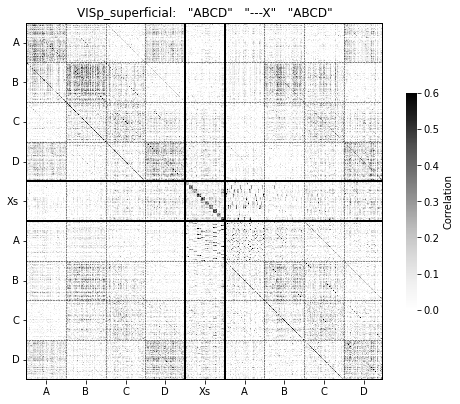

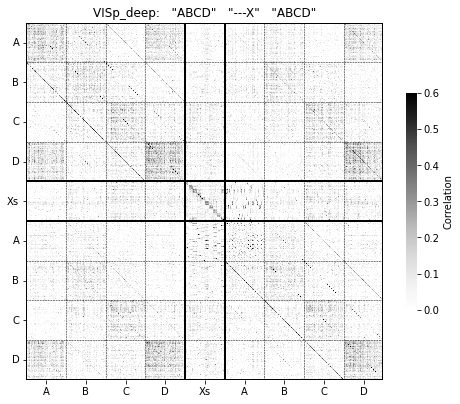

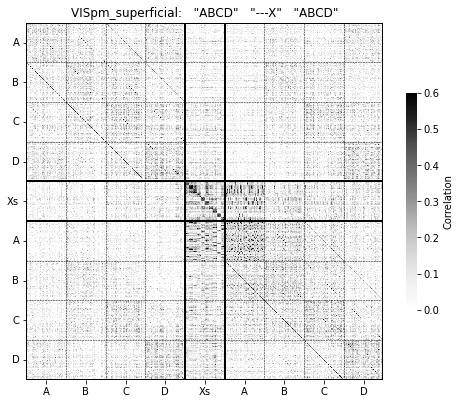

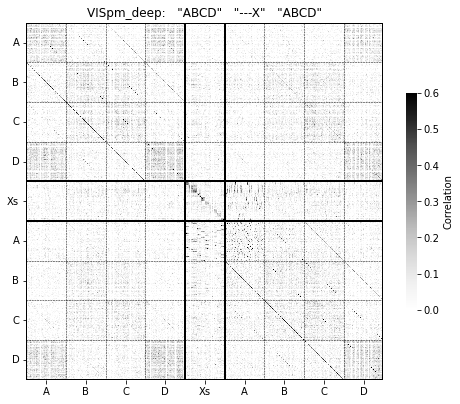

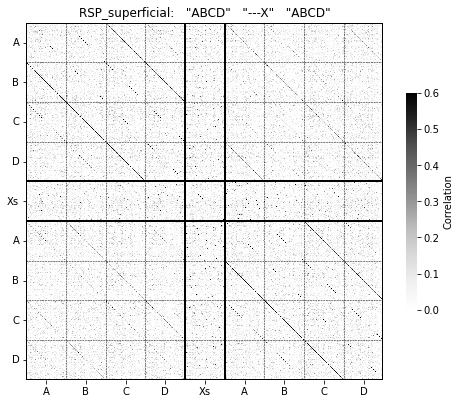

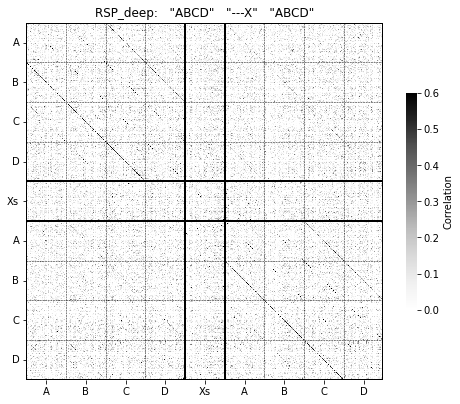

In [64]:

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)


        overlap = overlap_ABCDX_dict[locstr]

        tmp = overlap.copy()
        tmp[np.diag_indices(tmp.shape[0])] = np.nan
        vm = np.nanmax(tmp)
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title('{}:   "ABCD"   "---X"   "ABCD"'.format(locstr))
        sns.heatmap(overlap,cmap='Greys',ax=ax,square=True,vmax=0.6,vmin=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

        ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
        ax.set_yticklabels(label_list);ax.set_xticklabels(label_list,rotation=0)
        
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/paper2/ABCDX_overlap_{}_sessionavg.pdf'.format(locstr))
#         plt.show()
#         pdb.set_trace()
        

### Stimulus Context Overlap

In [9]:
Save = True
SaveDir  = './results/overlap'
if Save:
    fpath = os.path.join(SaveDir,'StimulusContext_ABCDXABCD.mat')
    h5file = h5py.File(fpath,'w')

overlap_sess_dict = {a: {} for a in areas_bydepth}
overlap_dict = {}
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(pop_responses[area]['oddball'].keys())

        overlap_list = []; overlap_oddball_list = []
        for eID in experiment_ids:

            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue

            response_list = []
            tickmarks = []; counter = 0; xtickmarks=[]
            boundaries = [0];main_boundaries = [0];
            label_list=[]; xlabel_list = []


            for jj,context in enumerate(blocknames):

                if context == 'oddball':
                    slindy = slice(3140,3260)
                else:
                    slindy = slice(None)
                    
                X, Y, Y_sort = dc.match_trials(pop_responses[area][context][eID].loc[:,cell_ids_perdepth], stimulus_df, block=context, trial_type='ABCD',trial_indy=slindy)
                
                for ii,imgID in enumerate(mainseq_ids):
                    indy = np.where(Y == imgID)[0]
                    response_list.append(np.array(X[indy]))
                    counter += len(indy)
                    tickmarks.append(counter); label_list.append(mainseq_labels[ii])
                boundaries.append(counter)
    
                xtickmarks.append(counter-20); xlabel_list.append(context)
                X, Y, Y_sort = dc.match_trials(pop_responses[area][context][eID].loc[:,cell_ids_perdepth], stimulus_df, block=context, trial_type='X')
                
                for ii,imgID in enumerate(oddball_ids):
                    indy = np.where(Y == imgID)[0]
                    if context != 'oddball':
                        indy = np.random.choice(indy,10,replace=False)
#                     pdb.set_trace()
                    response_list.append(np.array(X[indy]))
                    counter += len(indy)
#                     tickmarks.append(counter); label_list.append(mainseq_labels[ii])
                    if ii == 4:
                        tickmarks.append(counter);label_list.append('Xs')
                        
                main_boundaries.append(counter);boundaries.append(counter)


            X = np.concatenate((response_list))
#             pdb.set_trace()
            X_z = st.zscore(X,axis=1)
            overlap = np.corrcoef(X_z)
            overlap_list.append(overlap)
            overlap_sess_dict[locstr][eID] = overlap

        #Save
        if Save:
            h5file.create_dataset('{}_overlap'.format(locstr),data=overlap_list)
            h5file.create_dataset('{}_IDs'.format(locstr),data=experiment_ids)

        overlap_dict[locstr] = np.nanmean(overlap_list,axis=0)
        print(locstr)
        
if Save:
    h5file.create_dataset('main_boundaries',data=main_boundaries)
    h5file.create_dataset('boundaries',data=boundaries)
    h5file.create_dataset('tickmarks',data=tickmarks)
    h5file.create_dataset('xtickmarks',data=xtickmarks)
    print(label_list)
    h5file.close()
        


VISp_superficial
VISp_deep
VISpm_superficial
VISpm_deep
RSP_superficial
RSP_deep
['A', 'B', 'C', 'D', 'Xs', 'A', 'B', 'C', 'D', 'Xs', 'A', 'B', 'C', 'D', 'Xs', 'A', 'B', 'C', 'D', 'Xs']


In [82]:
pdfdoc = PdfPages('./plots/paper2/stimulus-context_overlap_persession.pdf')

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_sess_dict[locstr][eID]
            fig, ax = plt.subplots(figsize=(10,10))
            ax.set_title('{} {}\n Representational similarity'.format(locstr,eID),fontsize=16)
            sns.heatmap(overlap,cmap='Greys',ax=ax,square=True,vmin=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)
            
            ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
            ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

            ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.set_yticks(tickmarks);ax.set_yticklabels(label_list)
            ax.set_xticks(xtickmarks)
            
            labels = ax.set_xticklabels(blocklabels,rotation=0,fontsize=14)
            for i, label in enumerate(labels):
                label.set_y(label.get_position()[1] - (i % 2) * 0.05)
            ax.set_xlabel('Stimulus Context',fontsize=14)
            ax.set_ylabel('Reordered trials',fontsize=14)
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()


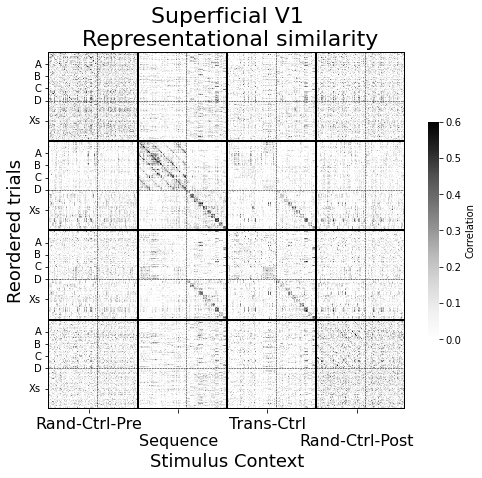

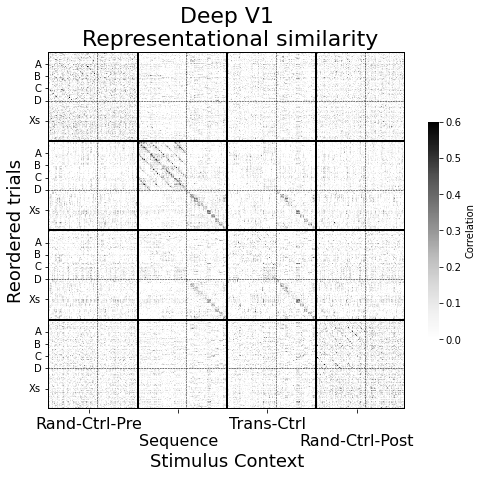

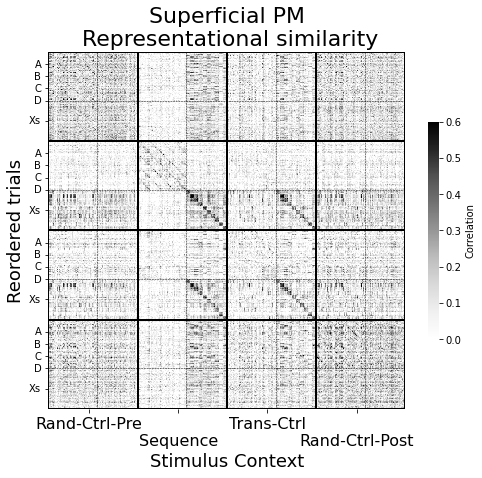

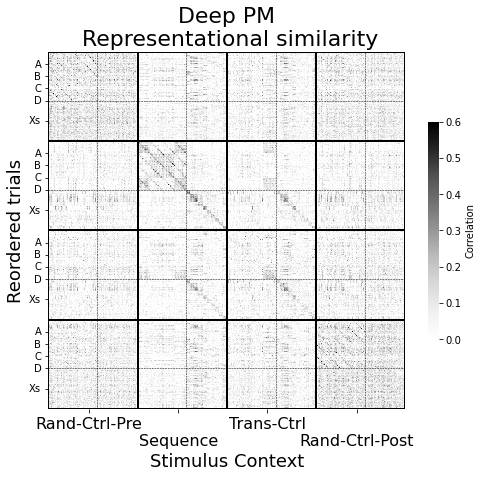

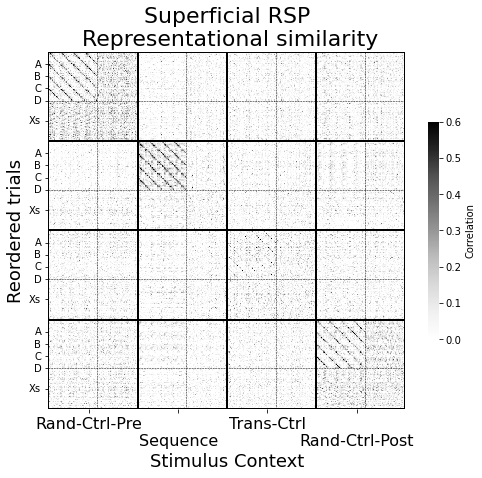

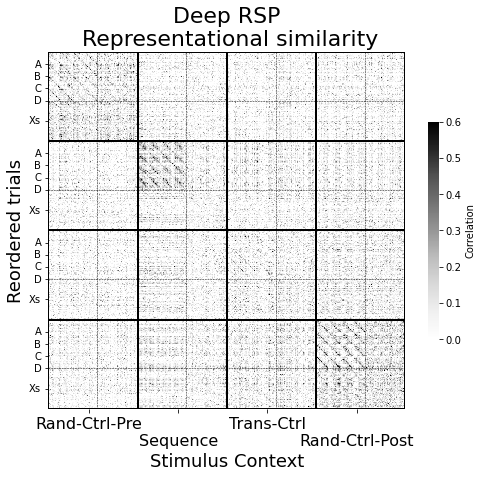

In [66]:
for ii, area in enumerate(['VISp','VISpm','RSP']):
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
# locstr = 'VISp_superficial'

        overlap = overlap_dict[locstr]
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title('{} {}\n Representational similarity'.format(depthstr.capitalize(),area_labels[ii]),fontsize=22)
        tmp = overlap.copy()
        tmp[np.diag_indices(tmp.shape[0])] = np.nan
        vm = np.nanmax(tmp)
        sns.heatmap(overlap,cmap='Greys',ax=ax,square=True,vmin=0,vmax=0.6,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)
        
        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.set_yticks(tickmarks);ax.set_yticklabels(label_list)
        ax.set_xticks(xtickmarks)
        
        labels = ax.set_xticklabels(blocklabels,rotation=0,fontsize=16)
        for i, label in enumerate(labels):
            label.set_y(label.get_position()[1] - (i % 2) * 0.05)
        ax.set_xlabel('Stimulus Context',fontsize=18)
        ax.set_ylabel('Reordered trials',fontsize=18)
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/paper2/overlap_across-blocks_grey_{}_sessionavg.pdf'.format(locstr), facecolor='white', transparent=True, bbox_inches='tight')
        
    


In [ ]:

overlap_sess_dict = {a: {} for a in areas_bydepth}
overlap_dict = {}
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(pop_responses[area]['oddball'].keys())

        overlap_list = []; overlap_oddball_list = []
        for eID in experiment_ids:

            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue

            response_list = []
            tickmarks = []; counter = 0; xtickmarks=[]
            boundaries = [0];main_boundaries = [0];
            label_list=[]


            for jj,context in enumerate(blocknames):
                ##=====
                if context == 'oddball':
                    slindy = slice(3000,3120)
                else:
                    slindy = slice(None)
                X, Y, Y_sort = dc.match_trials(pop_responses[area][context][eID].loc[:,cell_ids_perdepth], stimulus_df, block=context, trial_type='ABCD',trial_indy = slindy)

                for ii,imgID in enumerate(mainseq_ids):
                    indy = np.where(Y == imgID)[0]
                    response_list.append(np.array(X[indy]))
                    tickmarks.append(counter + len(indy)/2); counter += len(indy);label_list.append(ms_labels[ii])
                    if ii == 1:
                        xtickmarks.append(counter);xlabel_list.append(blocklabels[jj])
                main_boundaries.append(counter); boundaries.append(counter) 


            X = np.concatenate((response_list))
#             pdb.set_trace()
            X_z = st.zscore(X,axis=1)
            overlap = np.corrcoef(X_z)
            overlap_list.append(overlap)
            overlap_sess_dict[locstr][eID] = overlap
        overlap_dict[locstr] = np.mean(overlap_list,axis=0)
        print(locstr)


        


In [ ]:

overlap_all_sess_dict = {a: {} for a in areas_bydepth}
overlap_all_dict = {}
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(pop_responses[area]['oddball'].keys())

        overlap_list = []; overlap_oddball_list = []
        for eID in experiment_ids:

            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue

            response_list = []
            tickmarks = []; counter = 0; xtickmarks=[]
            boundaries = [0];main_boundaries = [0];
            label_list=[]


            for jj,context in enumerate(blocknames):

                if (context == 'oddball') | (context == blocknames[2]):
                    continue
                X, Y, Y_sort = dc.match_trials(pop_responses[area][context][eID].loc[:,cell_ids_perdepth], stimulus_df, block=context, trial_type='all')
                response_list.append(X)
                counter+=X.shape[0]
                main_boundaries.append(counter); boundaries.append(counter) 


            X = np.concatenate((response_list))
#             pdb.set_trace()
            X_z = st.zscore(X,axis=1)
            overlap = np.corrcoef(X_z)
            overlap_list.append(overlap)
            overlap_all_sess_dict[locstr][eID] = overlap
        overlap_all_dict[locstr] = np.mean(overlap_list,axis=0)
        print(locstr)


        


In [ ]:
for ii, area in enumerate(['VISp','VISpm','RSP']):
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
# locstr = 'VISp_superficial'

        overlap = overlap_all_dict[locstr]
        fig, ax = plt.subplots(figsize=(8,8))
        # ax.set_title('{} {}\n Representational similarity'.format(depthstr.capitalize(),area_labels[ii]),fontsize=22)
        tmp = overlap.copy()
        tmp[np.diag_indices(tmp.shape[0])] = np.nan
        vm = np.nanmax(tmp)
        sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,vmin=0,vmax=vm,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)
        
        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)


In [ ]:
pdfdoc = PdfPages('./plots/cosyne2/overlap-across-rand-ctrl-contexts_persession.pdf')

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_all_sess_dict[locstr][eID]
            fig, ax = plt.subplots(figsize=(10,10))
            ax.set_title('{}, {}\n  Ensemble Similarity Analysis'.format(locstr,eID))
            sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

            ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
            ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

            ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

            ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
            ax.set_yticklabels(label_list);ax.set_xticklabels(label_list,rotation=0)
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()


In [ ]:
xticks = [240,650,1090.0,1510.0]
for ii, area in enumerate(['VISp','VISpm','RSP']):
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
# locstr = 'VISp_superficial'

        overlap = overlap_dict[locstr]

        tmp = overlap.copy()
        tmp[np.diag_indices(tmp.shape[0])] = np.nan
        vm = np.nanmax(tmp)
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title('{} {}\n Representational similarity'.format(depthstr.capitalize(),area_labels[ii]),fontsize=22)
        sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,vmin=0,vmax=0.6,cbar_kws={'shrink':0.5,'label': 'Correlation','ticks':[0,0.3,0.6]},rasterized=True)

        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

        ax.set_yticks(tickmarks);ax.set_yticklabels(label_list)
        ax.set_xticks(xtickmarks)
        
        labels = ax.set_xticklabels(xlabel_list,rotation=0,fontsize=16)
        for i, label in enumerate(labels):
            label.set_y(label.get_position()[1] - (i % 2) * 0.05)
        ax.set_xlabel('Stimulus Context',fontsize=18)
        ax.set_ylabel('Reordered trials',fontsize=18)
        
        #;ax.set_xticks(xticks)
#         ax.set_yticklabels(['ABCD', 'Oddballs', 'ABCD_0', 'ABCD_1', 'ABCD_2', 'Oddballs', 'ABCD', 'Oddballs', 'ABCD', 'Oddballs'])#;ax.set_xticklabels(blocklabels,rotation=0)
#         labels = ax.set_xticklabels(blocklabels,rotation=0,fontsize=18)
#         for i, label in enumerate(labels):
#             label.set_y(label.get_position()[1] - (i % 2) * 0.05)
#         ax.set_xlabel('Stimulus Context',fontweight='bold',fontsize=22)
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/paper/overlap_across-blocks_{}_sessionavg.pdf'.format(locstr), facecolor='white', transparent=True, bbox_inches='tight')
#         plt.show()
#         pdb.set_trace()
        

In [ ]:
xtickmarks

In [ ]:
pdfdoc = PdfPages('./plots/cosyne2/overlap-across-contexts_persession.pdf')

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_sess_dict[locstr][eID]
            fig, ax = plt.subplots(figsize=(10,10))
            ax.set_title('{}, {}\n  Ensemble Similarity Analysis'.format(locstr,eID))
            sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

            ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
            ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

            ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

            ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
            ax.set_yticklabels(label_list);ax.set_xticklabels(label_list,rotation=0)
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()


In [ ]:
xticks = [240,650,1090.0,1510.0]
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
# locstr = 'VISp_superficial'

        overlap = overlap_dict[locstr]

        tmp = overlap.copy()
        tmp[np.diag_indices(tmp.shape[0])] = np.nan
        vm = np.nanmax(tmp)
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title('{}\n Ensemble Similarity Analysis'.format(locstr),fontsize=22)
        sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,vmin=0,vmax=0.6,cbar_kws={'shrink':0.5,'label': 'Correlation','ticks':[0,0.3,0.6]},rasterized=True)

        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

        ax.set_yticks(tickmarks);ax.set_xticks(xticks)
        ax.set_yticklabels(['ABCD', 'Oddballs', 'ABCD_0', 'ABCD_1', 'ABCD_2', 'Oddballs', 'ABCD', 'Oddballs', 'ABCD', 'Oddballs'])#;ax.set_xticklabels(blocklabels,rotation=0)
        labels = ax.set_xticklabels(blocklabels,rotation=0,fontsize=18)
        for i, label in enumerate(labels):
            label.set_y(label.get_position()[1] - (i % 2) * 0.05)
        ax.set_xlabel('Stimulus Context',fontweight='bold',fontsize=22)
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/cosyne2/overlap_across-blocks_{}_sessionavg.pdf'.format(locstr), facecolor='white', transparent=True, bbox_inches='tight')
#         plt.show()
#         pdb.set_trace()
        

['VISp_superficial',
 'VISp_deep',
 'VISpm_superficial',
 'VISpm_deep',
 'RSP_superficial',
 'RSP_deep']

In [129]:

overlap_seq_sess_dict = {a: {} for a in areas_bydepth}
overlap_seq_dict = {}
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(pop_responses[area]['oddball'].keys())

        overlap_list = []; overlap_oddball_list = []
        for eID in experiment_ids:

            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)


            if nNeurons < 20:
                continue

            tickmarks = []; counter = 0
            boundaries = [0];main_boundaries = [0];
            label_list=[]; responses_sequence = []
            
            nEpochs = 3
            for iEpoch in range(nEpochs):
#                 slindy = slice(iEpoch*1000+120,iEpoch*1000+240)
                slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
                X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy = slindy)
                for ii,imgID in enumerate(mainseq_ids):
                    indy = np.where(Y == imgID)[0]
                    responses_sequence.append(np.array(X[indy]))
                    tickmarks.append(counter+len(indy)/2);label_list.append(mainseq_labels[ii])
                    counter += len(indy)
                main_boundaries.append(counter); boundaries.append(counter) 

#             X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
#             for ii,imgID in enumerate(oddball_ids):
#                 indy = np.where(Y == imgID)[0]
#                 responses_sequence.append(np.array(X[indy]))
#                 counter += len(indy)
#                 if ii == 4:
#                     tickmarks.append(counter);label_list.append('Xs')
#             main_boundaries.append(counter); boundaries.append(counter) 
            
            X = np.concatenate((responses_sequence))

            X_z = st.zscore(X,axis=1)
            overlap = np.corrcoef(X_z)
            overlap_list.append(overlap)
            overlap_seq_sess_dict[locstr][eID] = overlap

        overlap_seq_dict[locstr] = np.nanmean(overlap_list,axis=0)
        print(locstr)


        


VISp_superficial
VISp_deep
VISpm_superficial
VISpm_deep
RSP_superficial
RSP_deep


In [155]:
pdfdoc = PdfPages('./plots/paper/overlap-across-sequence_persession.pdf')

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_seq_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_seq_sess_dict[locstr][eID]
            fig, ax = plt.subplots(figsize=(10,10))
            ax.set_title('{}, {}\n  Ensemble Similarity Analysis'.format(locstr,eID))
            sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

            ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
            ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

            ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

            ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
            ax.set_yticklabels(label_list);ax.set_xticklabels(label_list,rotation=0)
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()


In [156]:
print('oiy')

oiy


In [133]:
SaveDir = './results/overlap'



fpath = os.path.join(SaveDir,'sequence_representational_drift.mat')
with h5py.File(fpath,'w') as h5file:
    
    for area in ['VISp','VISpm','RSP']:
        for depthstr in ['superficial','deep']:
            locstr = '{}_{}'.format(area,depthstr)
            overlap_mean = overlap_seq_dict[locstr]
            
            h5file.create_dataset(f'overlap_{locstr}',data=overlap_mean)
            experiment_ids = list(overlap_seq_sess_dict[locstr].keys())
            h5file.create_dataset(f'experiment_ids_{locstr}',data=experiment_ids)
            for eID in experiment_ids:
                overlap = overlap_seq_sess_dict[locstr][eID] 
                h5file.create_dataset(f'overlap_{locstr}_{int(eID)}',data=overlap)
                
    h5file.create_dataset('tickmarks',data=tickmarks)
    h5file.create_dataset('main_boundaries',data=main_boundaries)
    h5file.create_dataset('boundaries',data=boundaries)
label_list

['A', 'B', 'C', 'D', 'A', 'B', 'C', 'D', 'A', 'B', 'C', 'D']

In [122]:

overlap_seq_sess_dict = {a: {} for a in areas_bydepth}
overlap_seq_dict = {}
# for area in ['VISp','VISpm','RSP']:
#     for depthstr in ['superficial','deep']:
area = 'VISp'; depthstr = 'superficial'
locstr = '{}_{}'.format(area,depthstr)
experiment_ids = list(pop_responses[area]['oddball'].keys())

overlap_list = []; overlap_oddball_list = []; PV_corr_list = []
for eID in experiment_ids:

    cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
    cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
    cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    nNeurons = len(cell_ids_perdepth)

    
    if nNeurons < 20:
        continue
    
    tickmarks = []; counter = 0
    boundaries = [0];main_boundaries = [0];
    label_list=[]; responses_sequence = []; 
    X_list = []; Y_list = []

    nEpochs = 11
    for iEpoch in range(nEpochs):
        slindy = slice(iEpoch*600+120,iEpoch*600+240)
        # slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
        X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy = slindy)
        X_list.append(X); Y_list.append(Y)
        for ii,imgID in enumerate(mainseq_ids):
            indy = np.where(Y == imgID)[0]
            responses_sequence.append(np.array(X[indy]))
            tickmarks.append(counter+len(indy)/2);label_list.append(mainseq_labels[ii])
            counter += len(indy)
        main_boundaries.append(counter); boundaries.append(counter) 

    # X2 = np.concatenate((X_list))
    X = np.concatenate((responses_sequence))
    # X_z = st.zscore(X,axis=1)
    overlap = np.corrcoef(X)
    # overlap2 = np.corrcoef(X2)
    overlap_list.append(overlap)
    overlap_seq_sess_dict[locstr][eID] = overlap
    
    
    X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

    N = 1600
    PVcorr = np.zeros((4,N-1,2))
    for ii,imgID in enumerate(mainseq_ids):
        indy = np.where(Y == imgID)[0]
        if ii == 0:
            overlap = np.corrcoef(np.array(X[indy]))
        elif ii == 1:
            overlap = np.corrcoef(np.array(X[indy]))
        elif ii == 2:
            overlap = np.corrcoef(np.array(X[indy]))
        else:
            overlap = np.corrcoef(np.array(X[indy]))

        for j in range(1,N):
            tmp = np.diagonal(overlap,j)
            PVcorr[ii,j-1,0] = np.mean(tmp)
            PVcorr[ii,j-1,1] = np.std(tmp)
    PV_corr_list.append(PVcorr)
overlap_seq_dict[locstr] = np.nanmean(overlap_list,axis=0)
print(locstr)


        


VISp_superficial


In [121]:
X.shape

(6400, 239)

In [100]:
A_list = []; B_list = [];
C_list = []; D_list = [];

X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')
X_list.append(X); Y_list.append(Y)
for ii,imgID in enumerate(mainseq_ids):
    indy = np.where(Y == imgID)[0]
    if ii == 0:
        A_list.append(np.array(X[indy]))
    elif ii == 1:
        B_list.append(np.array(X[indy]))
    elif ii == 2:
        C_list.append(np.array(X[indy]))
    else:
        D_list.append(np.array(X[indy]))

<AxesSubplot:>

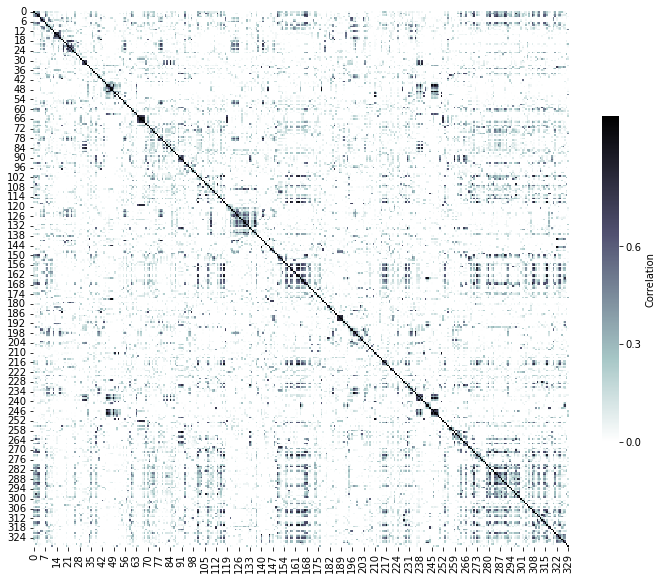

In [111]:
As = np.concatenate((A_list))

overlap = np.corrcoef(As)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(overlap,cmap='bone_r',square=True,ax=ax,vmin=0,vmax=1,cbar_kws={'shrink':0.5,'label': 'Correlation','ticks':[0,0.3,0.6]},rasterized=True)

In [114]:
PVcorr = np.zeros((4,N-1,2))
for ii,imgID in enumerate(mainseq_ids):
    if ii == 0:
        As = np.concatenate((A_list))
        overlap = np.corrcoef(As)
    elif ii == 1:
        Bs = np.concatenate((B_list))
        overlap = np.corrcoef(Bs)
    elif ii == 2:
        Cs = np.concatenate((C_list))
        overlap = np.corrcoef(Cs)
    else:
        Ds = np.concatenate((D_list))
        overlap = np.corrcoef(Ds)
        
    N = overlap.shape[0]


    for j in range(1,N):
        tmp = np.diagonal(overlap,j)
        PVcorr[ii,j-1,0] = np.mean(tmp)
        PVcorr[ii,j-1,1] = np.std(tmp)

In [106]:
N = overlap.shape[0]

PVcorr = np.zeros((N-1,2))
for i in range(1,N):
    tmp = np.diagonal(overlap,i)
    PVcorr[i-1,0] = np.mean(tmp)
    PVcorr[i-1,1] = np.std(tmp)

In [127]:
PVcorr_4d = np.array(PV_corr_list)

PVcorr_mean = np.nanmean(PVcorr_4d,axis=0)

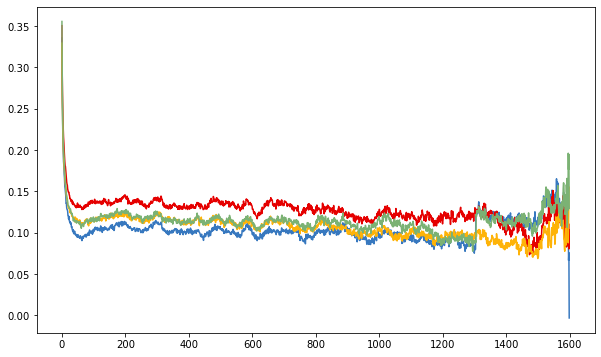

In [128]:
fig, ax = plt.subplots(figsize=(10,6))
for ii,imgID in enumerate(mainseq_ids):
    ax.plot(np.arange(N-1),PVcorr_mean[ii,:,0],color=cc[ii])
# for PVcorr in PV_corr_list:


#     for ii,imgID in enumerate(mainseq_ids):
#         ax.plot(np.arange(N-1),PVcorr_mean[ii,:,0],color=cc[ii],alpha=0.25)

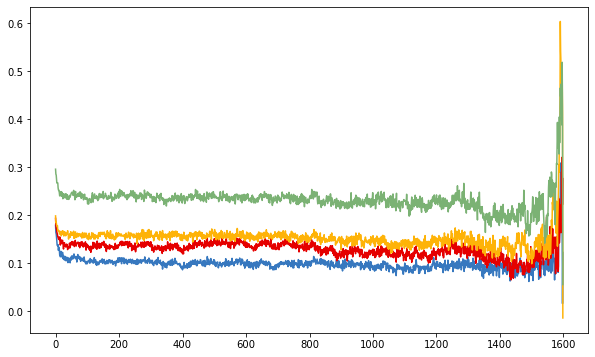

In [109]:
fig, ax = plt.subplots(figsize=(10,6))
for ii,imgID in enumerate(mainseq_ids):
    ax.plot(np.arange(N-1),PVcorr[ii,:,0],color=cc[ii])

In [84]:
##unroll matrimain_boundariesx 
overlap.shape




(1320, 1320)

[Text(15.0, 0, 'A'),
 Text(45.0, 0, 'B'),
 Text(75.0, 0, 'C'),
 Text(105.0, 0, 'D'),
 Text(135.0, 0, 'A'),
 Text(165.0, 0, 'B'),
 Text(195.0, 0, 'C'),
 Text(225.0, 0, 'D'),
 Text(255.0, 0, 'A'),
 Text(285.0, 0, 'B'),
 Text(315.0, 0, 'C'),
 Text(345.0, 0, 'D'),
 Text(375.0, 0, 'A'),
 Text(405.0, 0, 'B'),
 Text(435.0, 0, 'C'),
 Text(465.0, 0, 'D'),
 Text(495.0, 0, 'A'),
 Text(525.0, 0, 'B'),
 Text(555.0, 0, 'C'),
 Text(585.0, 0, 'D'),
 Text(615.0, 0, 'A'),
 Text(645.0, 0, 'B'),
 Text(675.0, 0, 'C'),
 Text(705.0, 0, 'D'),
 Text(735.0, 0, 'A'),
 Text(765.0, 0, 'B'),
 Text(795.0, 0, 'C'),
 Text(825.0, 0, 'D'),
 Text(855.0, 0, 'A'),
 Text(885.0, 0, 'B'),
 Text(915.0, 0, 'C'),
 Text(945.0, 0, 'D'),
 Text(975.0, 0, 'A'),
 Text(1005.0, 0, 'B'),
 Text(1035.0, 0, 'C'),
 Text(1065.0, 0, 'D'),
 Text(1095.0, 0, 'A'),
 Text(1125.0, 0, 'B'),
 Text(1155.0, 0, 'C'),
 Text(1185.0, 0, 'D'),
 Text(1215.0, 0, 'A'),
 Text(1245.0, 0, 'B'),
 Text(1275.0, 0, 'C'),
 Text(1305.0, 0, 'D')]

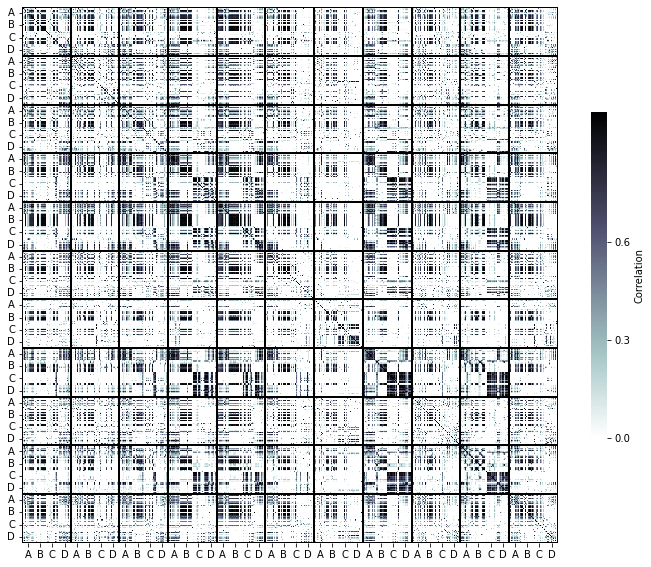

In [85]:
# X_z = st.zscore(X2,axis=1)
# overlap = np.corrcoef(X)
# overlap2 = np.corrcoef(X_z)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(overlap,cmap='bone_r',square=True,ax=ax,vmin=0,vmax=1,cbar_kws={'shrink':0.5,'label': 'Correlation','ticks':[0,0.3,0.6]},rasterized=True)

ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
ax.set_yticklabels(label_list,rotation=0)#;
ax.set_xticklabels(label_list,rotation=0)#;

In [69]:
nEpochs = 11
for iEpoch in range(nEpochs):
    slindy = slice(iEpoch*600+120,iEpoch*600+240)


slice(120, 240, None)
slice(720, 840, None)
slice(1320, 1440, None)
slice(1920, 2040, None)
slice(2520, 2640, None)
slice(3120, 3240, None)
slice(3720, 3840, None)
slice(4320, 4440, None)
slice(4920, 5040, None)
slice(5520, 5640, None)
slice(6120, 6240, None)


In [45]:
X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')

In [46]:
X.shape

(6400, 239)

In [ ]:
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_seq_sess_dict[locstr][eID]

In [ ]:
# tickmarks = []; counter = 0
# boundaries = [0];main_boundaries = [0];
# label_list=[]; responses_sequence = []

# nEpochs = 7
# for iEpoch in range(nEpochs):
#     slindy = slice(iEpoch*1000+120,iEpoch*1000+240)
#     X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy = slindy)
#     for ii,imgID in enumerate(mainseq_ids):
#         indy = np.where(Y == imgID)[0]
#         responses_sequence.append(np.array(X[indy]))

#         counter += len(indy)
#         if ii == 1:
#             tickmarks.append(counter);label_list.append('MS_{}'.format(iEpoch))
#         boundaries.append(counter)
#     main_boundaries.append(counter); boundaries.append(counter) 

# X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X')
# for ii,imgID in enumerate(oddball_ids):
#     indy = np.where(Y == imgID)[0]
#     responses_sequence.append(np.array(X[indy]))
#     counter += len(indy)
#     if ii == 4:
#         tickmarks.append(counter);label_list.append('Xs')
# main_boundaries.append(counter); boundaries.append(counter) 



In [ ]:
xticks = [240,650,1090.0,1510.0]
for ii,area in enumerate(['VISp','VISpm','RSP']):
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
# locstr = 'VISp_superficial'

        overlap = overlap_seq_dict[locstr]

        tmp = overlap.copy()
        tmp[np.diag_indices(tmp.shape[0])] = np.nan
        vm = np.nanmax(tmp)
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_title(f'Representational similarity\n within {depthstr.capitalize()} {area_labels[ii]}',fontsize=22,y=1.01)
        sns.heatmap(overlap,cmap='bone_r',ax=ax,square=True,vmin=0,vmax=0.6,cbar_kws={'shrink':0.5,'label': 'Correlation','ticks':[0,0.3,0.6]},rasterized=True)

        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

        ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
        ax.set_yticklabels(label_list,rotation=0)#;
        ax.set_xticklabels(label_list,rotation=0)#;
#         ax.set_xticklabels(['ABCD_0', 'ABCD_1', 'ABCD_2', 'ABCD_3', 'ABCD_4', 'ABCD_5', 'ABCD_6', 'Xs'],rotation=0,fontsize=16)
#         ax.set_xlabel('Epochs within sequence context',fontsize=18)
#         ax.set_xlabel('Epochs within sequence context',fontsize=18)
#         labels = ax.set_xticklabels(blocklabels,rotation=0,fontsize=18)
#         for i, label in enumerate(labels):
#             label.set_y(label.get_position()[1] - (i % 2) * 0.05)
#         ax.set_xlabel('Stimulus Context',fontweight='bold',fontsize=22)
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/paper/overlap_withinsequence_{}_sessionavg.pdf'.format(locstr), facecolor='white', transparent=True, bbox_inches='tight')
#         plt.show()
#         pdb.set_trace()
        

In [ ]:
pdfdoc = PdfPages('./plots/cosyne2/overlap_withinsequence_persession.pdf')

for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(overlap_sess_dict[locstr].keys())
        for eID in experiment_ids:
            overlap = overlap_seq_sess_dict[locstr][eID]
            fig, ax = plt.subplots(figsize=(10,10))
            ax.set_title('{}, {}\n  Ensemble Similarity Analysis'.format(locstr,eID))
            sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)
            ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')
            ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=0.5,ls='--')

            ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)
            ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=2)

            ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
            ax.set_yticklabels(['ABCD_0', 'ABCD_1', 'ABCD_2', 'ABCD_3', 'ABCD_4', 'ABCD_5', 'ABCD_6', 'Xs'])#;ax.set_xticklabels(blocklabels,rotation=0)
            
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()


In [ ]:
label_list = ['ABCD', 'Oddballs', 'ABCD_0', 'ABCD_1', 'ABCD_2', 'Oddballs', 'ABCD', 'Oddballs', 'ABCD', 'Oddballs']

In [ ]:
blockstr = 'randomized_control_post'
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(oddball_pop_responses[area].keys())

        overlap_list = []; eID_list = []
        for eID in experiment_ids:

            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)


            if nNeurons < 20:
                continue
            eID_list.append((eID,nNeurons))
            responses_randctrl_pre = []; responses_randctrl_post = []
 
            tickmarks = []; counter = 0
            boundaries = [0];main_boundaries = [0];
#             label_list=[]
#             ##=====
#             X_randctrl_preMS, Y_randctrl_preMS, Y_sort0 = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
#             counter += X_randctrl_preMS.shape[0]
#             boundaries.append(counter)
#             X_randctrl_preX, Y_randctrl_preX, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
#             counter += X_randctrl_preX.shape[0]
#             boundaries.append(counter)
#             X = np.concatenate((X_randctrl_preMS,X_randctrl_preX))

#             X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pop_responses[area][eID][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='all')
#             X = X_randctrl
        
#             X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='all')
#             X = X_oddball

#             X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='all')
#             X = X_transctrl

            X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='all')
            X = X_randctrl
            
            X_z = st.zscore(X,axis=1)
            overlap_list.append(np.corrcoef(X_z))
            
        overlap_dict[(blockstr,locstr)] = (overlap_list,eID_list)
        print(locstr)


In [ ]:
pdfdoc = PdfPages(os.path.join(PlotDir,'ensemble_similarity_AC_{}.pdf'.format(blockstr)))
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        overlap_list, eID_list = overlap_dict[(blockstr,locstr)]
#         fig, ax = plt.subplots(figsize=(10,8))
#         ax.set_title(locstr)
#         overlap = overlap_list[2]
        results = []

        for ii, overlap in enumerate(overlap_list):
            eID, nNeurons = eID_list[ii]
            fig, ax = plt.subplots(figsize=(16,16))
            plt.suptitle('Ensemble Similarity Analysis')
            ax.set_title(f'{locstr}: {blockstr} block\n s{int(eID)}, {nNeurons} neurons')
            sns.heatmap(overlap,cmap='RdBu_r',ax=ax,center=0,vmin=0,vmax=0.8,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)
            ax.set_xticks([0,overlap.shape[0]]);ax.set_yticks([0,overlap.shape[0]])
            ax.set_xticklabels([0,overlap.shape[0]]);ax.set_yticklabels([0,overlap.shape[0]])
            pdfdoc.savefig(fig);plt.close(fig)
#     ax.hlines(oddball_presentations,*ax.get_ylim(),lw=1)
pdfdoc.close()

In [160]:
print('oiy')


oiy


In [ ]:
##===== Autocorrelation =====##

block_list = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
title_list = ['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post']
fig, axes = plt.subplots(2,2,figsize=(12,12))
ls_list = ['-','--']
for ii, blockstr in enumerate(block_list):
    ax = axes[ii//2,ii%2]
    ax.set_title(title_list[ii])
    for jj, area in enumerate(['VISp','VISpm','RSP']):
        for kk, depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            overlap_list, eID_list = overlap_dict[(blockstr,locstr)]
#             fig, ax = plt.subplots(figsize=(10,8))
#             ax.set_title(locstr)
    #         overlap = overlap_list[2]

            results = []
            for overlap in overlap_list:
                mean_ac = []
                for i in range(45):
                    y = np.diag(overlap,k=i); nY = len(y)
                #     plt.scatter(np.repeat(i,nY),y,marker='.',color='k')
                    mean_ac.append(np.nanmean(y))
                results.append(np.array(mean_ac))
#                 plt.plot(mean_ac,'-')
            ax.plot(np.mean(results,axis=0),ls=ls_list[kk],color=cc[jj+5],lw=3,label=locstr)
    if ii // 2 == 1:
        ax.set_xlabel('Trial lag')
    if ii % 2 == 0:
        ax.set_ylabel('Autocorrelation')
ax.legend()
plt.savefig('./plots/cosyne/autocorrelation_averages.pdf')

In [ ]:
block_list = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
for ii, block_str in enumerate(block_list):
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        overlap_list, eID_list = overlap_dict[locstr]
        fig, ax = plt.subplots(figsize=(10,8))
        ax.set_title(locstr)
#         overlap = overlap_list[2]

        results = []
        for overlap in overlap_list:

            mean_ac = []
            for i in range(45):
                y = np.diag(overlap,k=i); nY = len(y)
            #     plt.scatter(np.repeat(i,nY),y,marker='.',color='k')
                mean_ac.append(np.nanmean(y))
            results.append(np.array(mean_ac))
            plt.plot(mean_ac,'-')
        ax.plot(np.mean(results,axis=0),'-ok',lw=3,label='Average over sessions')

In [ ]:
label_list = ['ABCD','Oddballs','ABCD_1','ABCD_2','ABCD_3','Oddballs','ABCD','Oddballs','ABCD','Oddballs']

In [ ]:
area = 'VISp'
depthstr = 'superficial'
locstr = '{}_{}'.format(area,depthstr)
    
overlap = overlap_dict[locstr]
#         print(np.nanmin(overlap))
fig, ax = plt.subplots(figsize=(8,8))
ax.set_title(f'{depthstr.capitalize()} {area}: Ensemble Similarity',fontsize=16)
sns.heatmap(overlap,cmap='rocket',ax=ax,square=True,vmin=0,vmax=0.8,cbar_kws={'shrink':0.5,'label': 'Correlation','ticks':[0,0.3,0.6]},rasterized=True)
#         sns.heatmap(overlap,cmap='viridis',ax=ax,square=True,center=0,vmin=0,vmax=0.5,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=1,ls='--')
ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=3)

ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=1,ls='--')
ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=3)

ax.set_yticks(tickmarks)
ax.set_yticklabels(label_list,fontsize=14);
ax.set_xticks(main_boundaries[:-1] + np.diff(main_boundaries)/2)
ax.set_xlabel('Stimulus Context',fontsize=14)
labels = ax.set_xticklabels(['Rand-Ctrl-Pre','Sequence','Trans-Ctrl','Rand-Ctrl-Post'],rotation=0,fontsize=14)
# for i, label in enumerate(labels):
#     label.set_y(label.get_position()[1] - (i % 2) * 0.05)
plt.savefig('/home/dwyrick/projects/predictive_coding/plots/cosyne/stimulus-blocks_overlap_{}_test.pdf'.format(locstr), facecolor='white', transparent=True, bbox_inches='tight')

In [ ]:
for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        overlap = overlap_dict[locstr]
#         print(np.nanmin(overlap))
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_title(f'{depthstr.capitalize()} {area}: Ensemble Similarity')
        sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,vmin=0,vmax=0.6,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)
#         sns.heatmap(overlap,cmap='viridis',ax=ax,square=True,center=0,vmin=0,vmax=0.5,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

        ax.vlines(boundaries,*ax.get_ylim(),color='k',lw=1,ls='--')
        ax.vlines(main_boundaries,*ax.get_ylim(),color='k',lw=3)

        ax.hlines(boundaries,*ax.get_ylim(),color='k',lw=1,ls='--')
        ax.hlines(main_boundaries,*ax.get_ylim(),color='k',lw=3)

        ax.set_yticks(tickmarks)
        ax.set_yticklabels(label_list);
        ax.set_xticks(main_boundaries[:-1] + np.diff(main_boundaries)/2)
        labels = ax.set_xticklabels(['Rand-Ctrl-Pre','Oddball','Trans-Ctrl','Rand-Ctrl-Post'],rotation=0)
        for i, label in enumerate(labels):
            label.set_y(label.get_position()[1] - (i % 2) * 0.05)
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/cosyne/stimulus-blocks_overlap_{}.pdf'.format(locstr), facecolor='white', transparent=True, bbox_inches='tight')
#         plt.show()
#         pdb.set_trace()

In [ ]:
area = 'VISp'
depthstr = 'superficial'
experiment_ids = list(oddball_pop_responses[area].keys())


for area in ['VISp','VISpm','RSP']:
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)

        overlap = overlap_oddball_dict[locstr]

        fig, ax = plt.subplots(figsize=(16,16))
        ax.set_title(f'{locstr}: Correlations within oddball block')
        plt.suptitle(aa,y=0.85)
        sns.heatmap(overlap,cmap='RdBu_r',ax=ax,square=True,center=0,vmin=-0.1,vmax=0.8,cbar_kws={'shrink':0.5,'label': 'Correlation'},rasterized=True)

        ax.vlines(boundaries_oddball,*ax.get_ylim(),color='k',lw=1.5,ls='-')
        ax.hlines(boundaries_oddball,*ax.get_ylim(),color='k',lw=1.5,ls='-')

        ax.set_yticks(tickmarks);ax.set_xticks(tickmarks)
        ax.set_yticklabels(['A','B','C','D','X']);ax.set_xticklabels(['A','B','C','D','X'],rotation=0)
        plt.savefig('/home/dwyrick/projects/predictive_coding/plots/cosyne/oddballblock_overlap_{}.pdf'.format(locstr))

## Decode stimulus context
using trials where the main-sequence images were presented

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

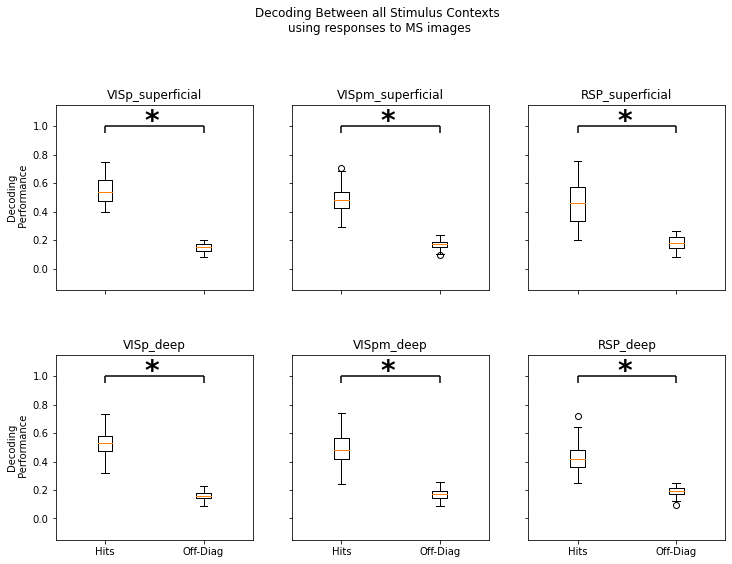

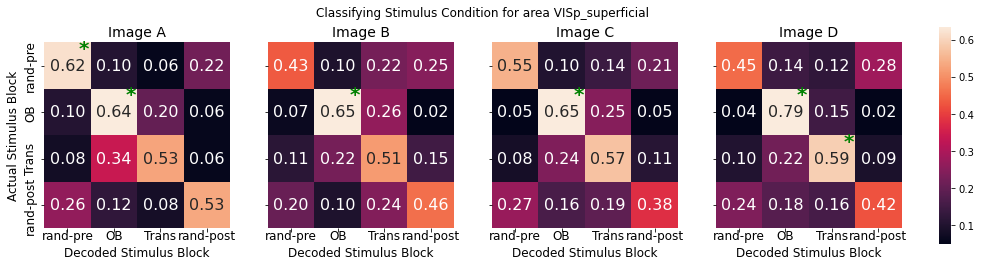

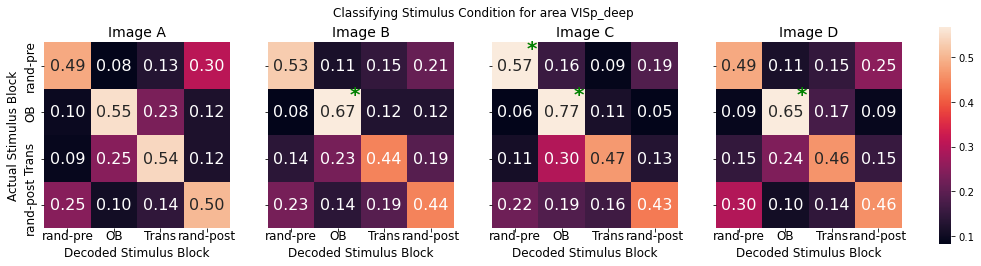

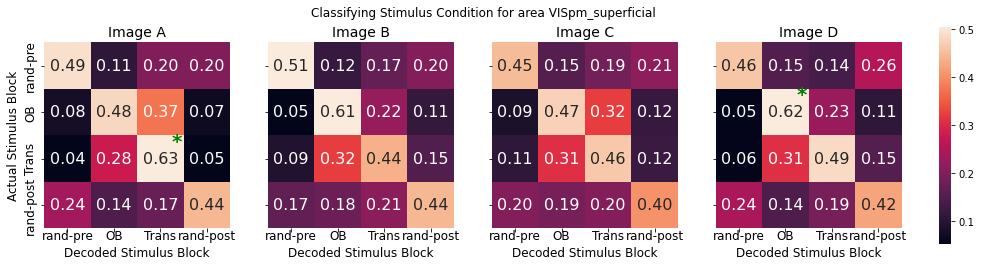

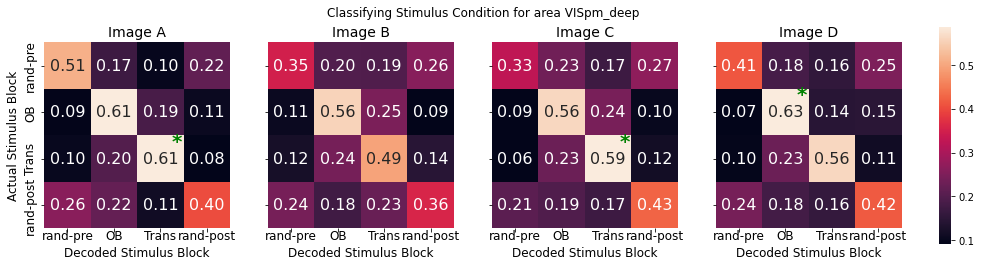

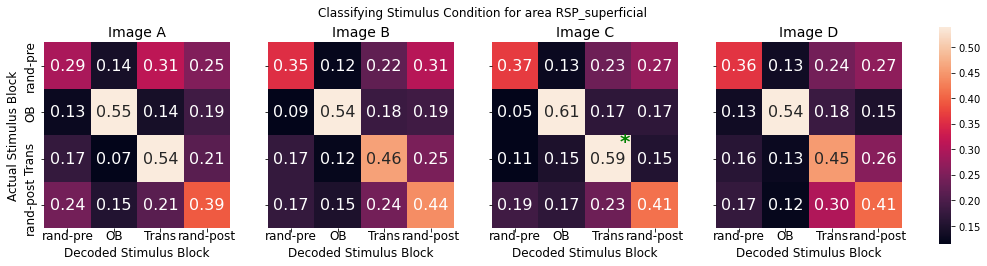

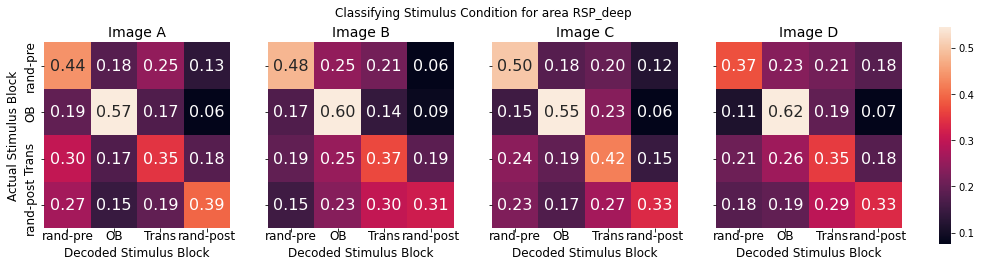

In [13]:
##===== Let's decode stimulus blocks from each other based on responses to MS images =====##
method='kfold'; classifier = 'SVM'
pval_thresh = 0.05
nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Where to save
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession_new'
PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

confusion_mat_dict = {}; confusion_z_dict = {}
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area]['oddball'].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        
        eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
            eID_list.append((eID,nNeurons))

            #Preallocate
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))
        
            #Get data for this area for each stimulus block
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(pop_responses[area]['randomized_control_pre'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(pop_responses[area]['transition_control'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(pop_responses[area]['randomized_control_post'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
            
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_post = np.where(Y_randctrl_post == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
                Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])
                
                #Perform Cross-validation
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg], _ = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method)
                
            #For each MS decoding, take the mean of the diagonal and off-diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
            offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        #Save decoding results
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('diag_hits_list',data=diag_hits_list)
            h5file.create_dataset('offdiag_hits_list',data=offdiag_hits_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            
        confusion_mat_dict[locstr] = confusion_mat_list
        confusion_z_dict[locstr] = confusion_z_list
        
        #Plot shuffle distributions
        dc.plot_confusion_matrices(np.mean(confusion_mat_list,axis=0),np.mean(confusion_z_list,axis=0),plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_avg-over-eIDs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        pdfdoc = PdfPages(os.path.join(PlotDir,'StimulusBlocks_MSimgs_{}_{}_{}.pdf'.format(locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_confusion_matrices(cm,cmz,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
            plt.suptitle('Classifying Stimulus Condition for area {}\ns{}, {} neurons'.format(locstr,*eID_list[indy]),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
        offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to MS images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingMSimgs{}_{}.png'.format(method,classifier)))

## Decode stimulus context
using trials where the oddball images were presented

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

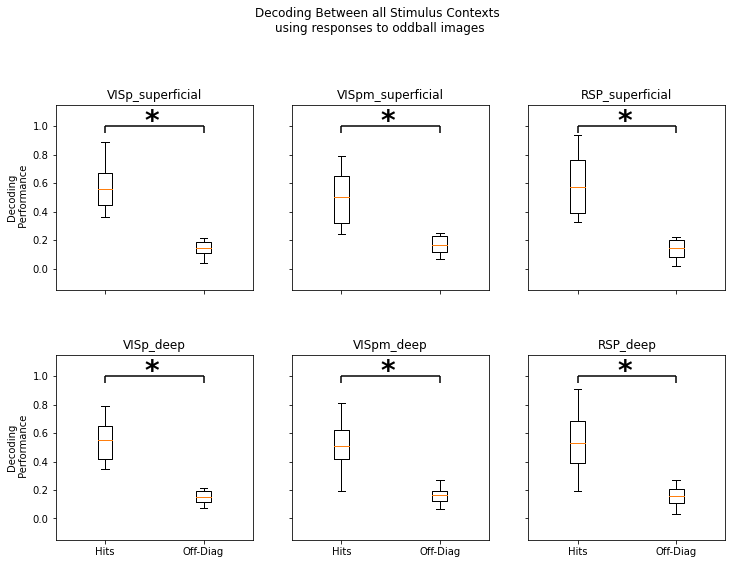

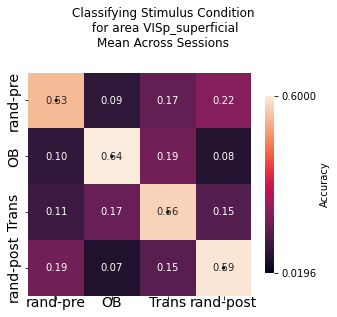

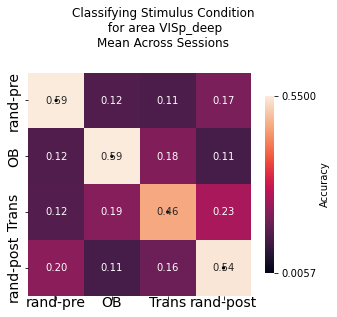

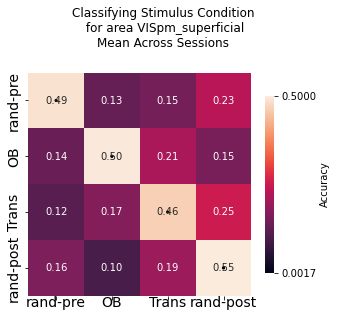

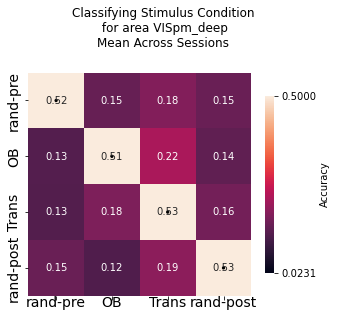

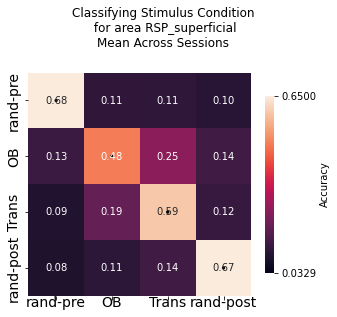

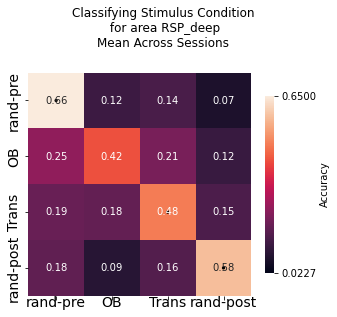

In [49]:
##===== Let's decode stimulus blocks from each other based on responses to oddball images =====##
method='kfold'; classifier = 'SVM'

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession_new'
fstr = 'persession'
PlotDir = os.path.join(SaveDir,'plots')
    
confusion_mat_dict = {}; confusion_z_dict = {}
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area]['oddball'].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
            eID_list.append((eID,nNeurons))

            #Get data for this area for each stimulus block
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(pop_responses[area]['randomized_control_pre'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='X')
            X_oddball, Y_oddball, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(pop_responses[area]['transition_control'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(pop_responses[area]['randomized_control_post'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='X')
            
            indy_list = []; indy_list2 = []; indy_list3 = []
            for iImg, img_ID in enumerate(oddball_ids):
                tmp = np.where(Y_randctrl_pre == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list.append(tmp[:10])

                tmp = np.where(Y_randctrl_post == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list2.append(tmp[:10])

                tmp = np.where(Y_transctrl == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list3.append(tmp[:10])

            indy_randctrlpre = np.concatenate(indy_list)
            indy_randctrlpost = np.concatenate(indy_list2)
            indy_transctrl = np.concatenate(indy_list3)

            #Construct X and Y from both blocks
            X = np.vstack((X_randctrl_pre[indy_randctrlpre,:],X_oddball,X_transctrl[indy_transctrl,:],X_randctrl_post[indy_randctrlpost,:]))
            Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])

            Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl_pre[ii])) for ii in indy_randctrlpre],
                                     ['{}_1'.format(int(yy)) for yy in Y_oddball],
                                     ['{}_2'.format(int(Y_transctrl[ii])) for ii in indy_transctrl],
                                     ['{}_3'.format(int(Y_randctrl_post[ii])) for ii in indy_randctrlpost]))

            #Decode stimulus context
            confusion_mat, confusion_shf, confusion_z, _ = dc.cross_validate(X,Y,Y_sort,clabels=[0,1,2,3],classifier=classifier,method=method)

            #Take diagonal
            diag_hits_list.extend(np.diag(confusion_mat))
            
            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
            
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'StimulusBlocks_Ximgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0)
        confusion_z_mean = np.mean(confusion_z_list,axis=0)
        confusion_mat_dict[locstr] = confusion_mat_list
        
        #Plot shuffle distributions
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition\n for area {}\nMean Across Sessions'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_usingoddballs_{}_{}_{}_{}.png'.format(fstr,locstr,method,classifier)))
        
        pdfdoc = PdfPages(os.path.join(PlotDir,'StimulusBlocks_usingoddballs_{}_{}_{}_{}.pdf'.format(fstr,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=['rand-pre','OB', 'Trans','rand-post'])
            plt.suptitle('Classifying Stimulus Condition for area {}\ns{}, {} neurons'.format(locstr,*eID_list[indy]),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(cm)  for cm in confusion_mat_list])
        offdiag_hits = np.concatenate([cm[off_diagonal_indy] for cm in confusion_mat_list])
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
        # ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to oddball images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingoddballs_{}{}_{}.png'.format(fstr,method,classifier)))

## Let's see if we can decode the randomized control PRE vs randomized control POST
using trials where the MS images were presented

In [ ]:
# Let's see if we can decode the randomized control PRE vs randomized control POST
#using trials where the MS images were presented

method='L1O'
nClasses = 2

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            

            #Get data for this area
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pop_responses[area][eID][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
            
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            nNeurons = X_randctrl_pre.shape[-1]
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
                indy_post = np.where(Y_randctrl_post == img_ID)[0]
                
                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl_pre[indy_pre,:],X_randctrl_post[indy_post,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)

            #For each MS decoding, take the mean of the diagonal and off-diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
            offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'RandomizedCtrl_PreVsPost_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_confusion_matrices(confusion_mat_mean,confusion_z_mean,plot_titles=['A','B','C','D'],class_labels=['Pre','Post'])
        plt.suptitle('Classifying RandCtrl Pre vs Post\nStimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'RandomizedCtrl_PreVsPost_avg-over-ms_{}_{}_{}_{}.png'.format(locstr,fstr,method,classifier)))


#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
#         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performancen')
            
fig2.suptitle('Decoding Between randomized control Pre vs Post \nusing responses to MS images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'RandCtrlPreVpost_BOXPLOT_usingMSimgs{}_{}.png'.format(method,classifier)))

## Let's see if we can decode the transition control vs oddball context 
using trials where the MS images were presented

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

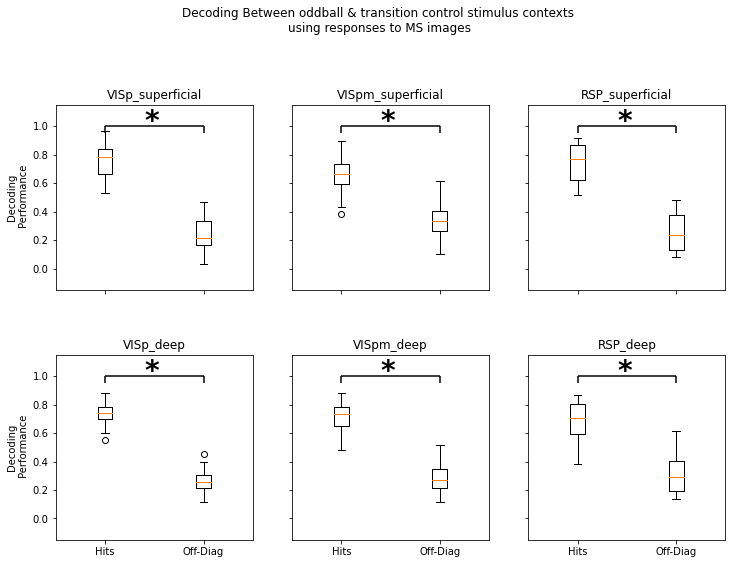

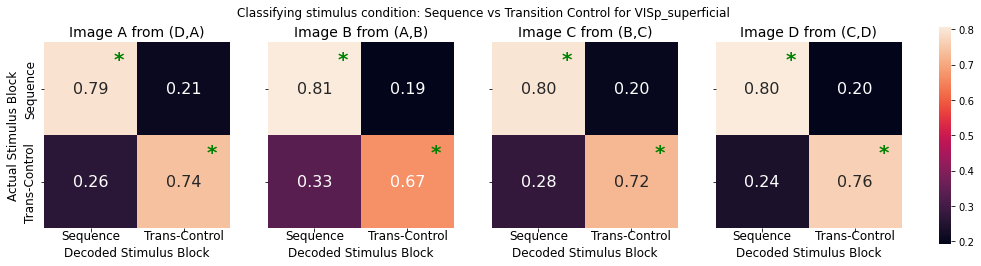

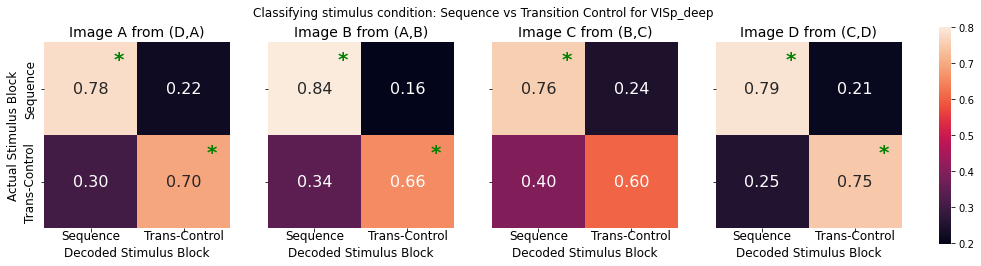

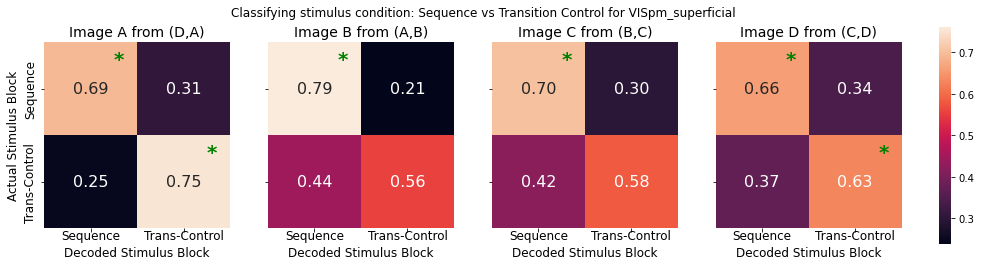

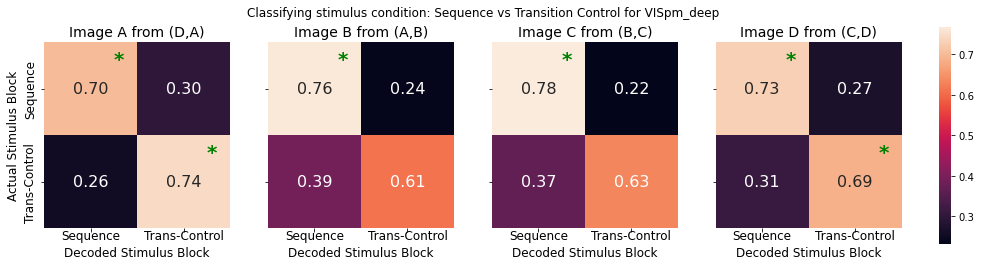

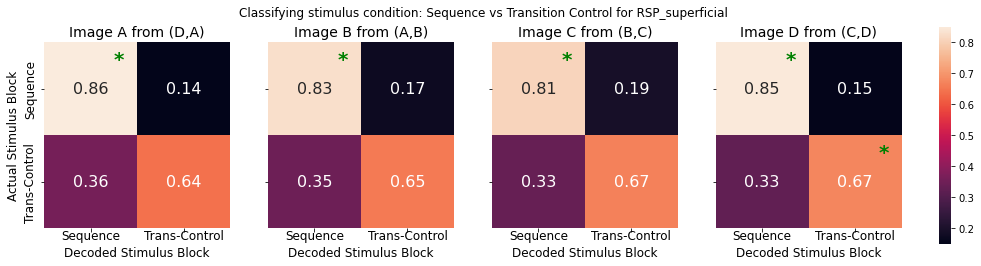

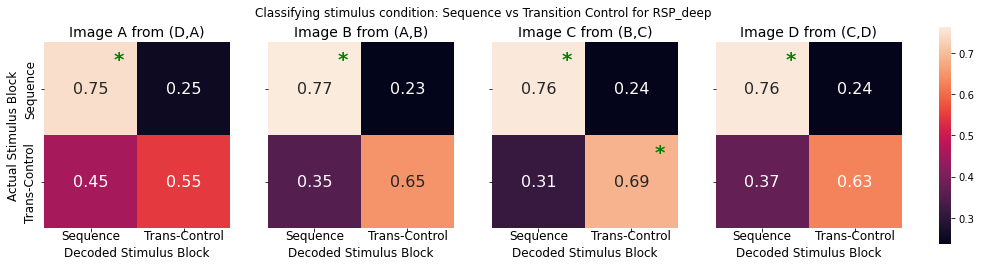

In [11]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
classifier = 'SVM'
method='L1O'

nClasses = 2


#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

method = 'L1O'
classifier = 'nearest_neighbor'
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area]['randomized_control_pre'].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons') 
            eID_list.append((eID,nNeurons))
  
            #Get trials where MS images were presented from the randomized_ctrl block
            X_transctrl, Y_transctrl, _ = dc.match_trials(pop_responses[area]['transition_control'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

            #Get trials where MS images were presented from the middle of the oddball block
            X_oddball, Y_oddball, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(0,120))
#             pdb.set_trace()
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))

            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:]))
                Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg],_ = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg],_ = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)
                    
            #For each MS decoding, take the mean of the diagonal and off-diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
            offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

#         fpath = os.path.join(SaveDir,'TransitionCtrlVsOddballBlocks_MSimgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
#         with h5py.File(fpath,'w') as h5file:
#             h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
#             h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
#             h5file.create_dataset('confusion_z_list',data=confusion_z_list)
#             h5file.create_dataset('locstr',data=locstr)
#             h5file.create_dataset('classifier',data=classifier)
#             h5file.create_dataset('method',data=method)
            
            
            

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_confusion_matrices(confusion_mat_mean, confusion_z_mean, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'])
        plt.suptitle('Classifying stimulus condition: Sequence vs Transition Control for {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_session-avg_first120_{}_{}_{}.png'.format(locstr,method,classifier)))

#         eID_list.append((eID,nNeurons))
        pdfdoc = PdfPages(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_first120_{}_{}_{}_{}.pdf'.format(locstr,fstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_confusion_matrices(cm, cmz, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'])
            plt.suptitle('Classifying Stimulus Condition for area {}\ns{}, {} neurons'.format(locstr,*eID_list[indy]),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()
        
#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
#         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
fig2.suptitle('Decoding Between oddball & transition control stimulus contexts \nusing responses to MS images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'TransitionCtrlVsOddballBlocks_BOXPLOT_first120_{}_{}_{}.png'.format(fstr,method,classifier)))

## What if we compare transition control with randomized control?
Give we can decode the oddball context from both the randomized control and transition control, we might expect the 2 to be indistiguishable...
But that's not what we find!

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='L1O'

nClasses = 2


#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

for pp, pstr in enumerate(['pre','post']):
# pp = 1; pstr = 'post'
    block_str = 'randomized_control_{}'.format(pstr)
    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    #Loop over areasconfusion_z_mean
    for ii, area in enumerate(areanames):
        #Get experimental IDs for area of interest
        experiment_ids = list(oddball_pop_responses[area].keys())



        #Loop over depth as well
        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            print(f'{locstr}:\t')

            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)


                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     

                #Get trials where MS images were presented from the randomized_ctrl block
                X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')

                #Get trials where MS images were presented from the middle of the oddball block
                X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pop_responses[area][eID][pp].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

                confusion_mat = np.zeros((4,nClasses,nClasses))
                confusion_shf = np.zeros((4,nClasses,nClasses))
                confusion_z = np.zeros((4,nClasses,nClasses))

                for iImg, img_ID in enumerate(mainseq_ids):
                    #Get stimulus presentation IDs for this particular image from both blocks
                    indy_randctrl = np.where(Y_randctrl == img_ID)[0]
                    indy_transctrl = np.where(Y_transctrl == img_ID)[0]

                    #Construct X and Y from both blocks
                    X = np.vstack((X_randctrl[indy_randctrl,:],X_transctrl[indy_transctrl,:]))
                    Y = np.hstack((np.repeat(0,30),np.repeat(1,30)))

                    if reduce_dim:
                        #Reduce dimensionality using PCA
                        pca = PCA(n_components=0.99)
                        X_pca = pca.fit_transform(X)
                        nComponents_pca = X_pca.shape[-1]
                        print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                        #Perform cross-validated decoding analysis
                        confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                    else:
                        confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)

                #For each MS decoding, take the mean of the diagonal and off-diagonal
                diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
                offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

            fpath = os.path.join(SaveDir,'TransCtrlVsRandCtrl-{}_MSimgs_{}_{}_{}_{}.mat'.format(pstr,locstr,fstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
                h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
                h5file.create_dataset('confusion_z_list',data=confusion_z_list)
                h5file.create_dataset('locstr',data=locstr)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
            dc.plot_confusion_matrices(confusion_mat_mean, confusion_z_mean, plot_titles=['A from (D,A)','B from (A,B)','C from (B,C)','D from (C,D)'],class_labels=['Sequence','Trans-Control'])
            plt.suptitle('Classifying stimulus condition: Rand-Ctrl-{} vs Transition Control for {}'.format(pstr,locstr),y=0.95)
            plt.savefig(os.path.join(PlotDir,'TransCtrlVsRandCtrl-{}_MSimgs_{}_{}_{}_{}.png'.format(pstr,locstr,fstr,method,classifier)))


    #         #Sparate diagonal and off-diagonal performance
    #         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
    #         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

            _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
            ax = axes2[jj,ii]
            ax.set_title(f'{locstr}')
    #         ax.boxplot([diag_hits,offdiag_hits])
            ax.boxplot([diag_hits_list,offdiag_hits_list])
            if pval < pval_thresh:
                ax.hlines(1,*[1,2],color='k',zorder=0)
                ax.vlines(2,*[1,.95],color='k',zorder=0) 
                ax.vlines(1,*[1,.95],color='k',zorder=0)
                ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

            ax.set_ylim([-0.15,1.15])

            if jj == 1:
                ax.set_xticks([1,2])
                ax.set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                ax.set_ylabel('Decoding\n Performance')

    fig2.suptitle(f'Decoding Between Rand-Ctrl-{pstr} & transition control stimulus contexts \nusing responses to MS images',y=1.05)
    fig2.savefig(os.path.join(PlotDir,'TransCtrlVsRandCtrl-{}_MSimgs_BOXPLOT_{}_{}_{}.png'.format(pstr,fstr,method,classifier)))

## Let's use the oddball images to see if we decode context
Again, let's start with oddball vs randomized control

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 2


#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

for pp, pstr in enumerate(['pre','post']):
# pp = 1; pstr = 'post'
    block_str = 'randomized_control_{}'.format(pstr)
    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    #Loop over areasconfusion_z_mean
    for ii, area in enumerate(areanames):
        #Get experimental IDs for area of interest
        experiment_ids = list(oddball_pop_responses[area].keys())



        #Loop over depth as well
        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            print(f'{locstr}:\t')

            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)

                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
                
                #Get data for this area for each stimulus block
                X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pop_responses[area][eID][pp].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
                X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
#                 X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

                indy_list = []; indy_list2 = []
                for iImg, img_ID in enumerate(oddball_ids):
                    tmp = np.where(Y_randctrl == img_ID)[0]
                    np.random.shuffle(tmp)
                    indy_list.append(tmp[:10])

#                     tmp = np.where(Y_transctrl == img_ID)[0]
#                     np.random.shuffle(tmp)
#                     indy_list2.append(tmp[:10])

                indy_randctrl = np.concatenate(indy_list)
#                 indy_transctrl = np.concatenate(indy_list2)

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl[indy_randctrl,:],X_oddball))
                Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])

                Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl[index])) for index in indy_randctrl],
                                         ['{}_1'.format(int(yy)) for yy in Y_oddball]))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)


                #Take diagonal
                diag_hits_list.extend(np.diag(confusion_mat))

                #For off diagonals, take mean of each rows' off-diagonals
                tmp = confusion_mat.copy()
                tmp[np.diag_indices(nClasses)] = np.nan
                offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);

                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

            fpath = os.path.join(SaveDir,'OddballVsRandCtrl-{}_Ximgs_{}_{}_{}_{}.mat'.format(pstr,locstr,fstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
                h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
                h5file.create_dataset('confusion_z_list',data=confusion_z_list)
                h5file.create_dataset('locstr',data=locstr)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
            dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['Oddball',block_str])
            plt.suptitle('Classifying Stimulus Condition\n for area {}\nMean Across Sessions'.format(locstr),y=0.995)
            plt.savefig(os.path.join(PlotDir,'OddballVsRandCtrl-{}_Ximgs_{}_{}_{}_{}.png'.format(pstr,locstr,fstr,method,classifier)))


    #         #Sparate diagonal and off-diagonal performance
    #         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
    #         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

            _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
            ax = axes2[jj,ii]
            ax.set_title(f'{locstr}')
    #         ax.boxplot([diag_hits,offdiag_hits])
            ax.boxplot([diag_hits_list,offdiag_hits_list])
            if pval < pval_thresh:
                ax.hlines(1,*[1,2],color='k',zorder=0)
                ax.vlines(2,*[1,.95],color='k',zorder=0) 
                ax.vlines(1,*[1,.95],color='k',zorder=0)
                ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

            ax.set_ylim([-0.15,1.15])

            if jj == 1:
                ax.set_xticks([1,2])
                ax.set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                ax.set_ylabel('Decoding\n Performance')

    fig2.suptitle(f'Decoding Between Rand-Ctrl-{pstr} & odbball stimulus contexts \nusing responses to oddball images',y=1.05)
    fig2.savefig(os.path.join(PlotDir,'OddballVsRandCtrl-{}_Ximgs_BOXPLOT_{}_{}_{}.png'.format(pstr,fstr,method,classifier)))

## What about oddball vs transition control?
again using the oddball images separately, then averaging over them

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='L1O'

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     

            #Get data for this area for each stimulus block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                np.random.shuffle(indy_transctrl)

                #Construct X and Y from both blocks
                X = np.vstack((X_oddball[indy_oddball,:],X_transctrl[indy_transctrl[:10],:]))
                Y = np.hstack((np.repeat(0,10),np.repeat(1,10)))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,Y,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)


            #Take diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[iImg])) for iImg, img_ID in enumerate(oddball_ids)])
            offdiag_hits_list.extend([np.mean(confusion_mat[iImg][off_diagonal_indy]) for iImg, img_ID in enumerate(oddball_ids)])
            
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        #Plot shuffle distributions
#         pdb.set_trace()
        confusion_mat_mean = np.mean(np.concatenate(confusion_mat_list,axis=0),axis=0); confusion_z_mean = np.mean(np.concatenate(confusion_z_list,axis=0),axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['Oddball','Trans-Ctrl'])
        plt.suptitle('Classifying Stimulus Condition\n for area {}\nMean Across Sessions'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'OddballVsTransCtrl_avg-over-Ximgs_{}_{}_{}_{}.png'.format(locstr,fstr,method,classifier)))


#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm)  for cm in confusion_mat_list])
#         offdiag_hits = np.concatenate([cm[off_diagonal_indy] for cm in confusion_mat_list])

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle('Decoding Between Trans-Ctrl & odbball stimulus contexts \nusing responses to oddball images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'OddballVsTransCtrl_avg-over-Ximgs_BOXPLOT_{}_{}_{}.png'.format(fstr,method,classifier)))

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     

            #Get data for this area for each stimulus block
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

            indy_list = []
            for iImg, img_ID in enumerate(oddball_ids):
                tmp = np.where(Y_transctrl == img_ID)[0]
                np.random.shuffle(tmp)
                indy_list.append(tmp[:10])

            indy_transctrl = np.concatenate(indy_list)

            #Construct X and Y from both blocks
            X = np.vstack((X_transctrl[indy_transctrl,:],X_oddball))
            Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])

            Y_sort = np.concatenate((['{}_0'.format(int(Y_transctrl[index])) for index in indy_transctrl],
                                     ['{}_1'.format(int(yy)) for yy in Y_oddball]))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)


            #Take diagonal
            diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);

            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'OddballVsTransCtrl_Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['Oddball','Trans-Ctrl'])
        plt.suptitle('Classifying Stimulus Condition\n for area {}\nMean Across Sessions'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'OddballVsTransCtrl_Ximgs_{}_{}_{}_{}.png'.format(locstr,fstr,method,classifier)))


        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(cm)  for cm in confusion_mat_list])
        offdiag_hits = np.concatenate([cm[off_diagonal_indy] for cm in confusion_mat_list])

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
        ax.boxplot([diag_hits,offdiag_hits])
#         ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle('Decoding Between Trans-Ctrl & odbball stimulus contexts \nusing responses to oddball images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'OddballVsTransCtrl_Ximgs_BOXPLOT2_{}_{}_{}.png'.format(fstr,method,classifier)))

## What about transition control vs randomized control?
using the oddball images 

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 2


#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

for pp, pstr in enumerate(['pre','post']):
# pp = 1; pstr = 'post'
    block_str = 'randomized_control_{}'.format(pstr)
    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    #Loop over areasconfusion_z_mean
    for ii, area in enumerate(areanames):
        #Get experimental IDs for area of interest
        experiment_ids = list(oddball_pop_responses[area].keys())



        #Loop over depth as well
        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            print(f'{locstr}:\t')

            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)

                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
                
                #Get data for this area for each stimulus block
                X_randctrl, Y_randctrl, _ = dc.match_trials(randctrl_pop_responses[area][eID][pp].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
#                 X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X',trial_indy=slice(740,860))
                X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

                indy_list = []; indy_list2 = []
                for iImg, img_ID in enumerate(oddball_ids):
                    tmp = np.where(Y_randctrl == img_ID)[0]
                    np.random.shuffle(tmp)
                    indy_list.append(tmp[:10])

                    tmp = np.where(Y_transctrl == img_ID)[0]
                    np.random.shuffle(tmp)
                    indy_list2.append(tmp[:10])

                indy_randctrl = np.concatenate(indy_list)
                indy_transctrl = np.concatenate(indy_list2)

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl[indy_randctrl,:],X_transctrl[indy_transctrl,:]))
                Y = np.hstack([np.repeat(i,100) for i in range(nClasses)])

                Y_sort = np.concatenate((['{}_0'.format(int(Y_randctrl[index])) for index in indy_randctrl],
                                         ['{}_1'.format(int(Y_transctrl[index])) for index in indy_transctrl]))

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                    #Perform cross-validated decoding analysis
                    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                else:
                    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method,plot_shuffle=False,parallel=False)


                #Take diagonal
                diag_hits_list.extend(np.diag(confusion_mat))

                #For off diagonals, take mean of each rows' off-diagonals
                tmp = confusion_mat.copy()
                tmp[np.diag_indices(nClasses)] = np.nan
                offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);

                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

            fpath = os.path.join(SaveDir,'TransCtrlVsRandCtrl-{}_Ximgs_{}_{}_{}_{}.mat'.format(pstr,locstr,fstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
                h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
                h5file.create_dataset('confusion_z_list',data=confusion_z_list)
                h5file.create_dataset('locstr',data=locstr)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
            dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['Oddball',block_str])
            plt.suptitle('Classifying Stimulus Condition\n for area {}\nMean Across Sessions'.format(locstr),y=0.995)
            plt.savefig(os.path.join(PlotDir,'TransCtrlVsRandCtrl-{}_Ximgs_{}_{}_{}_{}.png'.format(pstr,locstr,fstr,method,classifier)))


    #         #Sparate diagonal and off-diagonal performance
    #         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
    #         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

            _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
            ax = axes2[jj,ii]
            ax.set_title(f'{locstr}')
    #         ax.boxplot([diag_hits,offdiag_hits])
            ax.boxplot([diag_hits_list,offdiag_hits_list])
            if pval < pval_thresh:
                ax.hlines(1,*[1,2],color='k',zorder=0)
                ax.vlines(2,*[1,.95],color='k',zorder=0) 
                ax.vlines(1,*[1,.95],color='k',zorder=0)
                ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

            ax.set_ylim([-0.15,1.15])

            if jj == 1:
                ax.set_xticks([1,2])
                ax.set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                ax.set_ylabel('Decoding\n Performance')

    fig2.suptitle(f'Decoding Between Rand-Ctrl-{pstr} & Trans-Ctrl stimulus contexts \nusing responses to oddball images',y=1.05)
    fig2.savefig(os.path.join(PlotDir,'TransCtrlVsRandCtrl-{}_Ximgs_BOXPLOT_{}_{}_{}.png'.format(pstr,fstr,method,classifier)))

## Let's try to decode trials in which image A followed image D vs an oddball
i.e. DA vs XA transitions in the transition control

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
            #Get data for this area for each stimulus block
            X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='DAXA')

            confusion_mat = np.zeros((len(oddball_ids),2,2))
            confusion_shf = np.zeros((len(oddball_ids),2,2))
            confusion_z = np.zeros((len(oddball_ids),2,2))

            for iImg, img_ID in enumerate(oddball_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_DA = np.where(Y_sort == mainseq_ids[0])[0]
                indy_XA = np.where(Y_sort == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_transctrl[indy_DA,:],X_transctrl[indy_XA,:]))
                Y = np.hstack((np.repeat(0,len(indy_DA)),np.repeat(1,len(indy_XA))))
#                 pdb.set_trace()

                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.99)
                    X_pca = pca.fit_transform(X)
                    nComponents_pca = X_pca.shape[-1]

                    #Perform cross-validated decoding analysis
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X_pca,Y,clabels=[0,1],classifier=classifier,method=method)

                else:
                    confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1],classifier=classifier,method=method)


            #Take diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[iImg])) for iImg, img_ID in enumerate(oddball_ids)])
            offdiag_hits_list.extend([np.mean(confusion_mat[iImg][off_diagonal_indy]) for iImg, img_ID in enumerate(oddball_ids)])
            
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'DAvsXA_TransCtrl-block_avg-over-Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(np.concatenate(confusion_mat_list,axis=0),axis=0); confusion_z_mean = np.mean(np.concatenate(confusion_z_list,axis=0),axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['(D,A)','(X,A)'])
        plt.suptitle('Classifying Transition Type\n Based on image A response; {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_avg-over-Ximgs_{}_{}_{}.png'.format(locstr,method,classifier)))

        #         eID_list.append((eID,nNeurons))
        pdfdoc = PdfPages(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_{}_{}_{}_{}.pdf'
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(np.mean(cm,axis=0),np.mean(cmz,axis=0),class_labels=mainseq_ids,class_labels=['(D,A)','(X,A)'])
            plt.suptitle('s{}, {} neurons; {}\n Classifying Transition Type\n Based on image A response'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()


        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle('Classifying Transition Type XA vs DA\n Based on image A response;',y=1.05)
fig2.savefig(os.path.join(PlotDir,'DAvsXA_TransCtrl-block_avg-over-Ximgs_BOXPLOT2_{}_{}_{}.png'.format(fstr,method,classifier)))

## What about in the oddball block: (X,A) vs (D,A)

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 2
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
            #Get data for this area for each stimulus block
            X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='DAXA')

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X)
                nComponents_pca = X_pca.shape[-1]

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=[0,1],classifier=classifier,method=method)

            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=[0,1],classifier=classifier,method=method)


            #Take diagonal
            diag_hits_list.append(np.mean(np.diag(confusion_mat)))
            offdiag_hits_list.append(np.mean(confusion_mat[off_diagonal_indy]))
            
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'DAvsXA_Oddball-block_avg-over-Ximgs_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['(D,A)','(X,A)'])
        plt.suptitle('Classifying Transition Type\n Based on image A response; {}'.format(locstr),y=0.925)
        plt.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}.png'.format(locstr,method,classifier)))

        #         eID_list.append((eID,nNeurons))
        pdfdoc = PdfPages(os.path.join(PlotDir,'DAvsXA_Oddball-block_{}_{}_{}_{}.pdf'.format(fstr,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=['(D,A)','(X,A)'])
            plt.suptitle('s{}, {} neurons; {}\n Classifying Transition Type\n Based on image A response'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle('Classifying Transition Type XA vs DA\n Based on image A response;',y=1.05)
fig2.savefig(os.path.join(PlotDir,'DAvsXA_Oddball-block_avg-over-Ximgs_BOXPLOT_{}_{}_{}.png'.format(fstr,method,classifier)))

## Image Identity
Let's see if we can decode image identity in the randomized blocks using the single session population 

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

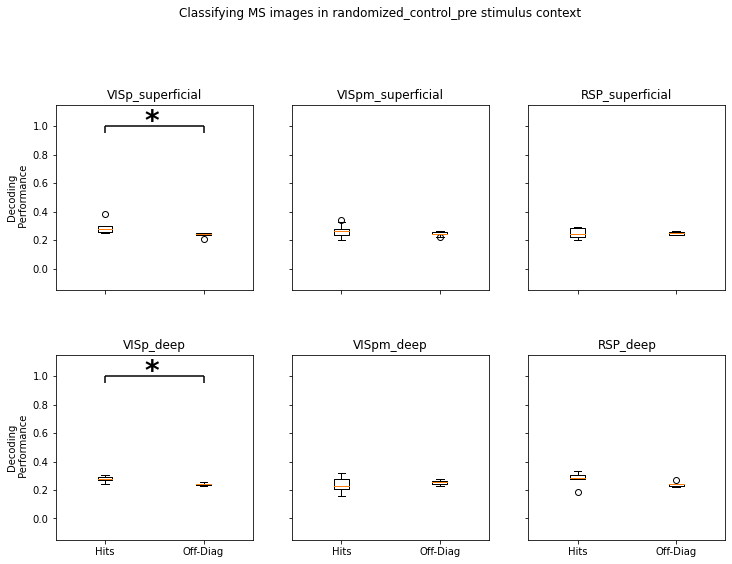

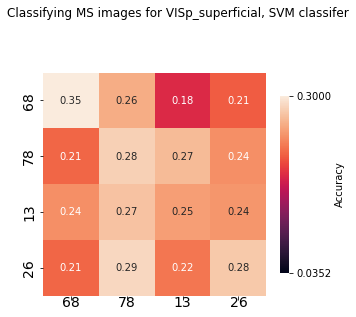

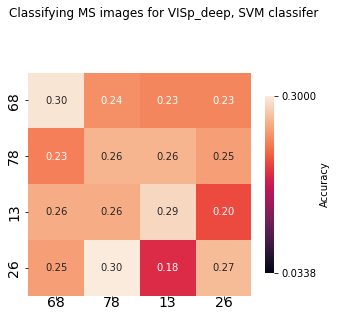

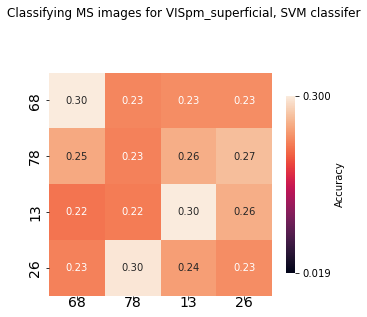

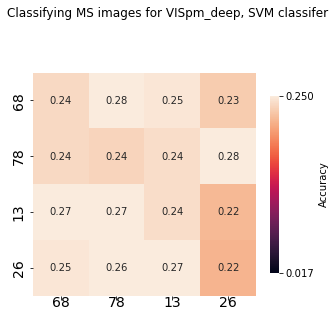

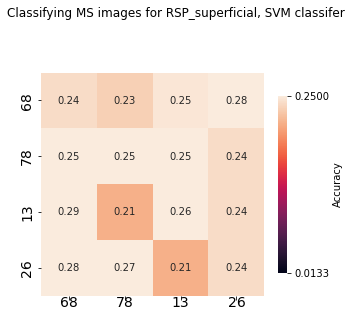

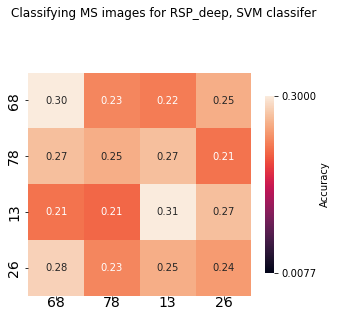

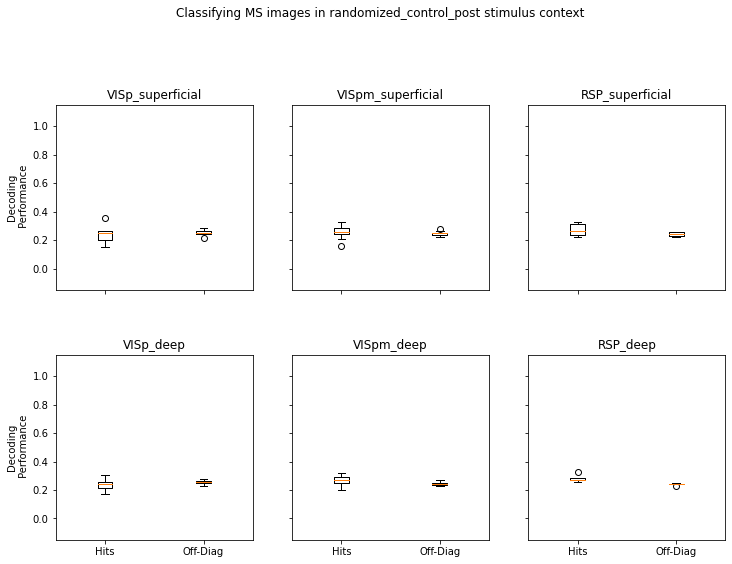

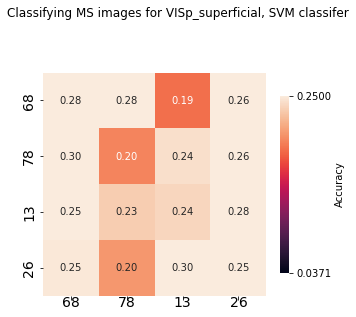

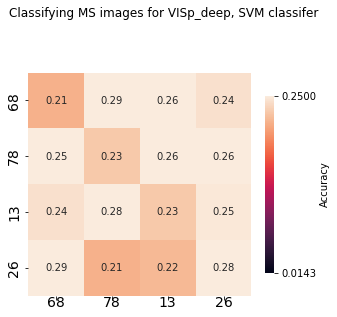

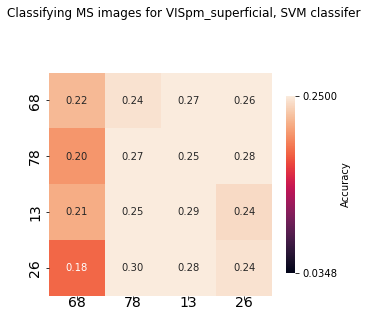

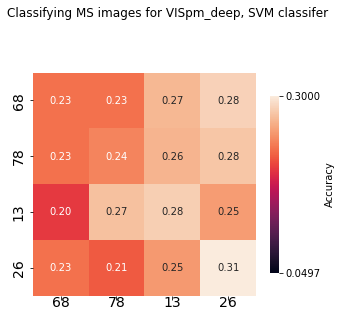

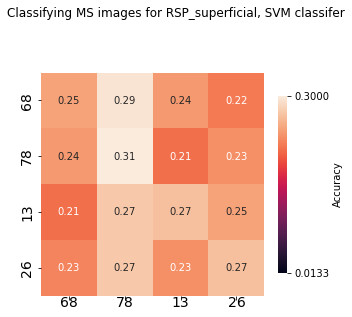

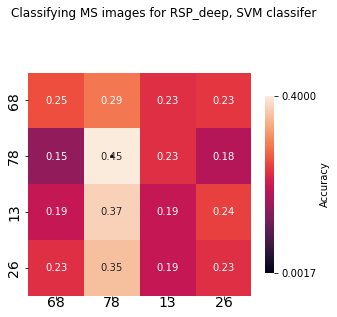

In [27]:

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

classifier = 'SVM'; method='L1O'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
fstr = 'persession'
PlotDir = os.path.join(SaveDir,'plots')

for pp, pstr in enumerate(['pre','post']):

    block_str = 'randomized_control_{}'.format(pstr)
    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    #Loop over areasconfusion_z_mean
    for ii, area in enumerate(areanames):
        #Get experimental IDs for area of interest
        experiment_ids = list(pop_responses[area]['oddball'].keys())

        #Loop over depth as well
        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            print(f'{locstr}:\t')

            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []; eID_list = []
            
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)

                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
                eID_list.append((eID,nNeurons))


                #Get data for this area for each stimulus block
                X, Y, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

                confusion_mat, confusion_shf, confusion_z, _ = dc.cross_validate(X, Y, Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,shuffle=False,plot_shuffle=False,parallel=False)

                #Take diagonal
                diag_hits_list.append(np.mean(np.diag(confusion_mat)))
                offdiag_hits_list.append(np.mean(confusion_mat[off_diagonal_indy]))
                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

            fpath = os.path.join(SaveDir,'mainseq_decoding_{}_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
                h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
                h5file.create_dataset('confusion_z_list',data=confusion_z_list)
                h5file.create_dataset('locstr',data=locstr)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
            dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=mainseq_ids)
            plt.suptitle('Classifying MS images for {}, {} classifer'.format(locstr,classifier),y=0.995)
            plt.savefig(os.path.join(PlotDir,'mainseq_decoding_{}_avg-over-sessions_{}_{}_{}.png'.format(block_str,locstr,method,classifier)))

            pdfdoc = PdfPages(os.path.join(PlotDir,'mainseq_decoding_{}_{}_{}_{}.pdf'.format(block_str,locstr,method,classifier)))
            for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
                dc.plot_decoding_accuracy(cm,cmz,class_labels=mainseq_ids,annot=True)
                plt.suptitle('s{}, {} neurons\n Classifying MS images for {}'.format(*eID_list[indy],locstr),y=0.995)
                pdfdoc.savefig()
                plt.close()
            pdfdoc.close()

            _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
            ax = axes2[jj,ii]
            ax.set_title(f'{locstr}')
    #         ax.boxplot([diag_hits,offdiag_hits])
            ax.boxplot([diag_hits_list,offdiag_hits_list])
            if pval < pval_thresh:
                ax.hlines(1,*[1,2],color='k',zorder=0)
                ax.vlines(2,*[1,.95],color='k',zorder=0) 
                ax.vlines(1,*[1,.95],color='k',zorder=0)
                ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

            ax.set_ylim([-0.15,1.15])

            if jj == 1:
                ax.set_xticks([1,2])
                ax.set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                ax.set_ylabel('Decoding\n Performance')

    fig2.suptitle(f'Classifying MS images in {block_str} stimulus context',y=1.05)
    fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_{}_BOXPLOT_{}_{}.png'.format(block_str,method,classifier)))


## Let's see if we can decode main-sequence image identity in the transition control block
using the second images of the (D,A),(A,B),(B,C),(C,D) transitions 

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

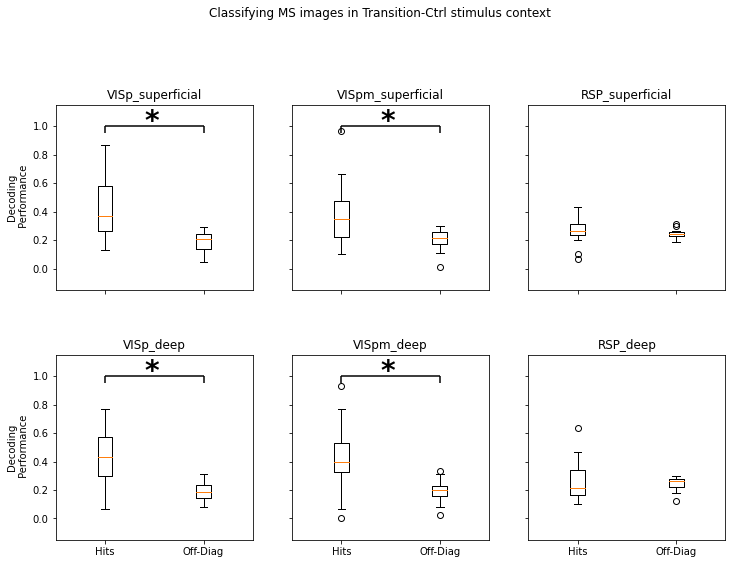

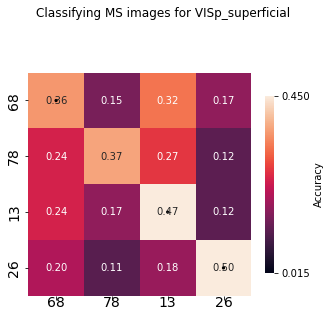

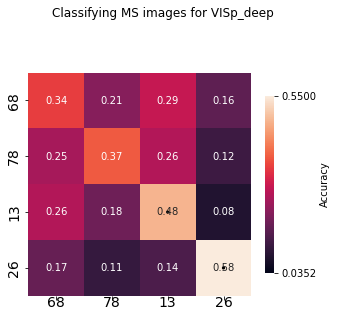

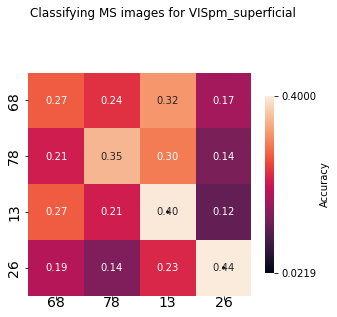

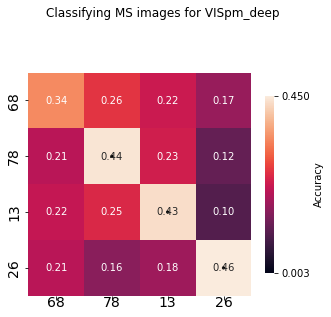

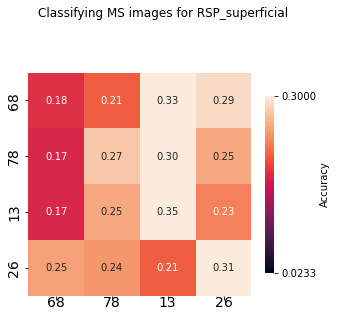

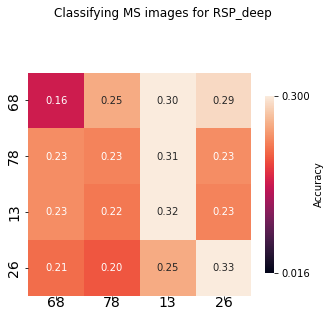

In [34]:
nClasses = 4

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

classifier = 'SVM'; method='L1O'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
fstr = 'persession'
PlotDir = os.path.join(SaveDir,'plots')

block_str = 'transition_control'
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))

            #Get data for this area for each stimulus block
            X, Y, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')

            #Perform cross-validated decoding analysis
            confusion_mat, confusion_shf, confusion_z,pvalues = dc.cross_validate(X, Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method)

            #Take diagonal
            diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'mainseq_decoding_{}_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=mainseq_ids)
        plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_{}_avg-over-sessions_{}_{}_{}.png'.format(block_str,locstr,method,classifier)))

        pdfdoc = PdfPages(os.path.join(PlotDir,'mainseq_decoding_{}_{}_{}_{}.pdf'.format(block_str,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=mainseq_ids,annot=True)
            plt.suptitle('s{}, {} neurons\n Classifying MS images for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle(f'Classifying MS images in Transition-Ctrl stimulus context',y=1.05)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_{}_BOXPLOT_{}_{}.png'.format(block_str,method,classifier)))


## Can we decode main-sequence image identity in the oddball block?
Let's use the first 240 trials, then 240 trials in the middle, then the last 240 trials

In [ ]:
method='kfold'
nClasses = 4

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

block_str = 'oddball'
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))

            #Get data for this area for each stimulus block
            X_oddball, Y_oddball, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD',trial_indy=slice(3000,3240))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_transctrl)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat, confusion_shf, confusion_z, pvalues = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)


            #Take diagonal
            diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)
            print(confusion_mat.shape)
        

        # with h5py.File(fpath,'r+') as h5file:
        #     del h5file['confusion_mat_list']
        #     h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=mainseq_ids)
        plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_avg-over-sessions_{}_{}_{}.png'.format(locstr,method,classifier)))

#         eID_list.append((eID,nNeurons))
        pdfdoc = PdfPages(os.path.join(PlotDir,'mainseq_decoding_oddball_{}_{}_{}.pdf'.format(locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=mainseq_ids,annot=True)
            plt.suptitle('s{}, {} neurons\n Classifying MS images for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle(f'Classifying MS images in the oddball stimulus context',y=1.05)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_BOXPLOT_{}_{}.png'.format(method,classifier)))


In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 4

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

block_str = 'oddball'
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
            #Get data for this area for each stimulus block
            X_oddball, Y_oddball, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD',trial_indy=slice(3000,3240))

            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_transctrl)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat, confusion_shf, confusion_z, pvalues = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)


            #Take diagonal
            diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=mainseq_ids)
        plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_avg-over-sessions_{}_{}_{}.png'.format(locstr,method,classifier)))

#         eID_list.append((eID,nNeurons))
        pdfdoc = PdfPages(os.path.join(PlotDir,'mainseq_decoding_oddball_{}_{}_{}.pdf'.format(locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=mainseq_ids,annot=True)
            plt.suptitle('s{}, {} neurons\n Classifying MS images for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle(f'Classifying MS images in the oddball stimulus context',y=1.05)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_BOXPLOT_{}_{}.png'.format(method,classifier)))


In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 4

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

slice_list = [slice(0,240),slice(3080,3320),slice(6160,6400)]
slice_str = ['first240','middle240','last240']

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean

ii = 0; area = areanames[ii]
#Get experimental IDs for area of interest
experiment_ids = list(pop_responses[area]['oddball'].keys())


depthstr = 'superficial'
locstr = '{}_{}'.format(area,depthstr)
print(f'{locstr}:\t')

confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
diag_hits_list = []; offdiag_hits_list = []; nNeurons_list = [];eID_list = []
#Loop over experimental IDs
for eID in experiment_ids:
    cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
    cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
    cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
    nNeurons = len(cell_ids_perdepth)

    if nNeurons < 20:
        continue
    print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
    nNeurons_list.append(len(cell_ids_perdepth)); eID_list.append(eID)

    #Get data for this area for each stimulus block
    X_oddball, Y_oddball, Y_sort = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(3080,3320))
#             print(np.unique(Y_sort,return_counts=True))
#             pdb.set_trace()
    if reduce_dim:
        #Reduce dimensionality using PCA
        pca = PCA(n_components=0.99)
        X_pca = pca.fit_transform(X_transctrl)
        nComponents_pca = X_pca.shape[-1]
        print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

        #Perform cross-validated decoding analysis
        confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,shuffle=False,parallel=False)
    else:
        confusion_mat, confusion_shf, confusion_z, pvalues = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,shuffle=False,parallel=False)

    #Take diagonal
    diag_hits_list.extend(np.diag(confusion_mat))

    #For off diagonals, take mean of each rows' off-diagonals
    tmp = confusion_mat.copy()
    tmp[np.diag_indices(nClasses)] = np.nan
    offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
    confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

# sl_str = 'middle-epoch'
# fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}_{}.mat'.format(locstr,sl_str,method,classifier))
# with h5py.File(fpath,'w') as h5file:
#     h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
#     h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
#     h5file.create_dataset('confusion_z_list',data=confusion_z_list)
#     h5file.create_dataset('nNeurons_list',data=nNeurons_list)
#     h5file.create_dataset('eID_list',data=eID_list)
#     h5file.create_dataset('locstr',data=locstr)
#     h5file.create_dataset('classifier',data=classifier)
#     h5file.create_dataset('method',data=method)

# #Plot shuffle distributions
# confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
# dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=mainseq_ids)
# plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.995)
# plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_{}_{}_{}_{}_{}.png'.format(locstr,sl_str,fstr,method,classifier)))

# #         plt.show()
# #         pdb.set_trace()
# #         #Sparate diagonal and off-diagonal performance
# #         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
# #         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

# _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
# ax = axes2[jj,ii]
# ax.set_title(f'{locstr}')
# #         ax.boxplot([diag_hits,offdiag_hits])
# ax.boxplot([diag_hits_list,offdiag_hits_list])
# if pval < pval_thresh:
#     ax.hlines(1,*[1,2],color='k',zorder=0)
#     ax.vlines(2,*[1,.95],color='k',zorder=0) 
#     ax.vlines(1,*[1,.95],color='k',zorder=0)
#     ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

# ax.set_ylim([-0.15,1.15])

# if jj == 1:
#     ax.set_xticks([1,2])
#     ax.set_xticklabels(['Hits','Off-Diag'])
# if ii == 0:
#     ax.set_ylabel('Decoding\n Performance')

# fig2.suptitle(f'Classifying MS images in the oddball stimulus context',y=1.05)
# fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_BOXPLOT_{}_{}_{}_{}.png'.format(sl_str,fstr,method,classifier)))


In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 4

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
fstr = 'persession'
PlotDir = os.path.join(SaveDir,'plots')


#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area]['oddball'].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; nNeurons_list = [];eID_list = []
        #Loop over experimental IDs
        for eID in tqdm(experiment_ids):
            
            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            nNeurons_list.append(len(cell_ids_perdepth)); eID_list.append(eID)

            #Extract results from parallel kfold processing
            if parallel:
                pool = mp.Pool(processes=40)
            processes = []; results = []
            start_times = np.arange(0,6001,400)
            for iStart in start_times:
                iEnd = iStart + 120

                sl_val = slice(iStart, iEnd)
                sl_str = 'start-{:03d}'.format(iStart)

                #Get data for this area for each stimulus block
                X_oddball, Y_oddball, Y_sort = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=sl_val)
                
                if parallel:
                    processes.append(pool.apply_async(dc.cross_validate,args=(X_oddball,Y_oddball), kwds={'Y_sort':Y_sort, 'clabels':mainseq_ids, 'classifier':classifier, 'method':method,}))
                else:
                    #Perform cross-validated decoding analysis
                    confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                    results.append((confusion_mat, confusion_shf, confusion_z))
            
            if parallel:
                results = [p.get() for p in processes]
                pool.close()
                
            confusion_mat = np.zeros((len(start_times),4,4))
            confusion_shf = np.zeros((len(start_times),4,4))
            confusion_z = np.zeros((len(start_times),4,4))
            for ii,(cm, cm_shf, cm_z) in enumerate(results):
                confusion_mat[ii] = cm
                confusion_shf[ii] = cm_shf
                confusion_z[ii] = cm_z
            
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('nNeurons_list',data=nNeurons_list)
            h5file.create_dataset('eID_list',data=eID_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)



In [ ]:
ls_list = ['-','--']
fig, ax = plt.subplots(figsize=(12,5))
for ii,area in enumerate(areanames):
    for jj,depthstr in enumerate(['superficial','deep']):
        
#         area = 'VISp'; depthstr = 'superficial'; ii = 0; jj = 0
        locstr = '{}_{}'.format(area,depthstr)
        
        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat_list =  np.array(h5file['confusion_mat_list'])
            confusion_shf_list =  np.array(h5file['confusion_shf_list'])
            confusion_z_list =  np.array(h5file['confusion_z_list'])
            nNeurons_list =  np.array(h5file['nNeurons_list'])
            eID_list =  np.array(h5file['eID_list'])
            
        indy = np.argsort(nNeurons_list);
        nNeurons_list = np.array(nNeurons_list)[indy]
        tmp_list = []
        for i in range(len(mainseq_ids)):
            tmp_list.append(confusion_mat_list[indy,:,i,i])
        
#         pdb.set_trace()
        mean_decoding_performance = np.mean(tmp_list,axis=0)
#             ax.errorbar(x=nNeurons_list,y=np.mean(tmp,axis=1),yerr=np.std(tmp,axis=1),color=cc[ii+5],ls=ls_list[jj])
        ax.plot(nNeurons_list,np.mean(mean_decoding_performance,axis=1),color=cc[ii+5],ls=ls_list[jj],marker='o',label=locstr)
            
ax.set_xlabel('# of neurons (per session)')
ax.set_ylabel('Decoding derformace')
ax.set_ylim([0.2,1])
ax.legend()

In [ ]:
ls_list = ['-','--']
fig, ax = plt.subplots(figsize=(12,5))
#Loop over areasconfusion_z_mean
# for ii, area in enumerate(areanames):
#     #Get experimental IDs for area of interest
#     experiment_ids = list(pop_responses[area]['oddball'].keys())

#     #Loop over depth as well
#     for jj,depthstr in enumerate(['superficial','deep']):
area = 'VISp'; depthstr = 'superficial'; ii = 0; jj = 0
locstr = '{}_{}'.format(area,depthstr)
print(f'{locstr}:\t')

fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_middle-epoch_{}_{}.mat'.format(locstr,method,classifier))
with h5py.File(fpath,'r') as h5file:
    confusion_mat_list =  np.array(h5file['confusion_mat_list'])
    confusion_shf_list =  np.array(h5file['confusion_shf_list'])
    confusion_z_list =  np.array(h5file['confusion_z_list'])
    nNeurons_list =  np.array(h5file['nNeurons_list'])
    eID_list =  np.array(h5file['eID_list'])

#         pdb.set_trace()
#         marker_list = ['$A$','$B$','$C$','$D$']
#         mean_decoding_performance = np.array([np.diag(cm) for cm in confusion_mat_list])
#         for ii in range(4):
#             ax.scatter(np.array(nNeurons_list).reshape(-1,1),mean_decoding_performance[:,ii],color=cc[counter],marker=marker_list[ii],s=100,label=locstr)
#         counter+=1
indy = np.argsort(nNeurons_list);
nNeurons_list = np.array(nNeurons_list)

mean_decoding_performance = np.array([np.mean(np.diag(cm)) for cm in confusion_mat_list])
ax.plot(nNeurons_list[indy],mean_decoding_performance[indy],color=cc[ii+5],ls=ls_list[jj],marker='o',label=locstr)
counter+=1  
        
ax.set_xlabel('# of neurons (per session)')
ax.set_ylabel('Decoding derformace')
ax.set_ylim([0.2,1])
ax.legend()
        
        


In [ ]:
fig, axes = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
fig.suptitle('Dependence of neural population size on decoding performance',y=1.05,fontsize=25)
ms_list= ['o','x']; ms_list2 = ['d','+']
for ii,area in enumerate(areanames):
    ax = axes[ii]; ax.set_title(area)
    #Loop over depth as well
    
    nlist = []; plist = []
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        
        method = 'kfold'; classifier = 'SVM'
        fpath = os.path.join('/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation','mainseq_decoding_nNeuron-dependence_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat = np.array(h5file['confusion_mat'])
            confusion_shf = np.array(h5file['confusion_shf'])
            confusion_z = np.array(h5file['confusion_z'])
            nNeurons_subselect = np.array(h5file['nNeurons_subselect'])
            
        tmp_list = []
        for i in range(len(mainseq_ids)):
            tmp = confusion_mat[:,:,i,i]; tmp_list.append(tmp)
            
        #average over main sequence images
        tmp = np.mean(tmp_list,axis=0)
        ax.errorbar(x=nNeurons_subselect,y=np.mean(tmp,axis=1),yerr=np.std(tmp,axis=1),color=cc[ii+5],marker='.',ls=ls_list[jj],label=f'{depthstr} pseudopopulation',lw=2)
        
        
        fpath = os.path.join('/home/dwyrick/projects/predictive_coding/results/decoding/persession','mainseq_decoding_oddball-block_{}_middle-epoch_kfold_SVM.mat'.format(locstr))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat_list =  np.array(h5file['confusion_mat_list'])
            confusion_shf_list =  np.array(h5file['confusion_shf_list'])
            confusion_z_list =  np.array(h5file['confusion_z_list'])
            nNeurons_list =  np.array(h5file['nNeurons_list'])
            eID_list =  np.array(h5file['eID_list'])
            
        indy = np.argsort(nNeurons_list);
        nNeurons_list = np.array(nNeurons_list)
        nNeurons_list = nNeurons_list[indy]
        mean_decoding_performance = np.array([np.mean(np.diag(cm)) for cm in confusion_mat_list])
        mean_decoding_performance = mean_decoding_performance[indy]
        ax.scatter(nNeurons_list,mean_decoding_performance,color='k',marker=ms_list2[jj],label=f'{depthstr} session',zorder=3,s=75)
#         
#         indy = np.where(nNeurons_list < 100)[0]
#         if len(indy) < 2:
#             ax.scatter(nNeurons_list[indy],mean_decoding_performance[indy],color='k',marker=ms_list2[jj])
#         else:
#             ax.boxplot(mean_decoding_performance[indy],positions = [50+25*jj],widths=50)
            
#         indy = np.where((nNeurons_list >= 100) & (nNeurons_list < 200))[0];
#         if len(indy) < 2:
#             ax.scatter(nNeurons_list[indy],mean_decoding_performance[indy],color='k',marker=ms_list2[jj])
#         else:
#             ax.boxplot(mean_decoding_performance[indy],positions = [150+25*jj],widths=50)
            
#         indy = np.where((nNeurons_list >= 200) & (nNeurons_list < 300))[0];
#         if len(indy) < 2:
#             ax.scatter(nNeurons_list[indy],mean_decoding_performance[indy],color='k',marker=ms_list2[jj])
#         else:
#             ax.boxplot(mean_decoding_performance[indy],positions = [250+25*jj],widths=50)
            
#         indy = np.where((nNeurons_list >= 300) & (nNeurons_list < 400))[0];
#         if len(indy) < 2:
#             ax.scatter(nNeurons_list[indy],mean_decoding_performance[indy],color='k',marker=ms_list2[jj])
#         else:
#             ax.boxplot(mean_decoding_performance[indy],positions = [350+25*jj],widths=50)
            
        
#         fpath = os.path.join(SaveDir,'mainseq_decoding_oddball-block_{}_{}_{}.mat'.format(locstr,method,classifier))
#         with h5py.File(fpath,'r') as h5file:
#             confusion_mat_list =  np.array(h5file['confusion_mat_list'])
#             confusion_shf_list =  np.array(h5file['confusion_shf_list'])
#             confusion_z_list =  np.array(h5file['confusion_z_list'])
#             nNeurons_list =  np.array(h5file['nNeurons_list'])
#             eID_list =  np.array(h5file['eID_list'])
            
#         indy = np.argsort(nNeurons_list);
#         nNeurons_list = np.array(nNeurons_list)[indy]
#         tmp_list = []
#         for i in range(len(mainseq_ids)):
#             tmp_list.append(confusion_mat_list[indy,:,i,i])
#         mean_decoding_performance = np.mean(tmp_list,axis=0)
#         ax.scatter(nNeurons_list,np.mean(mean_decoding_performance,axis=1),color='k',marker=ms_list[jj],label='per session')
        
    if ii == 1:
        ax.set_xlabel('# of neurons in pseudopopulation',fontsize=22)
    if ii == 0:
        ax.set_ylabel('Decoding derformace',fontsize=22)
    ax.set_ylim([0.2,1])#ax.set_xlim([0,400])
    ax.set_yticks([0.2,0.6,1])
#     ax.legend()

plt.savefig('./plots/paper/nNeuron_dependence_pseudpop_wolegend.pdf',facecolor='white', transparent=True, bbox_inches='tight')

        
        
        

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,10),sharey=True,sharex=True)
plt.suptitle('Classifying MS Images across oddball block using 50 presentations per image')

for jj,depthstr in enumerate(['superficial','deep']):
    for ii,area in enumerate(areanames):
        locstr = '{}_{}'.format(area,depthstr)
        
        hits = diag_hits[jj][ii]
        miss = offdiag_hits[jj][ii]
        ax = axes[jj,ii]
        ax.errorbar(x=np.arange(32),y=np.mean(hits,axis=-1),yerr=np.std(hits,axis=-1),color=cc[ii])
        ax.errorbar(x=np.arange(32),y=np.mean(miss,axis=-1),yerr=np.std(miss,axis=-1),color=cc[8])
        ax.set_title('{} {}'.format(depthstr,area))
        
        if jj == 1:
            ax.set_xlabel('Time (min)')
        if ii == 0:
            ax.set_ylabel('Decoding Performance')

plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball-block_TIMECOURSE_{}_{}.png'.format(method,classifier)))

## What if we use all of the trials possible?

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'

nClasses = 4

#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')

    
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     

            #Get data for this area for each stimulus block
            X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD')
#             X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
            print(np.unique(Y_sort,return_counts=True))
            pdb.set_trace()
            if reduce_dim:
                #Reduce dimensionality using PCA
                pca = PCA(n_components=0.99)
                X_pca = pca.fit_transform(X_transctrl)
                nComponents_pca = X_pca.shape[-1]
                print('{} components out of {} neurons required to capture 99% of variance'.format(nComponents_pca,X.shape[-1]))

                #Perform cross-validated decoding analysis
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_pca,Y,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)
            else:
                confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)


            #Take diagonal
            diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'mainseq_decoding_oddball_alltrials_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=mainseq_ids)
        plt.suptitle('Classifying MS images for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_alltrials_{}_{}_{}_{}_{}.png'.format(locstr,sl_str,fstr,method,classifier)))

#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
#         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle(f'Classifying MS images in the oddball stimulus context',y=1.05)
fig2.savefig(os.path.join(PlotDir,'mainseq_decoding_oddball_BOXPLOT_alltrials_{}_{}_{}_{}.png'.format(sl_str,fstr,method,classifier)))


## Decode oddball images from the random control block

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

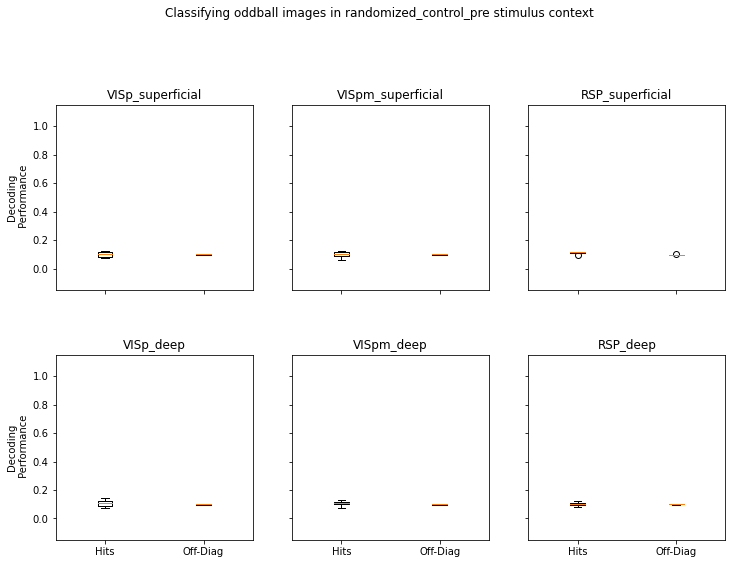

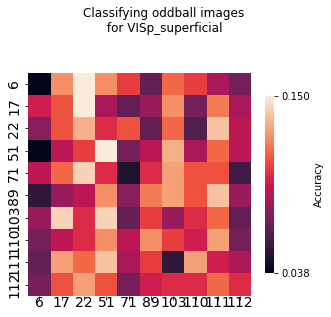

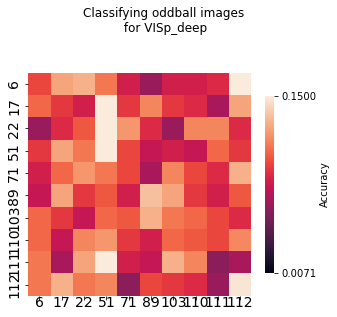

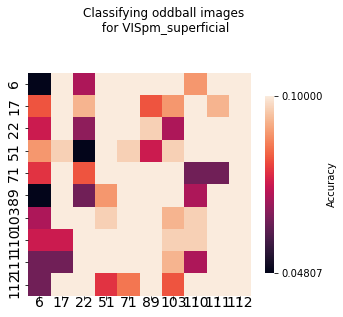

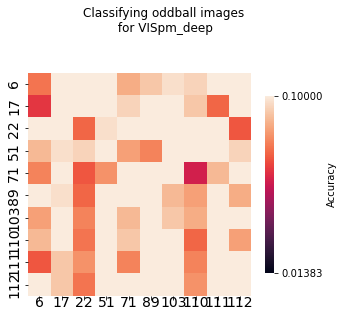

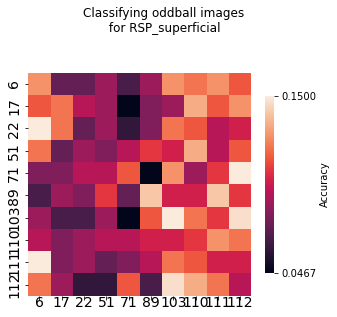

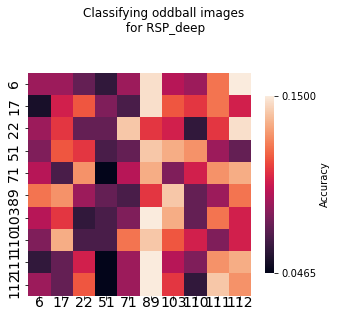

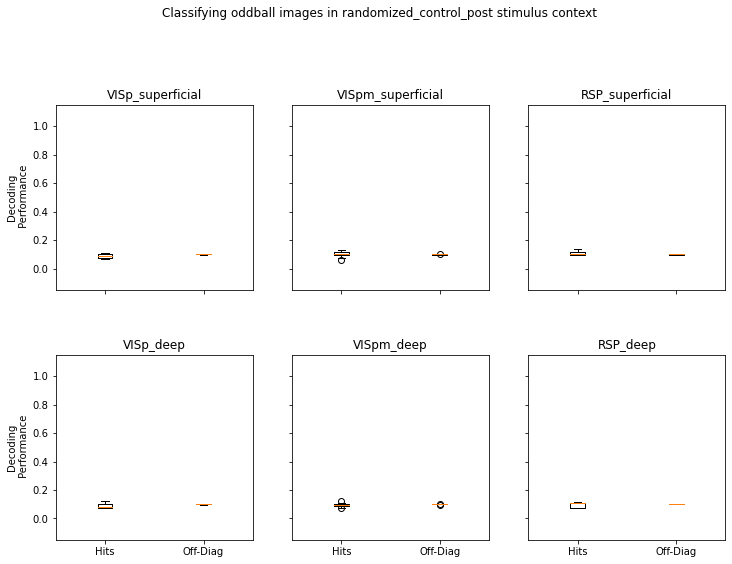

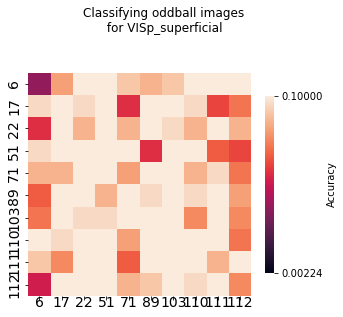

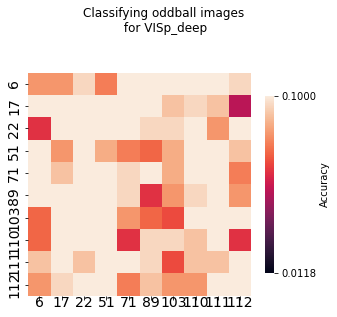

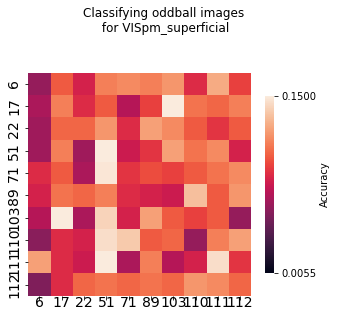

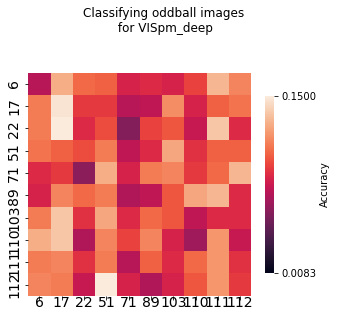

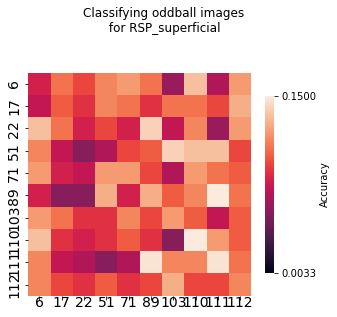

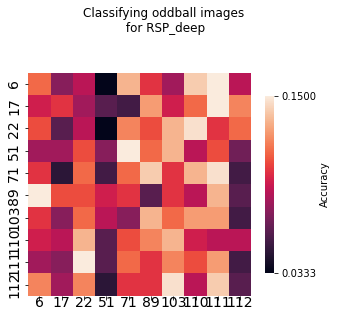

In [43]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'
pval_thresh = 0.05
nClasses = len(oddball_ids)

MAX_PROCESSES = 75
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))


classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession_new'
fstr = 'persession'
PlotDir = os.path.join(SaveDir,'plots')

for pp, pstr in enumerate(['pre','post']):
# pp = 1; pstr = 'post'
    block_str = 'randomized_control_{}'.format(pstr)
    fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
    #Loop over areas
    for ii, area in enumerate(areanames):
        #Get experimental IDs for area of interest
        experiment_ids = list(pop_responses[area][block_str].keys())

        #Loop over depth as well
        for jj,depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            print(f'{locstr}:\t')

    
            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []; eID_list = []
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)

                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
                eID_list.append((eID,nNeurons))
                #Get data for this area for each stimulus block
                X, Y, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

                #Perform decoding
                confusion_mat, confusion_shf, confusion_z, _ = dc.cross_validate(X, Y, Y_sort,clabels=oddball_ids,classifier=classifier,method=method,shuffle=True)

                #Save session decoding
                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

                #Take diagonal
                diag_hits_list.append(np.mean(np.diag(confusion_mat)))
                
                #Take diagonal
                # diag_hits_list.extend(np.diag(confusion_mat))

                #For off diagonals, take mean of each rows' off-diagonals
                tmp = confusion_mat.copy()
                tmp[np.diag_indices(nClasses)] = np.nan
                # offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)])
                offdiag_hits_list.append(np.mean([np.nanmean(tmp[i,:]) for i in range(nClasses)]))
                

            fpath = os.path.join(SaveDir,'X-img_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
            with h5py.File(fpath,'w') as h5file:
                h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
                h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
                h5file.create_dataset('confusion_z_list',data=confusion_z_list)
                h5file.create_dataset('locstr',data=locstr)
                h5file.create_dataset('classifier',data=classifier)
                h5file.create_dataset('method',data=method)

            #Plot shuffle distributions
            confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
            dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=oddball_ids,annot=False)
            plt.suptitle('Classifying oddball images\n for {}'.format(locstr),y=0.995)
            plt.savefig(os.path.join(PlotDir,'X-img_decoding_{}-block_avg-over-sessions_{}_{}_{}.png'.format(block_str,locstr,method,classifier)))
            
            pdfdoc = PdfPages(os.path.join(PlotDir,'X-img_decoding_{}-block_{}_{}_{}.pdf'.format(block_str,locstr,method,classifier)))
            for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
                dc.plot_decoding_accuracy(cm,cmz,class_labels=oddball_ids,annot=False)
                plt.suptitle('s{}, {} neurons\n Classifying oddball images for {}'.format(*eID_list[indy],locstr),y=0.995)
                pdfdoc.savefig()
                plt.close()
            pdfdoc.close()

    #         #Sparate diagonal and off-diagonal performance
    #         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
    #         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

            _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
            ax = axes2[jj,ii]
            ax.set_title(f'{locstr}')
    #         ax.boxplot([diag_hits,offdiag_hits])
            ax.boxplot([diag_hits_list,offdiag_hits_list])
            if pval < pval_thresh:
                ax.hlines(1,*[1,2],color='k',zorder=0)
                ax.vlines(2,*[1,.95],color='k',zorder=0) 
                ax.vlines(1,*[1,.95],color='k',zorder=0)
                ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

            ax.set_ylim([-0.15,1.15])

            if jj == 1:
                ax.set_xticks([1,2])
                ax.set_xticklabels(['Hits','Off-Diag'])
            if ii == 0:
                ax.set_ylabel('Decoding\n Performance')

    fig2.suptitle('Classifying oddball images in {} stimulus context'.format(block_str),y=1.05)
    fig2.savefig(os.path.join(PlotDir,'X-img_decoding_{}-block_BOXPLOT_{}_{}.png'.format(block_str,method,classifier)))


## Decode oddball images from the transition control block

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

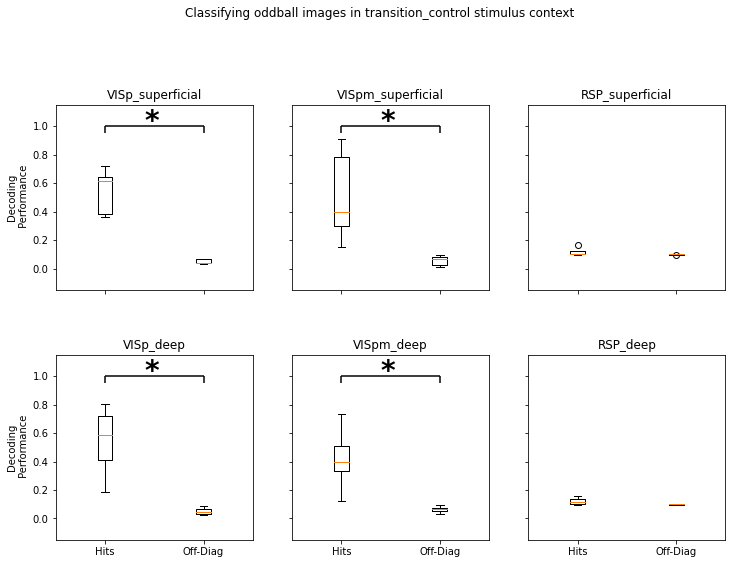

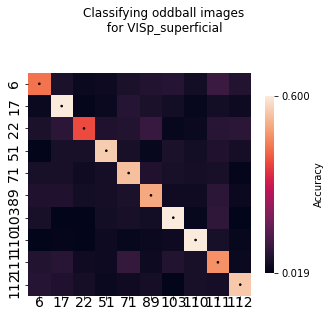

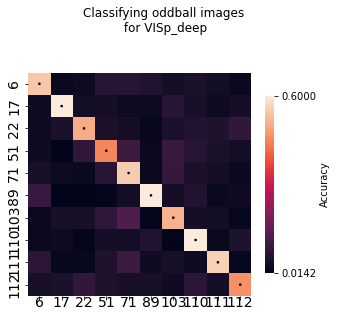

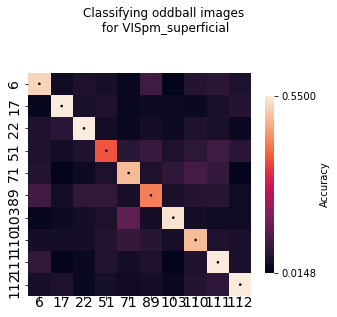

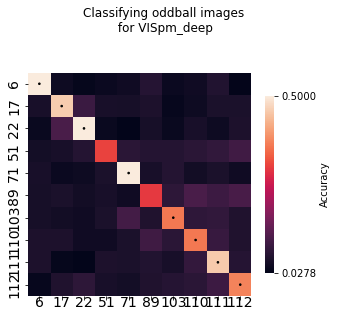

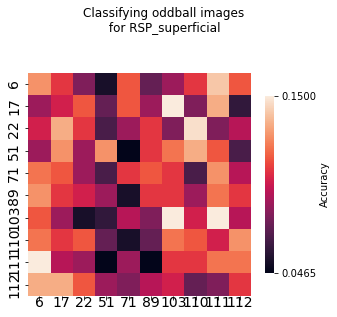

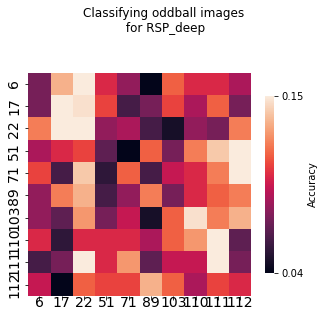

In [38]:
block_str = 'transition_control'

#Get off diagonal indices
upper_tmp = np.triu_indices(len(oddball_ids),k=1)
lower_tmp = np.tril_indices(len(oddball_ids),k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

classifier = 'SVM'; method='kfold'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession_new'
PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

   
        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
            #Get data for this area for each stimulus block
            X, Y, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Perform decoding
            confusion_mat, confusion_shf, confusion_z, _ = dc.cross_validate(X, Y, Y_sort,clabels=oddball_ids,classifier=classifier,method=method,shuffle=True)

            #Save session decoding
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

            #Take diagonal
            diag_hits_list.append(np.mean(np.diag(confusion_mat)))
            
            #Take diagonal
            # diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            # offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)])
            offdiag_hits_list.append(np.mean([np.nanmean(tmp[i,:]) for i in range(nClasses)]))
            

        fpath = os.path.join(SaveDir,'X-img_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=oddball_ids,annot=False)
        plt.suptitle('Classifying oddball images\n for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'X-img_decoding_{}-block_avg-over-sessions_{}_{}_{}.png'.format(block_str,locstr,method,classifier)))
        
        pdfdoc = PdfPages(os.path.join(PlotDir,'X-img_decoding_{}-block_{}_{}_{}.pdf'.format(block_str,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=oddball_ids,annot=False)
            plt.suptitle('s{}, {} neurons\n Classifying oddball images for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
#         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle('Classifying oddball images in {} stimulus context'.format(block_str),y=1.05)
fig2.savefig(os.path.join(PlotDir,'X-img_decoding_{}-block_BOXPLOT_{}_{}.png'.format(block_str,method,classifier)))


## Decode oddball images from the sequence block

VISp_superficial:	
817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
VISp_deep:	
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
VISpm_superficial:	
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
VISpm_deep:	
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
RSP_superfi

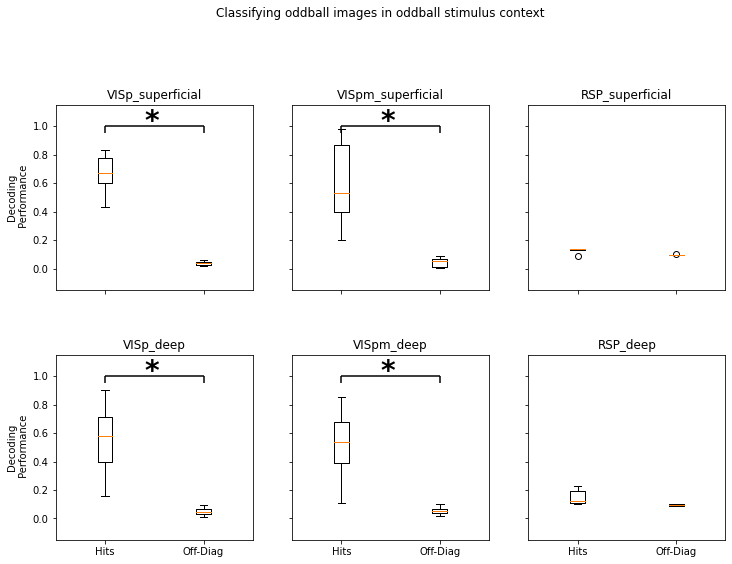

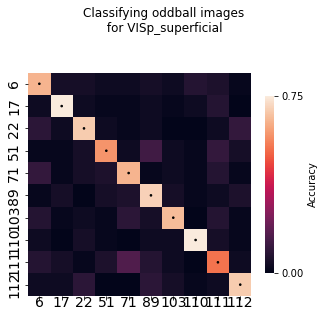

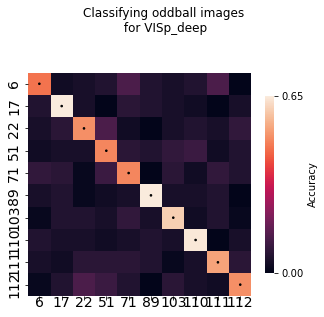

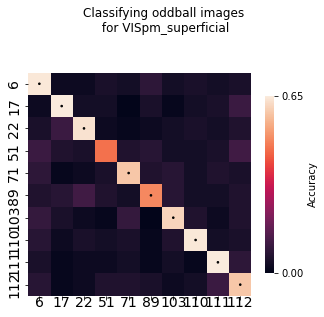

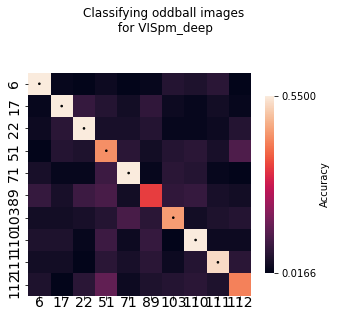

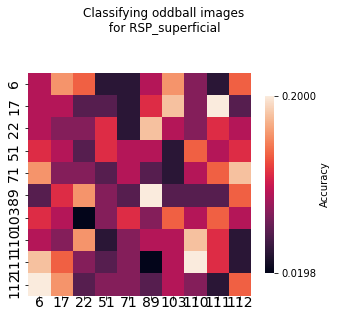

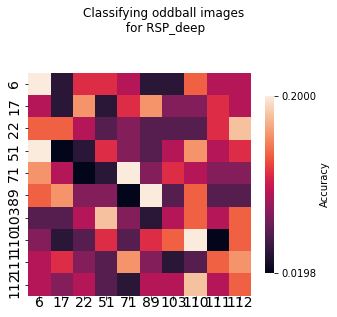

In [36]:
method='kfold'
pval_thresh = 0.05
nClasses = len(oddball_ids)

block_str = 'oddball'
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession_new'
PlotDir = os.path.join(SaveDir,'plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area]['oddball'].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')

   
        confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area]['oddball'][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
            #Get data for this area for each stimulus block
            X, Y, Y_sort = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')

            #Perform decoding
            confusion_mat, confusion_shf, confusion_z, _ = dc.cross_validate(X, Y, Y_sort,clabels=oddball_ids,classifier=classifier,method=method,shuffle=True)

            #Save session decoding
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

            #Take diagonal
            diag_hits_list.append(np.mean(np.diag(confusion_mat)))
            
            #Take diagonal
            # diag_hits_list.extend(np.diag(confusion_mat))

            #For off diagonals, take mean of each rows' off-diagonals
            tmp = confusion_mat.copy()
            tmp[np.diag_indices(nClasses)] = np.nan
            # offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)])
            offdiag_hits_list.append(np.mean([np.nanmean(tmp[i,:]) for i in range(nClasses)]))
            

        fpath = os.path.join(SaveDir,'X-img_decoding_{}-block_{}_{}_{}.mat'.format(block_str,locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=oddball_ids,annot=False)
        plt.suptitle('Classifying oddball images\n for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-block_avg-over-sessions_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        pdfdoc = PdfPages(os.path.join(PlotDir,'X-img_decoding_oddball-block_{}_{}_{}_{}.pdf'.format(fstr,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=oddball_ids,annot=False)
            plt.suptitle('s{}, {} neurons\n Classifying oddball images for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
#         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])

        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')

fig2.suptitle('Classifying oddball images in oddball stimulus context',y=1.05)
fig2.savefig(os.path.join(PlotDir,'X-img_decoding_oddball-block_BOXPLOT_{}_{}_{}.png'.format(fstr,method,classifier)))


In [ ]:
##===== Let's decode stimulus blocks from each other based on responses to MS images =====##
method='kfold'
classifier = 'SVM'

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Where to save
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
PlotDir = os.path.join(SaveDir,'plots')
PlotDir2 = os.path.join(SaveDir,'main_plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

confusion_mat_dict = {}; confusion_z_dict = {}
        
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        
        eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
            eID_list.append((eID,nNeurons))
            #Preallocate
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))
        
            #Get data for this area for each stimulus block
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pop_responses[area][eID][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
            
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_post = np.where(Y_randctrl_post == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
                Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])
                
                #Perform Cross-validation
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=True)
                

            #For each MS decoding, take the mean of the diagonal and off-diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
            offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        #Save decoding results
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('diag_hits_list',data=diag_hits_list)
            h5file.create_dataset('offdiag_hits_list',data=offdiag_hits_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            

        confusion_mat_dict[locstr] = confusion_mat_list
        confusion_z_dict[locstr] = confusion_z_list
        
        #Plot shuffle distributions
        dc.plot_confusion_matrices(np.mean(confusion_mat_list,axis=0),np.mean(confusion_z_list,axis=0),plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_avg-over-eIDs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        pdfdoc = PdfPages(os.path.join(PlotDir,'StimulusBlocks_{}_{}_{}_{}.pdf'.format(fstr,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_confusion_matrices(cm,cmz,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
            plt.suptitle('Classifying Stimulus Condition for area {}\ns{}, {} neurons'.format(locstr,*eID_list[indy]),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
        offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to MS images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingMSimgs{}_{}.png'.format(method,classifier)))

In [ ]:
##===== Let's decode stimulus blocks from each other based on responses to MS images =====##
method='kfold'
classifier = 'SVM'

nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

#Where to save
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
PlotDir = os.path.join(SaveDir,'plots')
PlotDir2 = os.path.join(SaveDir,'main_plots')

fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

confusion_mat_dict = {}; confusion_z_dict = {}
        
#Loop over areas
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        
        eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)
            
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')
            eID_list.append((eID,nNeurons))
            #Preallocate
            confusion_mat = np.zeros((4,nClasses,nClasses))
            confusion_shf = np.zeros((4,nClasses,nClasses))
            confusion_z = np.zeros((4,nClasses,nClasses))
        
            #Get data for this area for each stimulus block
            X_randctrl_pre, Y_randctrl_pre, _ = dc.match_trials(randctrl_pop_responses[area][eID][0].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            X_oddball, Y_oddball, _ = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(740,860))
            X_transctrl, Y_transctrl, _ = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
            X_randctrl_post, Y_randctrl_post, _ = dc.match_trials(randctrl_pop_responses[area][eID][1].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_post', trial_type='ABCD')
            
            for iImg, img_ID in enumerate(mainseq_ids):
                #Get stimulus presentation IDs for this particular image from both blocks
                indy_pre = np.where(Y_randctrl_pre == img_ID)[0]
                indy_oddball = np.where(Y_oddball == img_ID)[0]
                indy_transctrl = np.where(Y_transctrl == img_ID)[0]
                indy_post = np.where(Y_randctrl_post == img_ID)[0]

                #Construct X and Y from both blocks
                X = np.vstack((X_randctrl_pre[indy_pre,:],X_oddball[indy_oddball,:],X_transctrl[indy_transctrl,:],X_randctrl_post[indy_post,:]))
                Y = np.hstack([np.repeat(i,30) for i in range(nClasses)])
                
                #Perform Cross-validation
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg] = dc.cross_validate(X,Y,clabels=[0,1,2,3],classifier=classifier,method=method,plot_shuffle=False,parallel=True)
                

            #For each MS decoding, take the mean of the diagonal and off-diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
            offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
            confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        #Save decoding results
        fpath = os.path.join(SaveDir,'StimulusBlocks_MSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('diag_hits_list',data=diag_hits_list)
            h5file.create_dataset('offdiag_hits_list',data=offdiag_hits_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            

        confusion_mat_dict[locstr] = confusion_mat_list
        confusion_z_dict[locstr] = confusion_z_list
        
        #Plot shuffle distributions
        dc.plot_confusion_matrices(np.mean(confusion_mat_list,axis=0),np.mean(confusion_z_list,axis=0),plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
        plt.suptitle('Classifying Stimulus Condition for area {}'.format(locstr),y=0.95)
        plt.savefig(os.path.join(PlotDir,'StimulusBlocks_avg-over-ms_avg-over-eIDs_{}_{}_{}.png'.format(locstr,method,classifier)))
        
        pdfdoc = PdfPages(os.path.join(PlotDir,'StimulusBlocks_{}_{}_{}_{}.pdf'.format(fstr,locstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_confusion_matrices(cm,cmz,plot_titles=['A','B','C','D'],class_labels=['rand-pre','OB', 'Trans','rand-post'])
            plt.suptitle('Classifying Stimulus Condition for area {}\ns{}, {} neurons'.format(locstr,*eID_list[indy]),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()
        
        #Sparate diagonal and off-diagonal performance
        diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
        offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to MS images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingMSimgs{}_{}.png'.format(method,classifier)))

## Decode time

817251851.0 -> 239 neurons
826576489.0 -> 64 neurons
830075254.0 -> 282 neurons
835642229.0 -> 303 neurons
833626456.0 -> 116 neurons
827235482.0 -> 70 neurons
833611925.0 -> 204 neurons
813071318.0 -> 98 neurons
827232898.0 -> 75 neurons
830688059.0 -> 124 neurons
835654507.0 -> 356 neurons
836248932.0 -> 93 neurons
828959377.0 -> 74 neurons
834251985.0 -> 139 neurons
775613721.0 -> 81 neurons
818894752.0 -> 93 neurons
828956958.0 -> 43 neurons
832617299.0 -> 61 neurons
831312165.0 -> 256 neurons
836246273.0 -> 206 neurons
837630919.0 -> 48 neurons
835660148.0 -> 37 neurons
837283374.0 -> 70 neurons
776727982.0 -> 108 neurons
816795279.0 -> 77 neurons
829411383.0 -> 72 neurons
833599179.0 -> 38 neurons
832107135.0 -> 168 neurons
838330377.0 -> 106 neurons
836891984.0 -> 180 neurons
837287590.0 -> 32 neurons
831314921.0 -> 65 neurons
836253258.0 -> 36 neurons
837285285.0 -> 204 neurons
836890936.0 -> 74 neurons
768898762.0 -> 178 neurons
830688102.0 -> 142 neurons
833614835.0 -> 229 ne

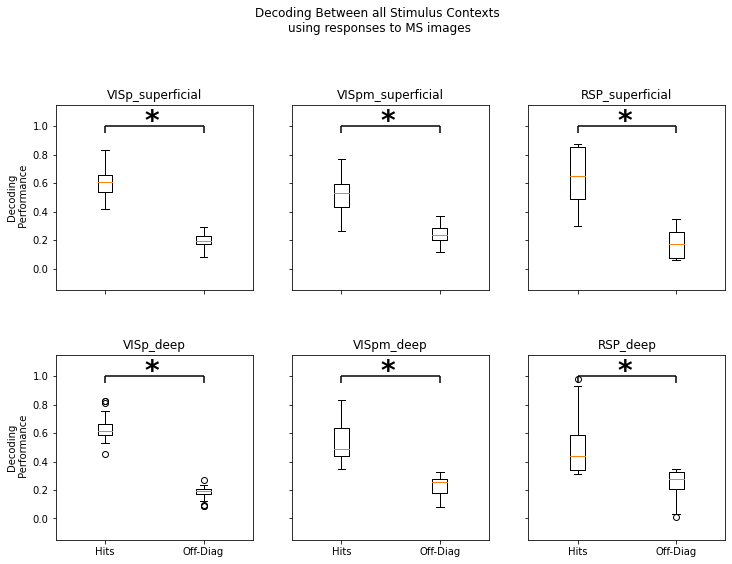

In [137]:
nClasses = 3
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

pval_thresh = 0.01
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

confusion_mat_dict = {}; confusion_z_dict = {}

block_str = 'oddball'
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        
        eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
                
        
            fig, axes = plt.subplots(1,4,figsize=(20,5))

            #Get trials where MS images
            X_list = []; Y_list = []; Y_sort_list = []
            for i in range(3):
                slindy = slice(i*3000+120,i*3000+240)
                X, Y, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
                Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
                X_list.append(X); Y_list.append(Y)
            X = np.concatenate(X_list); Y = np.concatenate(Y_list); Y_sort = np.concatenate(Y_sort_list)
#             pdb.set_trace()
            nEpochs = 3; nClasses = nEpochs
            confusion_mat = np.zeros((len(mainseq_ids), nClasses, nClasses))
            confusion_shf = np.zeros((len(mainseq_ids), nClasses, nClasses))
            confusion_z = np.zeros((len(mainseq_ids), nClasses, nClasses))
            
            #Perform decoding using each main-sequence image
            for iImg, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)[0]
                X_sub = X[indy]; Y_sort_sub = [Y_sort[index] for index in indy]
                Y_sub = np.array(Y_sort_sub).reshape(-1,)
                
                if reduce_dim:
                    #Reduce dimensionality using PCA
                    pca = PCA(n_components=0.90)
                    X_pca = pca.fit_transform(X_sub)
                    nComponents_pca = X_pca.shape[-1]
                    print('{} components out of {} neurons required to capture 90% of variance'.format(nComponents_pca,X.shape[-1]))
                    X_sub = X_pca
#                 pdb.set_trace()
                
                
                confusion_mat[iImg], confusion_shf[iImg], confusion_z[iImg], _ = dc.cross_validate(X_sub,Y_sub,clabels=np.unique(Y_sort_sub),classifier=classifier,method=method,parallel=True,nProcesses=75)

                dc.plot_decoding_accuracy(confusion_mat[iImg],confusion_z[iImg],ax=axes[iImg],class_labels=np.arange(nEpochs),title=mainseq_labels[iImg],annot=False,clims=[0,1])
                axes[iImg].set_xlabel('Actual Epoch')
                axes[iImg].set_ylabel('Decoded Epoch')

            plt.suptitle('Classifying Time within Sequence block using main-seq; {}, {} classifier'.format(locstr,classifier))
#             plt.savefig(os.path.join('./plots/paper/mouse','time_decoding-pca_oddball-block_{}_{}_{}_{}.png'.format(eID,locstr,method,classifier)))
#             plt.show()
#             pdb.set_trace()
            plt.close(fig)
            
            #For each MS decoding, take the mean of the diagonal and off-diagonal
            diag_hits_list.extend([np.mean(np.diag(confusion_mat[i])) for i in range(len(mainseq_ids))])
            offdiag_hits_list.extend([np.mean(confusion_mat[i][off_diagonal_indy]) for i in range(len(mainseq_ids))]);
            confusion_mat_list.append(np.mean(confusion_mat,axis=0)); confusion_shf_list.append(np.mean(confusion_shf,axis=0)); confusion_z_list.append(np.mean(confusion_z,axis=0))

        #Save decoding results
        fpath = os.path.join(SaveDir,'DecodeTimePerMouse_usingMSimgs_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            # h5file.create_dataset('diag_hits_list',data=diag_hits_list)
            # h5file.create_dataset('offdiag_hits_list',data=offdiag_hits_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            
        confusion_mat_dict[locstr] = confusion_mat_list
        confusion_z_dict[locstr] = confusion_z_list
        
        _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
        ax = axes2[jj,ii]
        ax.set_title(f'{locstr}')
#         ax.boxplot([diag_hits,offdiag_hits])
        ax.boxplot([diag_hits_list,offdiag_hits_list])
        if pval < pval_thresh:
            ax.hlines(1,*[1,2],color='k',zorder=0)
            ax.vlines(2,*[1,.95],color='k',zorder=0) 
            ax.vlines(1,*[1,.95],color='k',zorder=0)
            ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

        ax.set_ylim([-0.15,1.15])
        
        if jj == 1:
            ax.set_xticks([1,2])
            ax.set_xticklabels(['Hits','Off-Diag'])
        if ii == 0:
            ax.set_ylabel('Decoding\n Performance')
            
fig2.suptitle('Decoding Between all Stimulus Contexts \nusing responses to MS images',y=1.05)
fig2.savefig(os.path.join(PlotDir,'StimulusBlocks_BOXPLOT_usingMSimgs{}_{}.png'.format(method,classifier)))

In [ ]:
nClasses = 4
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'SVM'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')
    
method='kfold' 
classifier = 'SVM'

pval_thresh = 0.01
fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)

confusion_mat_dict = {}; confusion_z_dict = {}

block_str = 'oddball'
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        diag_hits_list = []; offdiag_hits_list = []
        
        eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
                
        
            fig, axes = plt.subplots(1,4,figsize=(20,5))

            #Get trials where MS images
            X_list = []; Y_list = []; Y_sort_list = []
            for i in range(7):
                slindy = slice(i*1000,i*1000+240)
                X, Y, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
                Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
                X_list.append(X); Y_list.append(Y)
            X = np.concatenate(X_list); Y = np.concatenate(Y_list); Y_sort = np.concatenate(Y_sort_list)
#             pdb.set_trace()
            nClasses = 7
            confusion_mat = np.zeros((len(mainseq_ids), nClasses, nClasses))
            confusion_shf = np.zeros((len(mainseq_ids), nClasses, nClasses))
            confusion_z = np.zeros((len(mainseq_ids), nClasses, nClasses))
            
            #Perform decoding using each main-sequence image
            for iImg, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)[0]
                X_sub = X[indy]; Y_sort_sub = [Y_sort[index] for index in indy]
                Y_sub = np.array(Y_sort_sub).reshape(-1,)
                
   

## Cross-Sequence Generalization Performance

In [ ]:
method='kfold'
reduce_dim=False
parallel = True; import multiprocessing as mp

nEpochs = 3
#Get off diagonal indices
upper_diagonal = np.triu_indices(nEpochs,k=1)
lower_diagonal = np.tril_indices(nEpochs,k=-1)
off_diagonal_indy = (np.concatenate((upper_diagonal[0],lower_diagonal[0])),np.concatenate((upper_diagonal[1],lower_diagonal[1])))

    
method='kfold' 
classifier = 'SVM'

pval_thresh = 0.01
# fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
block_str = 'oddball'
for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        
        confusion_mat_list = []; confusion_shf_list = []; confusion_z_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
        

            #Get trials where MS images
            X_list = []; Y_list = []; Y_sort_list = []
            for i in range(nEpochs):
                slindy = slice(i*3000+120,i*3000+240)
                X, Y, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
                Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
                X_list.append(X); Y_list.append(Y)
    #         X = np.concatenate(X_list); Y = np.concatenate(Y_list); Y_sort = np.concatenate(Y_sort_list)

            if parallel:
                pool = mp.Pool(processes=40)
                processes = []
            results = []

            for iTrain, (X_train,Y_train) in enumerate(zip(X_list,Y_list)):
                for iTest, (X_test,Y_test) in enumerate(zip(X_list,Y_list)):
                    if iTrain == iTest:
                        continue

                    if parallel:
                        processes.append(pool.apply_async(dc.decode_labels,args=(X_train,Y_train,None,None,classifier,mainseq_ids,X_test,Y_test,True,False)))

            #Extract results from parallel kfold processing
            if parallel:
                results = [p.get() for p in processes]
                pool.close()
                
            nClasses = nEpochs
            drift_confusion_mat = np.zeros((nEpochs,nEpochs))
            drift_confusion_shf = np.zeros((nEpochs,nEpochs))
            drift_confusion_z = np.zeros((nEpochs,nEpochs))
            
            # pool = mp.Pool(processes=40); processes = []
            for iEpoch, (X,Y) in enumerate(zip(X_list,Y_list)):
                # processes.append(pool.apply_async(dc.cross_validate,args=(X,Y,), kwds={'classifier':classifier,'clabels':mainseq_ids,'method':'L1O'}))
                confusion_mat, confusion_shf, confusion_z, pvalues = dc.cross_validate(X,Y,method='L1O',classifier=classifier,clabels=mainseq_ids,shuffle=True,parallel=False)
                drift_confusion_z[iEpoch,iEpoch] = np.mean(np.diag(confusion_z))
                drift_confusion_mat[iEpoch,iEpoch] = np.mean(np.diag(confusion_mat))
                drift_confusion_shf[iEpoch,iEpoch] = np.mean(np.diag(drift_confusion_shf))

#             for iEpoch,p in enumerate(processes):
#                 confusion_mat = p.get()[0]
#                 confusion_shf = p.get()[1]
#                 confusion_z = p.get()[2]
#                 drift_confusion_z[iEpoch,iEpoch] = np.mean(np.diag(confusion_z))
#                 drift_confusion_mat[iEpoch,iEpoch] = np.mean(np.diag(confusion_mat))
#                 drift_confusion_shf[iEpoch,iEpoch] = np.mean(np.diag(confusion_z))
#             pool.close()


            counter = 0

            for iTrain, (X_train,Y_train) in enumerate(zip(X_list,Y_list)):
                for iTest, (X_test,Y_test) in enumerate(zip(X_list,Y_list)):
                    if iTrain == iTest:
                        continue
                    kfold_hits, kfold_shf = results[counter]

                    confusion_mat = kfold_hits/np.sum(kfold_hits,axis=1).reshape(-1,1)
                    confusion_shf = np.zeros(kfold_shf.shape)
                    for i in range(kfold_shf.shape[0]):
                        confusion_shf[i] = kfold_shf[i]/np.sum(kfold_shf[i],axis=1).reshape(-1,1)
                    m_shf, s_shf = np.mean(confusion_shf,axis=0), np.std(confusion_shf,axis=0)
                    confusion_z = (confusion_mat - m_shf)/s_shf
    #                 pvalues = 1-2*np.abs(np.array([[st.percentileofscore(confusion_shf[:,i,j],confusion_mat[i,j],kind='strict') for j in range(4)] for i in range(4)])/100 - .5)
                    drift_confusion_z[iTrain,iTest] = np.mean(np.diag(confusion_z))
                    drift_confusion_mat[iTrain,iTest] = np.mean(np.diag(confusion_mat))
                    drift_confusion_shf[iTrain,iTest] = np.mean(np.diag(m_shf))
                    counter += 1

                
            fig, ax = plt.subplots(figsize=(6,6))
            dc.plot_decoding_accuracy(drift_confusion_mat,drift_confusion_z,ax=ax,class_labels=np.arange(nEpochs),title=f'{locstr}',annot=False,clims=[0,1])

            ax.set_xlabel('Test Epoch')
            ax.set_ylabel('Training Epoch')

            plt.suptitle('Classifying Main Sequence images\n across Sequence block {} classifier'.format(classifier),fontsize=12)
            plt.savefig(os.path.join('./plots/paper/mouse','oddball-block_MS-drift_{}_{}.png'.format(locstr,eID)))
            plt.close(fig)
#             plt.show()
#             pdb.set_trace()
            
             #For each MS decoding, take the mean of the diagonal and off-diagonal
#             CCGP_shf_list.append((drift_confusion_shf[lower_diagonal],drift_confusion_shf[upper_diagonal]))
#             CCGP_list.append((drift_confusion_shf[lower_diagonal],drift_confusion_shf[upper_diagonal]))
            confusion_mat_list.append(drift_confusion_mat); confusion_shf_list.append(drift_confusion_shf); confusion_z_list.append(drift_confusion_z)

        #Save decoding results
        fpath = os.path.join(SaveDir,'CrossSequenceGP_PerMouse_drift_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)
            
        drift_confusion_z = np.mean(confusion_z_list,axis=0); drift_confusion_z[np.diag_indices(nEpochs)] = np.nan
        drift_confusion_mat = np.mean(confusion_mat_list,axis=0);drift_confusion_mat[np.diag_indices(nEpochs)] = np.nan
        drift_confusion_shf = np.mean(confusion_shf_list,axis=0);drift_confusion_shf[np.diag_indices(nEpochs)] = np.nan

        fig, ax = plt.subplots(figsize=(6,6))
        dc.plot_decoding_accuracy(drift_confusion_mat,drift_confusion_z,ax=ax,class_labels=np.arange(nEpochs),title=f'{locstr}',annot=False,clims=[0.25,0.75])

        ax.set_xlabel('Test Epoch')
        ax.set_ylabel('Training Epoch')

#         plt.suptitle('Classifying Main Sequence images\n across Sequence block {} classifier'.format(classifier),fontsize=12)
        plt.savefig(os.path.join('./plots/paper','oddball-block_MS-drift_{}_{}.png'.format(locstr,classifier)))
#         plt.show()
#         pdb.set_trace()
        
        
            

            



In [159]:


for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{locstr} {eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append(eID)
            
        fpath = os.path.join(SaveDir,'CrossSequenceGP_PerMouse_drift_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'a') as h5file:
            del h5file[f'experiment_ids_{locstr}']
            h5file.create_dataset(f'experiment_ids_{locstr}',data=eID_list)

VISp_superficial 817251851.0 -> 239 neurons
VISp_superficial 826576489.0 -> 64 neurons
VISp_superficial 830075254.0 -> 282 neurons
VISp_superficial 835642229.0 -> 303 neurons
VISp_superficial 833626456.0 -> 116 neurons
VISp_superficial 827235482.0 -> 70 neurons
VISp_superficial 833611925.0 -> 204 neurons
VISp_deep 813071318.0 -> 98 neurons
VISp_deep 827232898.0 -> 75 neurons
VISp_deep 830688059.0 -> 124 neurons
VISp_deep 835654507.0 -> 356 neurons
VISp_deep 836248932.0 -> 93 neurons
VISp_deep 828959377.0 -> 74 neurons
VISp_deep 834251985.0 -> 139 neurons
VISpm_superficial 775613721.0 -> 81 neurons
VISpm_superficial 818894752.0 -> 93 neurons
VISpm_superficial 828956958.0 -> 43 neurons
VISpm_superficial 832617299.0 -> 61 neurons
VISpm_superficial 831312165.0 -> 256 neurons
VISpm_superficial 836246273.0 -> 206 neurons
VISpm_superficial 837630919.0 -> 48 neurons
VISpm_superficial 835660148.0 -> 37 neurons
VISpm_superficial 837283374.0 -> 70 neurons
VISpm_deep 776727982.0 -> 108 neurons
VIS

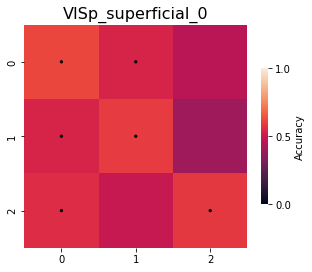

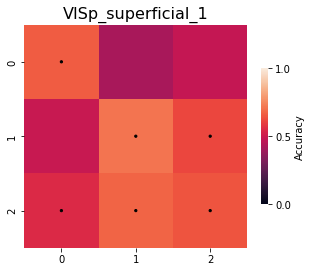

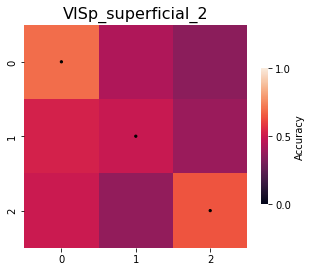

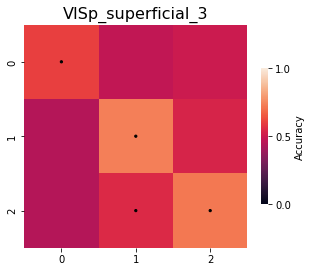

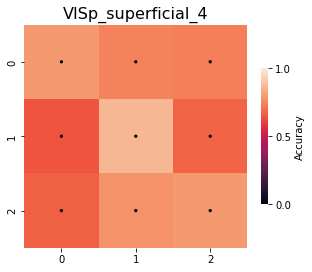

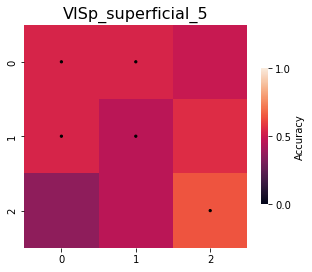

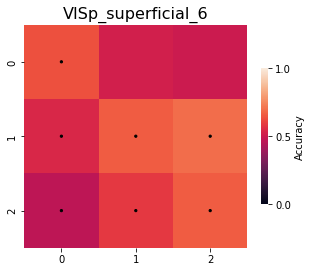

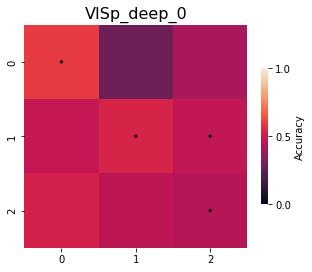

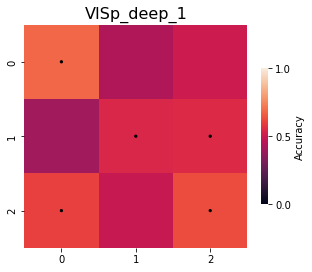

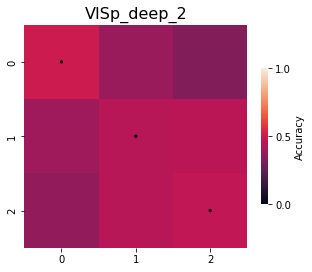

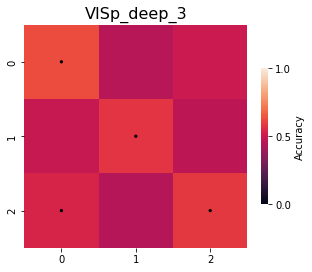

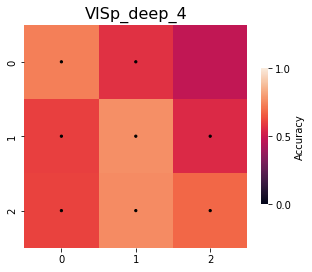

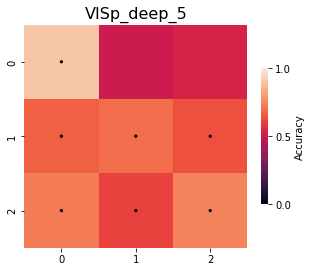

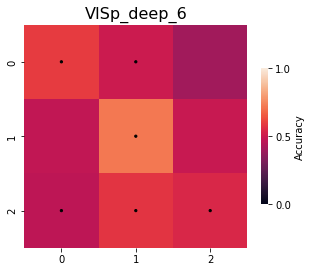

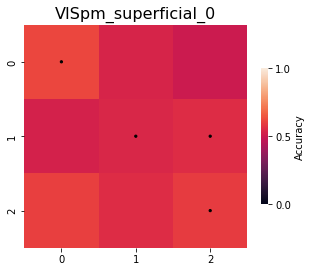

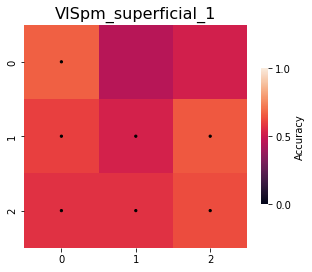

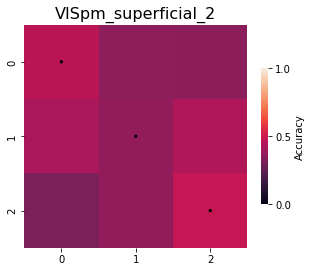

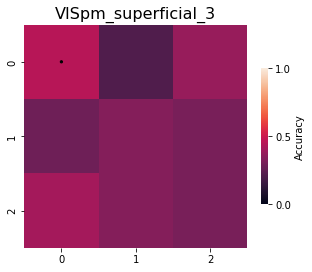

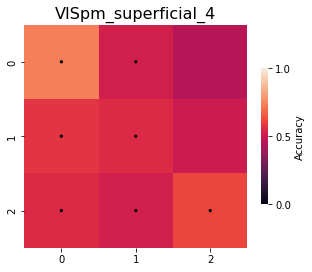

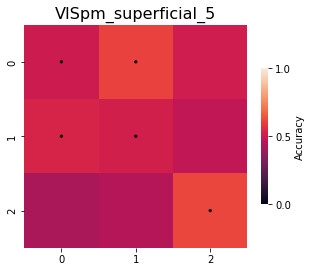

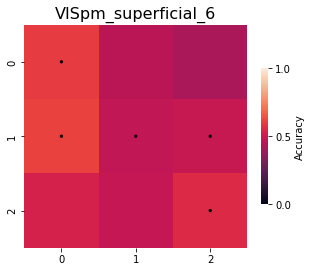

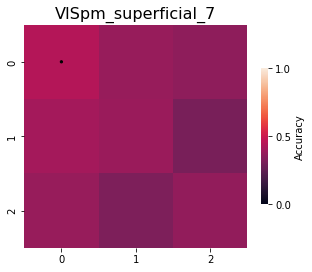

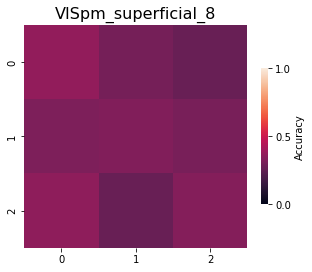

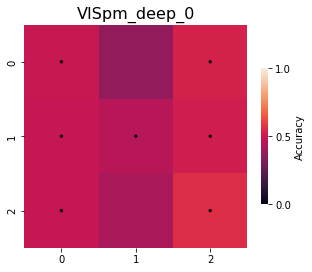

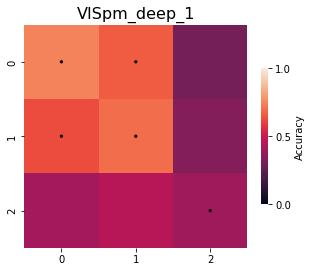

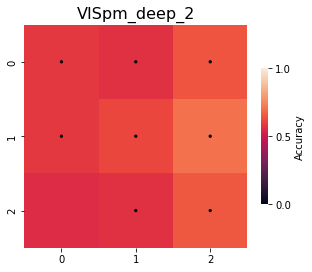

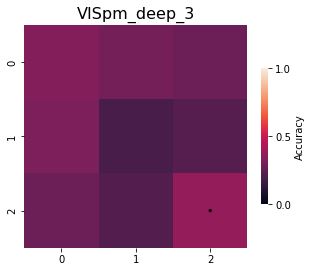

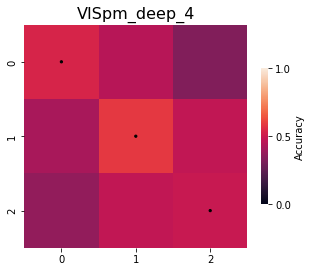

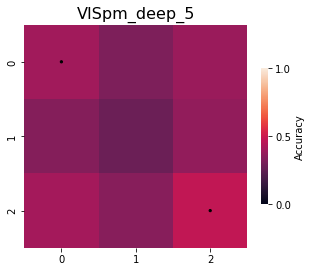

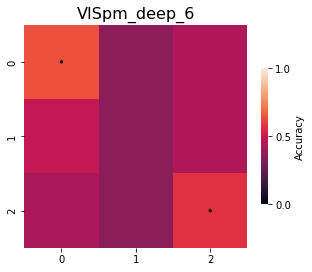

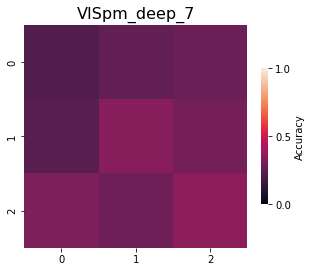

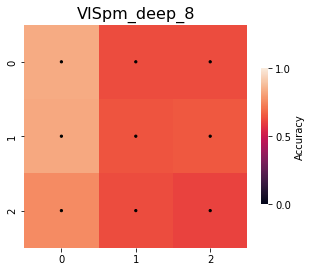

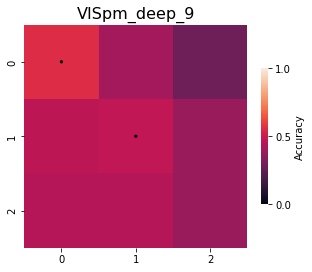

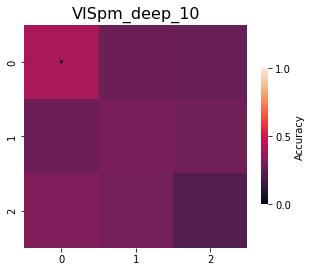

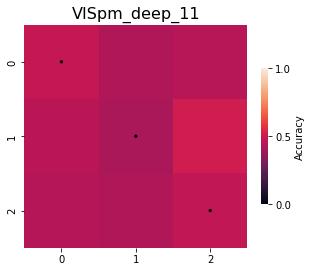

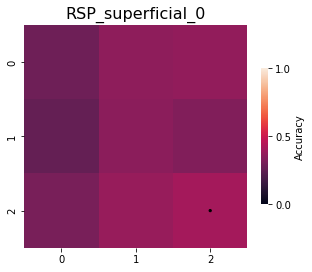

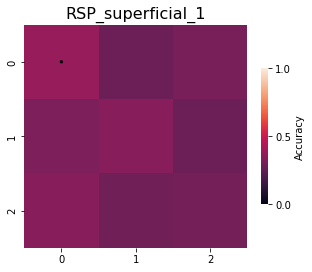

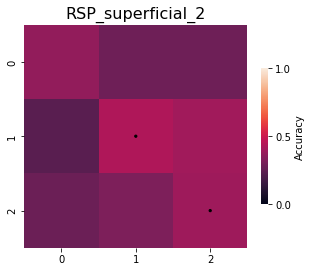

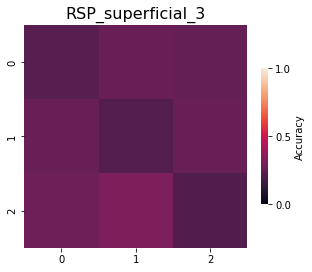

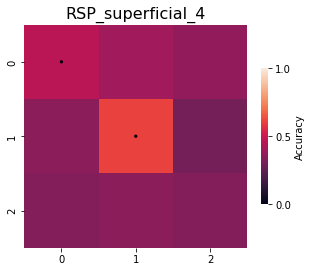

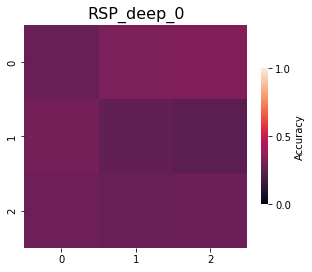

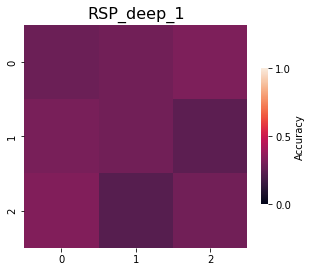

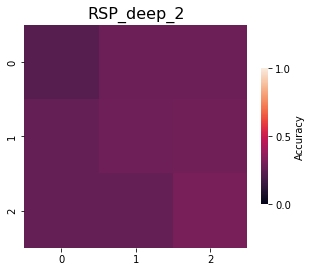

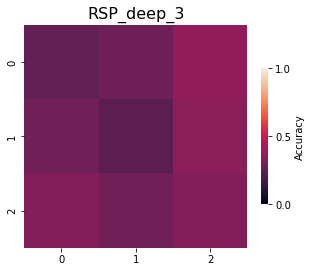

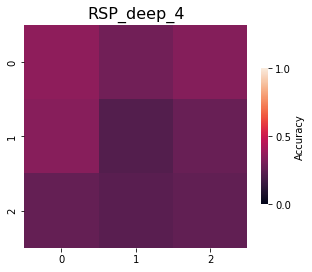

In [153]:
pdfdoc = PdfPages('./plots/paper/CrossSeqGP_permouse.mat')
for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        
        fpath = os.path.join(SaveDir,'CrossSequenceGP_PerMouse_drift_{}_{}_{}.mat'.format(locstr,method,classifier))
        with h5py.File(fpath,'r') as h5file:
            confusion_mat_list = list(h5file['confusion_mat_list'])
            confusion_shf_list = list(h5file['confusion_shf_list'])
            confusion_z_list = list(h5file['confusion_z_list'])
            
        
        for ii, (cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,clims=[0,1],annot=False,cbar=True,title=f'{locstr}_{ii}', pdfdoc=pdfdoc)
pdfdoc.close()

## Temporal Binding

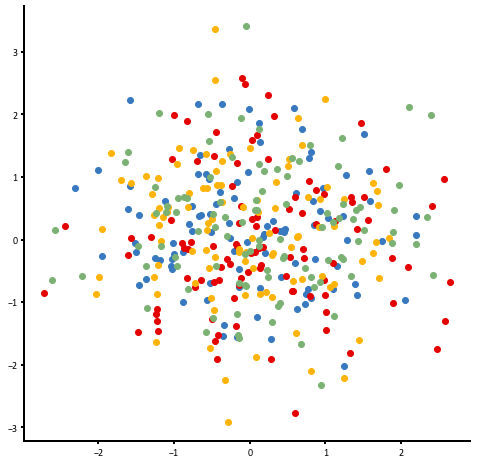

In [83]:
## Create synthetic data to test method
mean = np.zeros((10))+0.1
cov = np.eye(10)  # diagonal covariance


nD = 2; nClasses = 4
fig = plt.subplots(figsize=(8,8))
for i in range(nClasses):
    mean = np.zeros((nD)) #+0.25*i
    cova = np.eye((nD)) 
    x, y = np.random.default_rng().multivariate_normal(mean, cova, 100).T
    plt.plot(x, y,'o',color=cc[i])


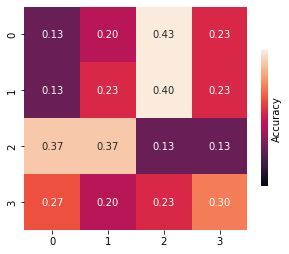

In [9]:
x_list = []; y_list = []
for i in range(nClasses):
    mean = np.zeros((nD))
    cova = np.eye((nD))

    # #Move multivariate guassian in random direction in nD-dimensional space
    # indy = dims[i]
    # mean[indy] = 2

    data = np.random.default_rng().multivariate_normal(mean, cova, nTrials)
    x_list.append(data)
    y_list.append(np.repeat(mainseq_ids[i],nTrials))

X_train = np.concatenate(x_list)
Y_train = np.concatenate(y_list)


confusion_mat, confusion_shf, confusion_z, pvalues = dc.cross_validate(X_train,Y_train,method='kfold')

dc.plot_decoding_accuracy(confusion_mat,confusion_z)

In [26]:
nD = 75; nClasses = 4; nTrials = 50
x_list = []; y_list = []


tmp = np.random.choice(np.arange(nD),4*nClasses,replace=False)
dims = [tmp[i*4:(i+1)*4] for i in range(nClasses)]
perf_list = []
for pert in tqdm(range(10)):
    for i in range(nClasses):
        mean = np.zeros((nD))
        cova = np.eye((nD))

        #Move multivariate guassian in random direction in nD-dimensional space
        indy = dims[i]
        mean[indy] = .25*pert

        data = np.random.default_rng().multivariate_normal(mean, cova, nTrials)
        x_list.append(data)
        y_list.append(np.repeat(mainseq_ids[i],nTrials))

    X = np.concatenate(x_list)
    Y = np.concatenate(y_list)


    confusion_mat, confusion_shf, confusion_z, pvalues = dc.cross_validate(X,Y,method='kfold')
    perf_list.append(np.mean(np.diag(confusion_mat)))
    

plt.plot(.25*np.arange(10),perf_list)

In [281]:
from sklearn import svm
from sklearn.metrics import confusion_matrix
def sub_fn(X_train,Y_train,X_test,Y_test):
    #Construct classifier
    clf = svm.LinearSVC(max_iter=1E6) #penalty='l1',dual=False,

    #Fit model to the training data
    clf.fit(X_train, Y_train)

    Y_hat = clf.predict(X_test)
    hits = np.sum(Y_test == Y_hat)

    return hits

nSessions = 50
encoding_type = 'ramp' #'ramp'
binding_rate_LIST = []


for ijk in tqdm(range(nSessions)):

    tmp = np.random.choice(np.arange(nD),4*nClasses,replace=False)
    dims = [tmp[i*4:(i+1)*4] for i in range(nClasses)]

    x_list = []; y_list = []
    for i in range(nClasses):
        mean = np.zeros((nD))
        cova = np.eye((nD))

        data = np.random.default_rng().multivariate_normal(mean, cova, 30)
        x_list.append(data)
        y_list.append(np.repeat(mainseq_ids[i],30))

    X0 = np.concatenate(x_list)
    Y0 = np.concatenate(y_list)

    tmp = np.random.choice(np.arange(nD),4*nClasses,replace=False)
    dims = [tmp[i*4:(i+1)*4] for i in range(nClasses)]
    perf_list = []; x_list = []; y_list = []
    for pert in range(10):
        for i in range(nClasses):
            mean = np.zeros((nD))
            cova = np.eye((nD))

            if encoding_type == 'ramp':
                #Move multivariate guassian in random direction in nD-dimensional space
                indy = dims[i]
                mean[indy] = .2*pert
            else:
                indy = dims[i]
                mean[indy] = 2

            data = np.random.default_rng().multivariate_normal(mean, cova, 5)
            x_list.append(data)
            y_list.append(np.repeat(mainseq_ids[i],5))

    X1 = np.concatenate(x_list)
    Y1 = np.concatenate(y_list)
    

    X = np.concatenate((X0,X1))
    Y = np.concatenate((Y0,Y1))
    # pdb.set_trace()
    binding_rate = []; processes = []; xlist = []
    with Pool(processes=60) as p:

        for iS in range(61):
            # print(trial_slice)
            train_slice = np.concatenate([np.where(Y == iImg)[0][slice(iS,(iS+10))] for iImg in mainseq_ids])
            test_slice = np.concatenate([np.where(Y == iImg)[0][slice(iS+10,(iS+20))] for iImg in mainseq_ids])
            # test_slice = np.array([np.where(Y == iImg)[0][iS+10] for iImg in mainseq_ids])
            
            X_train = X[train_slice]; Y_train = Y[train_slice]
            X_test = X[test_slice]; Y_test = Y[test_slice]
            # print(iTrial, np.intersect1d(indices_train, indices_test))
            processes.append(p.apply_async(sub_fn,args=(X_train,Y_train,X_test,Y_test,)))
        binding_rate = [];
        for out in processes: 
            binding_rate.append(out.get())
    binding_rate_LIST.append(binding_rate)

        
        

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


In [228]:
stepfn_1_moving = np.mean(binding_rate_LIST,axis=0)/4


In [230]:
stepfn_10_moving = np.mean(binding_rate_LIST,axis=0)/40


In [213]:
rampfn_10_moving = np.mean(binding_rate_LIST,axis=0)/40


In [234]:
rampfn_1_moving = np.mean(binding_rate_LIST,axis=0)/4


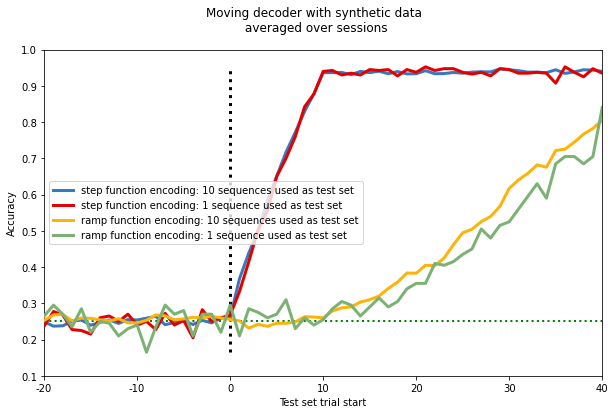

In [244]:
fig, ax = plt.subplots(figsize=(10,6))
plt.suptitle('Moving decoder with synthetic data\n averaged over sessions')

ax.plot(stepfn_10_moving,lw=3,color=cc[0],alpha=1,zorder=3,label='step function encoding: 10 sequences used as test set')
ax.plot(stepfn_1_moving,lw=3,color=cc[1],alpha=1,zorder=3,label='step function encoding: 1 sequence used as test set')
ax.plot(rampfn_10_moving,lw=3,color=cc[2],alpha=1,zorder=3,label='ramp function encoding: 10 sequences used as test set')
ax.plot(rampfn_1_moving,lw=3,color=cc[3],alpha=1,zorder=3,label='ramp function encoding: 1 sequence used as test set')
ax.legend()
ax.autoscale(tight=True)
ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
# ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
ax.vlines(20,*ax.get_ylim(),ls=':',color='k',lw=3)
# ax.set_title('Synthetic data: linearly separable via step-fn change\n moving decoder with 10 main-seq set used as a test set')
ax.set_ylim([0.1,1])
ax.set_xticks(np.arange(0,61,10))
ax.set_xticklabels([-20,-10,0,10,20,30,40])

ax.set_xlabel('Test set trial start')
ax.set_ylabel('Accuracy')
plt.savefig('./plots/temporal_binding/sessionavg_syntheticdata_movingdecoder.png')

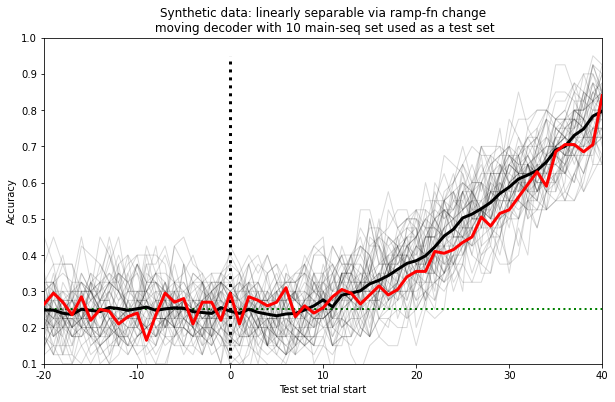

In [282]:
fig, ax = plt.subplots(figsize=(10,6))

# tmp_list = []
for br in binding_rate_LIST:
    ax.plot(np.array(br)/40,lw=1,color='k',alpha=0.15)
ax.plot(np.mean(binding_rate_LIST,axis=0)/40,lw=3,color='k',alpha=1)
if encoding_type == 'ramp':
    ax.plot(rampfn_1_moving,lw=3,color='r',alpha=1,zorder=3)
else:
    ax.plot(stepfn_1_moving,lw=3,color='r',alpha=1,zorder=3)

ax.autoscale(tight=True)
ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
# ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
ax.vlines(20,*ax.get_ylim(),ls=':',color='k',lw=3)
ax.set_title(f'Synthetic data: linearly separable via {encoding_type}-fn change\n moving decoder with 10 main-seq set used as a test set')
ax.set_ylim([0.1,1])
ax.set_xticks(np.arange(0,61,10))
ax.set_xticklabels([-20,-10,0,10,20,30,40])

ax.set_xlabel('Test set trial start')
ax.set_ylabel('Accuracy')

plt.savefig(f'./plots/temporal_binding/synthetic_data_{encoding_type}fn-change_10set-test_movingdecoder.png')

In [ ]:
print('stop')

In [21]:
#Use training set far off in the future 
nD = 75; nClasses = 4; nTrials = 30
from sklearn import svm
from sklearn.metrics import confusion_matrix
def sub_fn(X_train,Y_train,X_test,Y_test):
    #Construct classifier
    clf = svm.LinearSVC(max_iter=1E6) #penalty='l1',dual=False,

    #Fit model to the training data
    clf.fit(X_train, Y_train)

    Y_hat = clf.predict(X_test)
    hits = np.sum(Y_test == Y_hat)

    return hits

encoding_type = 'ramp'
binding_rate_list = []
for ijk in tqdm(range(50)):

    tmp = np.random.choice(np.arange(nD),4*nClasses,replace=False)
    dims = [tmp[i*4:(i+1)*4] for i in range(nClasses)]
    x_list = []; y_list = []
    for i in range(nClasses):
        mean = np.zeros((nD))
        cova = np.eye((nD))

        #Move multivariate guassian in random direction in nD-dimensional space
        indy = dims[i]
        mean[indy] = 2.5

        data = np.random.default_rng().multivariate_normal(mean, cova, 50)
        x_list.append(data)
        y_list.append(np.repeat(mainseq_ids[i],50))

    X_train = np.concatenate(x_list)
    Y_train = np.concatenate(y_list)
    
    #"Randomized control session"
    x_list = []; y_list = []
    for i in range(nClasses):
        mean = np.zeros((nD))
        cova = np.eye((nD))

        data = np.random.default_rng().multivariate_normal(mean, cova, 30)
        x_list.append(data)
        y_list.append(np.repeat(mainseq_ids[i],30))

    X0 = np.concatenate(x_list)
    Y0 = np.concatenate(y_list)

    x_list = []; y_list = []
    for pert in range(10):
        for i in range(nClasses):
            mean = np.zeros((nD))
            cova = np.eye((nD))

            if encoding_type == 'ramp':
                #Move multivariate guassian in random direction in nD-dimensional space
                indy = dims[i]
                mean[indy] = .2*pert
            else:
                indy = dims[i]
                mean[indy] = 2

            data = np.random.default_rng().multivariate_normal(mean, cova, 5)
            x_list.append(data)
            y_list.append(np.repeat(mainseq_ids[i],5))

    X1 = np.concatenate(x_list)
    Y1 = np.concatenate(y_list)
    
    X_test = np.concatenate((X0,X1))
    Y_test = np.concatenate((Y0,Y1))


    # pdb.set_trace()
    binding_rate = []; processes = []; xlist = []
    with Pool(processes=60) as p:
        nTrials = X_test.shape[0]
        for iS in range(71):
            trial_slice = slice(iS,(iS+10))

            trial_slice = np.concatenate([np.where(Y_test == iImg)[0][trial_slice] for iImg in mainseq_ids])
            
            # trial_slice = np.array([np.where(Y_test == iImg)[0][iS] for iImg in mainseq_ids])
            processes.append(p.apply_async(sub_fn,args=(X_train,Y_train,X_test[trial_slice],Y_test[trial_slice],)))

        for out in processes: 
            binding_rate.append(out.get())
    binding_rate_list.append(binding_rate)

        
        

100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


In [8]:
rampfn_1 = np.mean(binding_rate_list,axis=0)/4

In [10]:
rampfn_10 = np.mean(binding_rate_list,axis=0)/40

In [13]:
stepfn_1 = np.mean(binding_rate_list,axis=0)/4

In [15]:
stepfn_10 = np.mean(binding_rate_list,axis=0)/40

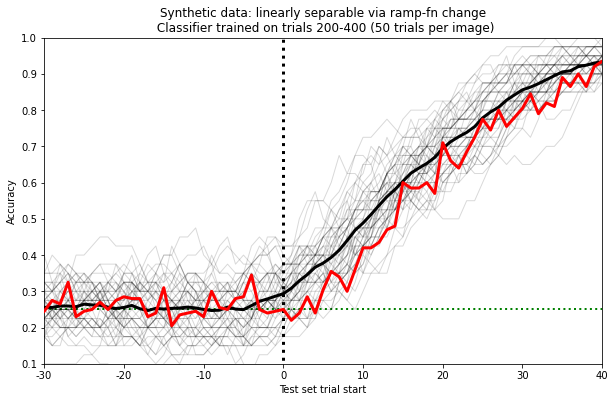

In [22]:
fig, ax = plt.subplots(figsize=(10,6))

# tmp_list = []
for br in binding_rate_list:
    ax.plot(np.array(br)/40,lw=1,color='k',alpha=0.15)
ax.plot(np.mean(binding_rate_list,axis=0)/40,lw=3,color='k',alpha=1)
if encoding_type == 'ramp':
    ax.plot(rampfn_1,lw=3,color='r',alpha=1,zorder=3)
else:
    ax.plot(stepfn_1,lw=3,color='r',alpha=1,zorder=3)

ax.autoscale(tight=True)
ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
# ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=3)
ax.set_title(f'Synthetic data: linearly separable via {encoding_type}-fn change\n Classifier trained on trials 200-400 (50 trials per image)')
ax.set_ylim([0.1,1])
ax.set_xticks(np.arange(0,71,10))
ax.set_xticklabels([-30,-20,-10,0,10,20,30,40])

ax.set_xlabel('Test set trial start')
ax.set_ylabel('Accuracy')

plt.savefig(f'./plots/temporal_binding/synthetic_data_{encoding_type}fn-change_trainingset200.png')

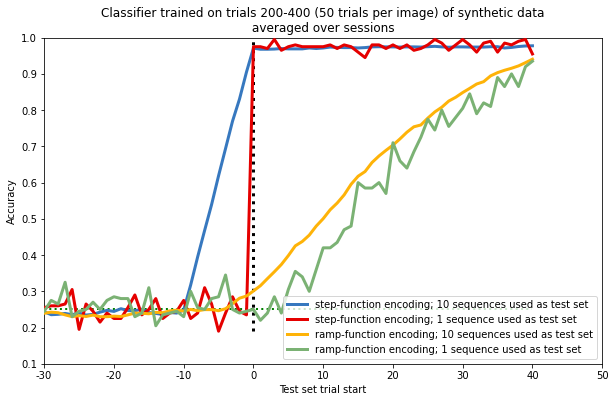

In [20]:
fig, ax = plt.subplots(figsize=(10,6))


ax.plot(stepfn_10,lw=3,color=cc[0],alpha=1,zorder=3,label='step-function encoding; 10 sequences used as test set')
ax.plot(stepfn_1,lw=3,color=cc[1],alpha=1,zorder=3,label='step-function encoding; 1 sequence used as test set')
ax.plot(rampfn_10,lw=3,color=cc[2],alpha=1,zorder=3,label='ramp-function encoding; 10 sequences used as test set')
ax.plot(rampfn_1,lw=3,color=cc[3],alpha=1,zorder=3,label='ramp-function encoding; 1 sequence used as test set')
ax.legend()
ax.autoscale(tight=True)
ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=3)
ax.set_title('Classifier trained on trials 200-400 (50 trials per image) of synthetic data\n averaged over sessions ')
ax.set_ylim([0.1,1])
ax.set_xticks(np.arange(0,81,10))
ax.set_xticklabels([-30,-20,-10,0,10,20,30,40,50])

ax.set_xlabel('Test set trial start')
ax.set_ylabel('Accuracy')
plt.savefig('./plots/temporal_binding/sessionavg_syntheticdata_trainingset200.png')

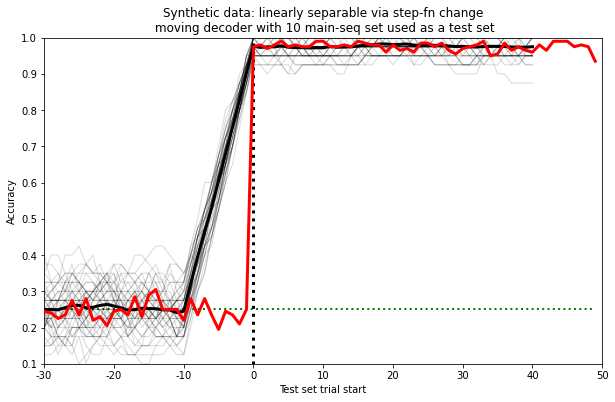

In [191]:
fig, ax = plt.subplots(figsize=(10,6))

# tmp_list = []
for br in binding_rate_list:
    ax.plot(np.array(br)/40,lw=1,color='k',alpha=0.15)
ax.plot(np.mean(binding_rate_list,axis=0)/40,lw=3,color='k',alpha=1)
ax.plot(stepfn_1,lw=3,color='r',alpha=1,zorder=3)

ax.autoscale(tight=True)
ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
# ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=3)
ax.set_title('Synthetic data: linearly separable via step-fn change\n moving decoder with 10 main-seq set used as a test set')
ax.set_ylim([0.1,1])
ax.set_xticks(np.arange(0,81,10))
ax.set_xticklabels([-30,-20,-10,0,10,20,30,40,50])

ax.set_xlabel('Test set trial start')
ax.set_ylabel('Accuracy')

plt.savefig('./plots/temporal_binding/synthetic_data_stepfn-change_10set-test.png')

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':         12,
                     'axes.linewidth':    2,
                     'xtick.major.size':  3,
                     'xtick.major.width': 2,
                     'ytick.major.size':  3,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':   "calibri",
                     'font.family':       "sans-serif",
                     'pdf.fonttype':      42,
                     'xtick.labelsize': 10,
                     'ytick.labelsize': 10,
                     'axes.labelweight':'bold'
                    })

import warnings
warnings.filterwarnings("ignore")

In [28]:
def sub_fn(X_train,Y_train,X_test,Y_test):
    #Construct classifier
    clf = svm.LinearSVC(max_iter=1E6) #penalty='l1',dual=False,

    #Fit model to the training data
    clf.fit(X_train, Y_train)

    Y_hat = clf.predict(X_test)
    hits = np.sum(Y_test == Y_hat)

    return hits
                
classifier = 'SVM'
SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/pseudopopulation'
PlotDir = os.path.join(SaveDir,'plots')
    
from sklearn import svm
from sklearn.metrics import confusion_matrix

temporal_binding = {}
# temporal_binding_1seq = {}
block_str = 'oddball'
for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        print(locstr)
        binding_rate_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            # pdb.set_trace()
            #Get trials from randomized_ctrl pre
            X0, Y0, _ = dc.match_trials(pop_responses[area]['randomized_control_pre'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            
            #Get trials from sequence
            X1, Y1, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(0,200))
            
            X = np.concatenate((X0,X1))
            Y = np.concatenate((Y0,Y1))
            binding_rate = []; processes = []
            with Pool(processes=61) as p:
                for iS in range(61):
                    # print(trial_slice)
                    train_slice = np.concatenate([np.where(Y == iImg)[0][slice(iS,(iS+10))] for iImg in mainseq_ids])
                    test_slice = np.concatenate([np.where(Y == iImg)[0][slice(iS+10,(iS+20))] for iImg in mainseq_ids])
                    # test_slice = np.array([np.where(Y == iImg)[0][iS+10] for iImg in mainseq_ids])

                    X_train = X[train_slice]; Y_train = Y[train_slice]
                    X_test = X[test_slice]; Y_test = Y[test_slice]
                    # print(iTrial, np.intersect1d(indices_train, indices_test))
                    processes.append(p.apply_async(sub_fn,args=(X_train,Y_train,X_test,Y_test,)))
                binding_rate = [];
                for out in processes: 
                    binding_rate.append(out.get())
            binding_rate_list.append(binding_rate)    
        temporal_binding[locstr] = binding_rate_list



VISp_superficial
VISp_deep
VISpm_superficial
VISpm_deep
RSP_superficial
RSP_deep


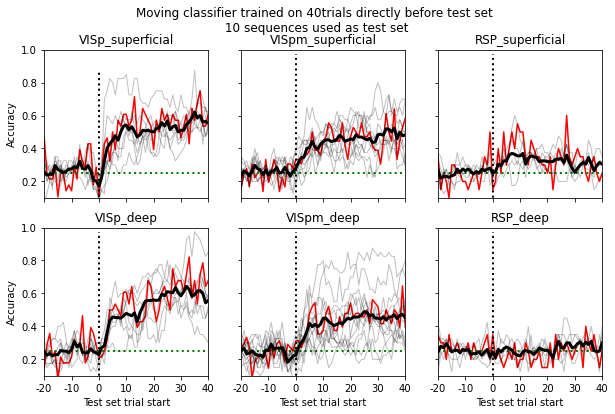

In [30]:
fig, axes = plt.subplots(2,3,figsize=(10,6),sharey=True,sharex=True)
plt.suptitle('Moving classifier trained on 40trials directly before test set\n 10 sequences used as test set')
for ii, area in enumerate(areanames):
        #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        binding_rate_list = temporal_binding[locstr]
        ax = axes[jj,ii]
        
        tmp_list = []
        for br in binding_rate_list:
            ax.plot(np.array(br)/40,lw=1,color='k',alpha=0.25)
        ax.plot(np.mean(binding_rate_list,axis=0)/40,lw=3,color='k',alpha=1)
        binding_rate_list = temporal_binding_1seq[locstr]
        ax.plot(np.mean(binding_rate_list,axis=0)/4,lw=1.5,color='r',alpha=1,zorder=1)
        ax.autoscale(tight=True)
        ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
        # ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
        ax.vlines(20,*ax.get_ylim(),ls=':',color='k',lw=2)
        ax.set_title(locstr)
        ax.set_ylim([0.1,1])
        ax.set_xticks(np.arange(0,61,10))
        ax.set_xticklabels([-20,-10,0,10,20,30,40])
        if jj == 1:
            ax.set_xlabel('Test set trial start')
        if ii == 0:
            ax.set_ylabel('Accuracy')
plt.savefig('./figures/temporal_binding_session-avg_movingdecoder_10seq.pdf',dpi=300,facecolor='white')
plt.savefig('./figures/temporal_binding_session-avg_movingdecoder_10seq.png',dpi=300,facecolor='white')

In [24]:
def sub_fn(X_train,Y_train,X_test,Y_test):
    #Construct classifier
    clf = svm.LinearSVC(max_iter=1E6) #penalty='l1',dual=False,

    #Fit model to the training data
    clf.fit(X_train, Y_train)

    Y_hat = clf.predict(X_test)
    hits = np.sum(Y_test == Y_hat)

    return hits

# temporal_binding2_1seq = {}
temporal_binding2 = {}
block_str = 'oddball'
for area in tqdm(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        binding_rate_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue

            #Get trials where MS images for training set
            X_train, Y_train, _  = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(200,400))
            
            #Get trials from randomized_ctrl pre
            X0, Y0, _ = dc.match_trials(pop_responses[area]['randomized_control_pre'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='randomized_control_pre', trial_type='ABCD')
            
            #Get trials where MS images for training set
            X1, Y1, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slice(0,200))

            X_test = np.concatenate((X0,X1))
            Y_test = np.concatenate((Y0,Y1))

            binding_rate = []; processes = []
            with Pool(processes=60) as p:
                nTrials = X_test.shape[0]
                for iS in range(71):
                    trial_slice = slice(iS,(iS+10))
                    trial_slice = np.concatenate([np.where(Y_test == iImg)[0][trial_slice] for iImg in mainseq_ids])
                    
                    # trial_slice = np.array([np.where(Y_test == iImg)[0][iS] for iImg in mainseq_ids])
                    processes.append(p.apply_async(sub_fn,args=(X_train,Y_train,X_test[trial_slice],Y_test[trial_slice],)))
                    
                for out in processes: 
                    binding_rate.append(out.get())
            binding_rate_list.append(binding_rate)
                    
        temporal_binding2[locstr] = binding_rate_list



100%|██████████| 3/3 [07:41<00:00, 153.88s/it]


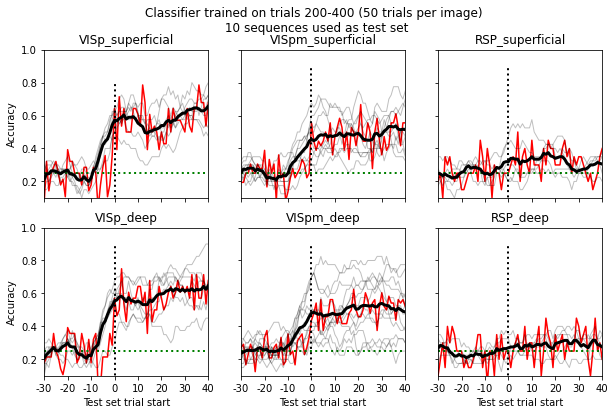

In [40]:
fig, axes = plt.subplots(2,3,figsize=(10,6),sharey=True,sharex=True)
plt.suptitle('Classifier trained on trials 200-400 (50 trials per image)\n 10 sequences used as test set')
for ii, area in enumerate(areanames):
        #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        binding_rate_list = temporal_binding2[locstr]
        ax = axes[jj,ii]
        
        # tmp_list = []
        for br in binding_rate_list:
            ax.plot(np.array(br)/40,lw=1,color='k',alpha=0.25)
        ax.plot(np.mean(binding_rate_list,axis=0)/40,lw=3,color='k',alpha=1)
        binding_rate_list = temporal_binding2_1seq[locstr]
        ax.plot(np.mean(binding_rate_list,axis=0)/4,lw=1.5,color='r',alpha=1,zorder=1)
        ax.autoscale(tight=True)
        ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
        # ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
        ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
        ax.set_title(locstr)
        ax.set_ylim([0.1,1])
        ax.set_xticks(np.arange(0,71,10))
        ax.set_xticklabels([-30,-20,-10,0,10,20,30,40])
        
        if jj == 1:
            ax.set_xlabel('Test set trial start')
        if ii == 0:
            ax.set_ylabel('Accuracy')
plt.savefig('./figures/temporal_binding_trainingset200.pdf',dpi=300,facecolor='white')
plt.savefig('./figures/temporal_binding_trainingset200.png',dpi=300,facecolor='white')

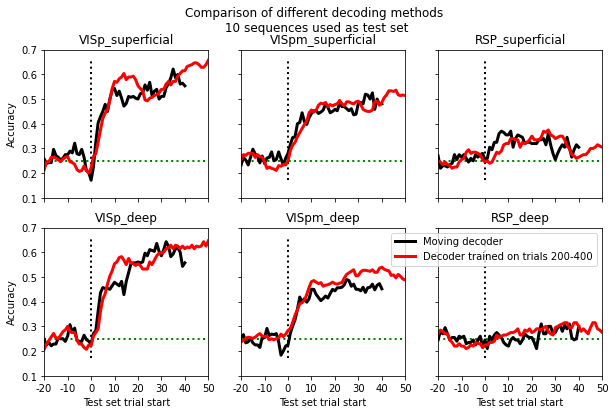

In [36]:
fig, axes = plt.subplots(2,3,figsize=(10,6),sharey=True,sharex=True)
plt.suptitle('Comparison of different decoding methods\n 10 sequences used as test set')
for ii, area in enumerate(areanames):
        #Loop over depth as well
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        binding_rate_list = temporal_binding[locstr]
        ax = axes[jj,ii]
        ax.plot(np.mean(binding_rate_list,axis=0)/40,lw=3,color='k',label='Moving decoder')
        
        binding_rate_list = temporal_binding2[locstr]
        ax.plot(np.mean(binding_rate_list,axis=0)/40,lw=3,color='r',label='Decoder trained on trials 200-400')
        if locstr == 'RSP_deep':
            ax.legend()
        ax.autoscale(tight=True)
        ax.hlines(0.25,*ax.get_xlim(),ls=':',color='g',lw=2)
        # ax.vlines(30,*ax.get_ylim(),ls=':',color='k',lw=2)
        ax.vlines(20,*ax.get_ylim(),ls=':',color='k',lw=2)
        ax.set_title(locstr)
        ax.set_ylim([0.1,0.7])
        ax.set_xticks(np.arange(0,71,10))
        ax.set_xticklabels([-20,-10,0,10,20,30,40,50])
        
        if jj == 1:
            ax.set_xlabel('Test set trial start')
        if ii == 0:
            ax.set_ylabel('Accuracy')
plt.savefig('./figures/temporal_binding_methodscomparison.pdf',dpi=300,facecolor='white')
plt.savefig('./figures/temporal_binding_methodscomparison.png',dpi=300,facecolor='white')

## PCA of oddball PSTHs

In [97]:
PSTH_X_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}

Save = True
SaveDir  = './results/PCA'
if Save:
    fpath = os.path.join(SaveDir,'Ximg_PSTH_singlesession.mat')
    h5file = h5py.File(fpath,'w')

for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        PCA_list = []; eID_list = []

        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            eID_list.append(eID)
            ##===== Collect appropriate trials from each context and calculate PSTH per main sequence image =====##
            PSTH_list = []
            for block_str in blocknames:
                #Get trials where MS images are presented in the randomized control pre context
                X, Y, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
                for iSeq, iID in enumerate(oddball_ids):
                    indy = np.where(Y == iID)[0]
                    PSTH_list.append(np.mean(X[indy],axis=0))

            PSTH = np.stack(PSTH_list)
            PSTH_X_dict[locstr][eID] = PSTH


            pca = PCA(n_components=2)
            X = st.zscore(PSTH,axis=0)
            X_transform = pca.fit_transform(X)
            PCA_list.append(X_transform)

            #Save
            if Save:
                h5file.create_dataset('{}_{}_PSTH'.format(int(eID),locstr),data=PSTH)
        if Save:
            h5file.create_dataset('{}_PCs'.format(locstr),data=PCA_list)
            h5file.create_dataset('{}_experiment_ids'.format(locstr),data=eID_list)

        
if Save:
    h5file.close()
            
                
        

In [104]:
def dim_reduction_plot(X, method='pca',nLatents=2,pdfdoc=None,title_str=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
#         print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    marker_list = ['X\u2080','X\u2081','X\u2082','X\u2083','X\u2084','X\u2085','X\u2086','X\u2087','X\u2088','X\u2089']

    cm = plt.get_cmap('Reds')
    ##plot 2D
    if nLatents == 2:
        fig, ax = plt.subplots(figsize=(3,3))
                
        for ii, context in enumerate(blocknames):
            plot_indices = overall_index + np.arange(0,4)
            # ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(oddball_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[ii],marker=f'${marker_list[jj]}$',s=150,zorder=3)
                overall_index += 1
       
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
    
        ms=150
        
        for ii, context in enumerate(blocknames):
            plot_indices = overall_index + np.arange(0,4)
            # ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(oddball_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[ii],marker=f'${marker_list[jj]}$',s=ms,zorder=3)
                seq_index += 1; overall_index += 1
                
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

    if title_str is not None:
        ax.set_title(title_str,fontsize=16)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
        plt.close(fig)
    else:
        return fig

In [105]:
pdfdoc = PdfPages('./plots/paper2/pca2D_mainseq-psth_persession.pdf')
from sklearn.preprocessing import StandardScaler
for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        #Get experimental IDs for area of interest
        experiment_ids = list(PSTH_mainseq_dict[locstr].keys())
        for eID in experiment_ids:
            X = PSTH_X_dict[locstr][eID]
            X_standardized = StandardScaler().fit_transform(X)
            title_str = f'{locstr}: {eID}'
            dim_reduction_plot(X, method='pca',nLatents=2,pdfdoc=pdfdoc,title_str=title_str)
pdfdoc.close()


## PCA of main-sequence PSTHs

In [96]:
PSTH_mainseq_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}

Save = True
SaveDir  = './results/PCA'
if Save:
    fpath = os.path.join(SaveDir,'mainsequence_PSTH_singlesession.mat')
    h5file = h5py.File(fpath,'w')

for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        PCA_list = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            
            eID_list.append(eID)
            ##===== Collect appropriate trials from each context and calculate PSTH per main sequence image =====##
            PSTH_list = []
            for block_str in blocknames:
                #Get trials where MS images are presented in the randomized control pre context
                X, Y, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='ABCD')
                for iSeq, iID in enumerate(mainseq_ids):
                    indy = np.where(Y == iID)[0]
                    PSTH_list.append(np.mean(X[indy],axis=0))

            PSTH = np.stack(PSTH_list)
            PSTH_mainseq_dict[locstr][eID] = PSTH


            pca = PCA(n_components=2)
            X = st.zscore(PSTH,axis=0)
            X_transform = pca.fit_transform(X)
            PCA_list.append(X_transform)

            #Save
            if Save:
                h5file.create_dataset('{}_{}_PSTH'.format(int(eID),locstr),data=PSTH)
        if Save:
            h5file.create_dataset('{}_PCs'.format(locstr),data=PCA_list)
            h5file.create_dataset('{}_experiment_ids'.format(locstr),data=eID_list)

        
if Save:
    h5file.close()
                
        

In [98]:
def dim_reduction_plot(X, method='pca',nLatents=2,pdfdoc=None,title_str=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
#         print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    marker_list = ['$A$','$B$','$C$','$D$']
    cm = plt.get_cmap('Reds')
    ##plot 2D
    if nLatents == 2:
        fig, ax = plt.subplots(figsize=(3,3))
            
        for ii, context in enumerate(blocknames):
            plot_indices = overall_index + np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[ii],marker=marker_list[jj],s=150,zorder=3)
                overall_index += 1
       
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ms=150
        
        for ii, context in enumerate(blocknames):
            plot_indices = overall_index + np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35,lw=3)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[ii],marker=marker_list[jj],s=ms,zorder=3)
                seq_index += 1; overall_index += 1
                
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

    if title_str is not None:
        ax.set_title(title_str,fontsize=16)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
        plt.close(fig)
    else:
        return fig

In [101]:
pdfdoc = PdfPages('./plots/paper2/pca2D_mainseq-psth_persession.pdf')
from sklearn.preprocessing import StandardScaler
for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        #Get experimental IDs for area of interest
        experiment_ids = list(PSTH_mainseq_dict[locstr].keys())
        for eID in experiment_ids:
            X = PSTH_mainseq_dict[locstr][eID]
            X_standardized = StandardScaler().fit_transform(X)
            title_str = f'{locstr}: {eID}'
            dim_reduction_plot(X, method='pca',nLatents=2,pdfdoc=pdfdoc,title_str=title_str)
pdfdoc.close()


## PCA of ABCXABCD PSTHs

In [ ]:
PSTH_ABCX_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}

block_str = 'oddball'
for area in tqdm(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
        
            PSTH_list = []; imgID_list = []

            nEpochs = 3; 
            for iEpoch in range(nEpochs):
                slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
                X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
                #Calculate PSTHs for each image within these "epochs"
                for iSeq, iID in enumerate(mainseq_ids):
                    indy = np.where(Y == iID)[0]
                    PSTH_list.append(np.mean(X[indy],axis=0)); imgID_list.append(iID)


            #Get trials where MS images are presented in the sequence context relative to the oddball
            X1, Y1, Y_sort1 = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCX')
            X2, Y2, Y_sort2 = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='X-ABCD')

            for iSeq, iID in enumerate(oddball_ids):
                indy = np.where(Y1 == iID)[0]
                #Calculate PSTH for ABC before this X presentation
                for i in range(1,4):
                    indy2 = indy - i
                    PSTH_list.append(np.mean(X1[indy2],axis=0)); imgID_list.append(mainseq_ids[i-1])

                #Append PSTH of this oddball
                PSTH_list.append(np.mean(X1[indy],axis=0)); imgID_list.append(iID)

                indy = np.where(Y2 == iID)[0]
                #Calculate PSTH for ABCD after this X presentation
                for i in range(1,5):
                    indy2 = indy + i
                    PSTH_list.append(np.mean(X2[indy2],axis=0));imgID_list.append(mainseq_ids[i-1])


            #Get trials where MS images are presented in the transition control context
            X, Y, _ = dc.match_trials(pop_responses[area]['transition_control'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='ABCD')
            for iSeq, iID in enumerate(mainseq_ids):
                indy = np.where(Y == iID)[0]
                PSTH_list.append(np.mean(X[indy],axis=0)); imgID_list.append(iID)

            #Get trials where MS images are presented in the transition_control context relative to the oddball
            X1, Y1, Y_sort1 = dc.match_trials(pop_responses[area]['transition_control'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='CX')
            X2, Y2, Y_sort2 = dc.match_trials(pop_responses[area]['transition_control'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='XA')

            for iSeq, iID in enumerate(oddball_ids):
                ##===== CX =====##
                indy = np.where(Y1 == iID)[0]

                #Calculate PSTH for C before this X presentation
                PSTH_list.append(np.mean(X1[indy-1],axis=0)); imgID_list.append(mainseq_ids[-2])

                #Append PSTH of this oddball
                PSTH_list.append(np.mean(X1[indy],axis=0)); imgID_list.append(iID)

                ##===== XA =====##
                indy = np.where(Y2 == iID)[0]

                #Calculate PSTH of this oddball
                PSTH_list.append(np.mean(X2[indy],axis=0)); imgID_list.append(iID)

                #Calculate PSTH for the A after this X presentation
                PSTH_list.append(np.mean(X2[indy+1],axis=0)); imgID_list.append(mainseq_ids[0])


            PSTH_ABCX_dict[locstr][eID] = np.stack(PSTH_list)
                
        

In [ ]:
def dim_reduction_plot_ABCX(X, method='pca',nLatents=2,pdfdoc=None,nEpochs=3):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    cm = plt.get_cmap('Greys')
    marker_list = ['$A$','$B$','$C$','$D$']
    ##plot 2D
    if nLatents == 2:
        fig, axes = plt.subplots(1,4,figsize=(24,6),sharex=True,sharey=True)
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        ax = axes[1]
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
                seq_index += 1; overall_index += 1

        #ABCXABCD in sequence context
        for ii, iID in enumerate(oddball_ids):
            
            ax = axes[0]; ax.set_title('ABCX')
            plot_indices = overall_index + np.arange(0,4)
            #Plot lines for ABCX
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=0,alpha=0.35,ls='--')

            #Plot ABC of ABCX sequence
            for jj, iID in enumerate(mainseq_ids[:-1]):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

            #Plot X of ABCX sequence
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax = axes[1]; ax.set_title('XABCD')
            #Plot lines for ABCD
            plot_indices = overall_index +  np.arange(0,4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=0,alpha=0.35,ls='-')

            #Plot ABCD of ABCD sequence
            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
        
        ax = axes[2]
        #ABCD in transition-control context
        #Plot lines for ABCD
        plot_indices = overall_index + np.arange(0,4)
        ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color='k',zorder=0,alpha=0.5,ls='-')

        #Plot ABCD of ABCD sequence
        for jj, iID in enumerate(mainseq_ids):
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color='k',marker=marker_list[jj],s=75,zorder=2)
            overall_index += 1

        #CX and XA transitions
        for ii, iID in enumerate(oddball_ids):
            
            ax = axes[2];ax.set_title('CX')
            ##===== CX =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='--')


            #plot PSTH for C before this X presentation
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$C$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for this oddball
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax = axes[3];ax.set_title('XA')
            ##===== XA =====##
            plot_indices = overall_index + np.arange(0,2)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='-')

            #plot PSTH for this oddball
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for C before this X presentation
            ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$A$',s=75,zorder=2)
            overall_index += 1
    
                
    elif nLatents == 3:
        
        fig = plt.figure(figsize=(24,6))
#         ax = plt.axes(projection='3d')
        ax0 = fig.add_subplot(1, 4, 1, projection='3d'); ax1 = fig.add_subplot(1, 4, 2, projection='3d')
        ax2 = fig.add_subplot(1, 4, 3, projection='3d'); ax3 = fig.add_subplot(1, 4, 4, projection='3d')
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax1.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
                ax1.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
                seq_index += 1; overall_index += 1

        ax0.set_title('ABCX');
        ax1.set_title('XABCD')
        #ABCXABCD in sequence context
        for ii, iID in enumerate(oddball_ids):
            plot_indices = overall_index + np.arange(0,4)
            #Plot lines for ABCX
            ax0.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[1],zorder=0,alpha=0.35,ls='--')

            #Plot ABC of ABCX sequence
            for jj, iID in enumerate(mainseq_ids[:-1]):
                ax0.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

            #Plot X of ABCX sequence
            ax0.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #Plot lines for ABCD
            plot_indices = overall_index +  np.arange(0,4)
            ax1.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[1],zorder=0,alpha=0.35,ls='-')

            #Plot ABCD of ABCD sequence
            for jj, iID in enumerate(mainseq_ids):
                ax1.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[1],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1

        #ABCD in transition-control context
        #Plot lines for ABCD
        plot_indices = overall_index + np.arange(0,4)
        ax2.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color='k',zorder=0,alpha=0.5,ls='-')

        #Plot ABCD of ABCD sequence
        for jj, iID in enumerate(mainseq_ids):
            ax2.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color='k',marker=marker_list[jj],s=75,zorder=2)
            overall_index += 1

        ax2.set_title('CX')
        #CX and XA transitions
        for ii, iID in enumerate(oddball_ids):
            
            ##===== CX =====##
            plot_indices = overall_index + np.arange(0,2)
            ax2.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='--')


            #plot PSTH for C before this X presentation
            ax2.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$C$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for this oddball
            ax2.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            ax3.set_title('XA')
            ##===== XA =====##
            plot_indices = overall_index + np.arange(0,2)
            ax3.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[2],zorder=0,alpha=0.35,ls='-')

            #plot PSTH for this oddball
            ax3.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$X$',s=75,zorder=2)
            overall_index += 1

            #plot PSTH for C before this X presentation
            ax3.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[2],marker='$A$',s=75,zorder=2)
            overall_index += 1
            
        for ax in [ax0,ax1,ax2,ax3]:
            ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

    print(overall_index)
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
    else:
        return fig

In [ ]:
# pdfdoc = PdfPages('./plots/paper/pca3D_mainseq-psth_persession.pdf')
for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        #Get experimental IDs for area of interest
        experiment_ids = list(PSTH_ABCX_dict[locstr].keys())
        for eID in experiment_ids:
            X = PSTH_ABCX_dict[locstr][eID]
            X = st.zscore(X,axis=0)
            pdb.set_trace()
#             dim_reduction_plot_mainseq(X, method='pca',nLatents=3,pdfdoc=pdfdoc)

In [ ]:
fig = dim_reduction_plot_ABCX(X, method='pca',nLatents=2,pdfdoc=None)


## PCA of just sequence block

In [138]:
PSTH_sequence_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}

block_str = 'oddball'
for area in tqdm(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
        
            ##===== Collect appropriate trials from each context and calculate PSTH per main sequence image =====##
            PSTH_list = []
            nEpochs = 3; nNeurons = len(cell_ids_perdepth)
            for iEpoch in range(nEpochs):
#                 slindy = slice(iEpoch*2000+120,iEpoch*2000+240)
                slindy = slice(iEpoch*3000+120,iEpoch*3000+240)
                # slindy = slice(iEpoch*1000+120,iEpoch*1000+240)
                X, Y, _ = dc.match_trials(pop_responses[area]['oddball'][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
                #Calculate PSTHs for each image within these "epochs"
                for iSeq, iID in enumerate(mainseq_ids):
                    indy = np.where(Y == iID)[0]
                    PSTH_list.append(np.mean(X[indy],axis=0))

            PSTH_sequence_dict[locstr][eID] = np.stack(PSTH_list)
                
        

100%|██████████| 3/3 [10:16<00:00, 205.36s/it]


In [141]:
def dim_reduction_plot_sequence(X, method='pca',nLatents=2,pdfdoc=None,nEpochs=3,titlestr=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        # print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    overall_index = 0
    seq_index = 0
    cm = plt.get_cmap('Greys')
    marker_list = ['$A$','$B$','$C$','$D$']
    ##plot 2D
    if nLatents == 2:
        fig, ax = plt.subplots(figsize=(6,6))
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        ax.set_title(titlestr)
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
                ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
                seq_index += 1; overall_index += 1
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        fig, ax = plt.subplots(figsize=(6,6))
        ax = plt.axes(projection='3d')
        plt.suptitle(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        
        #3 epochs of ABCD in sequence context
        for ii in range(nEpochs):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax1.plot(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=3,alpha=0.35)

            for jj, iID in enumerate(mainseq_ids):
                ax1.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(14)),marker=marker_list[jj],s=75,zorder=3)
                seq_index += 1; overall_index += 1
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

    if pdfdoc is not None:
        pdfdoc.savefig(fig)
        plt.close(fig)
    else:
        return fig

In [144]:

from sklearn.preprocessing import StandardScaler

pca_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}
for area in areanames:
    for jj, depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        experiment_ids = list(PSTH_sequence_dict[locstr].keys())
        
        pca_list = []
        for eID in experiment_ids:
            X = PSTH_sequence_dict[locstr][eID]
            X_standardize = StandardScaler().fit_transform(X)

            pca = PCA(n_components=2)
            X_transform = pca.fit_transform(X_standardize)
            pca_list.append(X_transform)
            pca_dict[locstr][eID] = X_transform
        
fpath = os.path.join('./results/PCA','sequence_timedecoding_persession.mat')
with h5py.File(fpath,'w') as h5file:
    for area in areanames:
        for jj, depthstr in enumerate(['superficial','deep']):
            locstr = '{}_{}'.format(area,depthstr)
            experiment_ids = list(PSTH_sequence_dict[locstr].keys())
            h5file.create_dataset(f'experiment_ids_{locstr}',data=experiment_ids)
            
            for eID in experiment_ids:
                h5file.create_dataset(f'pca_{locstr}_{int(eID)}',data=pca_dict[locstr][eID])

In [142]:
pdfdoc = PdfPages('./plots/paper/pca2D_mainseq-psth_oddball-block_persession.pdf')
for area in areanames:
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        #Get experimental IDs for area of interest
        experiment_ids = list(PSTH_sequence_dict[locstr].keys())
        for eID in experiment_ids:
            X = PSTH_sequence_dict[locstr][eID]
            X_standardize = StandardScaler().fit_transform(X)
            dim_reduction_plot_sequence(X_standardize, method='pca',nLatents=2,pdfdoc=pdfdoc,titlestr=eID)
pdfdoc.close()

# pdfdoc = PdfPages('./plots/paper/pca3D_mainseq-psth_persession.pdf')
# for area in areanames:
#     #Loop over depth as well
#     for depthstr in ['superficial','deep']:
#         locstr = '{}_{}'.format(area,depthstr)
#         #Get experimental IDs for area of interest
#         experiment_ids = list(PSTH_mainseq_dict[locstr].keys())
#         for eID in experiment_ids:
#             X = PSTH_mainseq_dict[locstr][eID]
#             X = st.zscore(X,axis=0)
#             dim_reduction_plot_mainseq(X, method='pca',nLatents=3,pdfdoc=pdfdoc)
# pdfdoc.close()

In [ ]:
def dim_reduction_plot(X, method='pca',nLatents=2,pdfdoc=None):
    if method == 'pca':
        pca = PCA(n_components=nLatents)
        X_transform = pca.fit_transform(X)
        print('Variance explained with {}, {} components: {:.2f}'.format(method,nLatents,np.sum(pca.explained_variance_ratio_)))
    elif method == 'mds':
        mds = MDS(n_components=nLatents)
        X_transform = mds.fit_transform(X)
    else:
        print(f'Method {method} not implemented')
        return 0

    ##plot 2D
    if nLatents == 2:
        T = nEpochs*4

        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        iID = mainseq_ids[-1]
        ms_labels = ['A','B','C','D']

        overall_index = 0
        seq_index = 0
        block_index = 0
        marker_list = ['$A$','$B$','$C$','$D$']
        # marker_list = ['o','2','+','d','x','*','^']
        cm = plt.get_cmap('Greys_r')
        for ii in range(nClasses):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=0,alpha=0.35)
            #Calculate PSTHs for each image within these "epochs"
            for jj, iID in enumerate(mainseq_ids):
                if (ii >= 1) & (ii <= 7):
                    ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cm((seq_index+2)/(T+2)),marker=marker_list[jj],s=75,zorder=2)
                    seq_index += 1
                else:
                    ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1], color=cc[block_index],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1
            if (ii == 7):
                block_index += 2

            if (ii == 8):
                block_index += 1
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
                
    elif nLatents == 3:
        
        T = nEpochs*4

        fig = plt.figure(figsize=(6,6))
        ax = plt.axes(projection='3d')
        ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
        iID = mainseq_ids[-1]
        ms_labels = ['A','B','C','D']

        overall_index = 0
        seq_index = 0
        block_index = 0
        marker_list = ['$A$','$B$','$C$','$D$']
        # marker_list = ['o','2','+','d','x','*','^']
        cm = plt.get_cmap('Greys')
        for ii in range(nClasses):
            plot_indices = np.arange(ii*4,(ii+1)*4)
            ax.plot3D(X_transform[plot_indices,0],X_transform[plot_indices,1],X_transform[plot_indices,2], color=cc[8],zorder=0,alpha=0.35)
            #Calculate PSTHs for each image within these "epochs"
            for jj, iID in enumerate(mainseq_ids):
                if (ii >= 1) & (ii <= 7):
                    ax.scatter(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cm((seq_index+2)/(T+2)),marker=marker_list[jj],s=75,zorder=2)
                    seq_index += 1
                else:
                    ax.scatter3D(X_transform[overall_index,0],X_transform[overall_index,1],X_transform[overall_index,2], color=cc[block_index],marker=marker_list[jj],s=75,zorder=2)
                overall_index += 1
            if (ii == 7):
                block_index += 2

            if (ii == 8):
                block_index += 1
        ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
                
    if pdfdoc is not None:
        pdfdoc.savefig(fig)
    else:
        return fig
        
                

In [ ]:
PSTH_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}

block_str = 'oddball'
for area in areanames:
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        process_outputs = []; eID_list = []
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
            cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_perdepth)

            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
            eID_list.append((eID,nNeurons))
            
            nEpochs = 4; nNeurons = len(cell_ids_perdepth)
            PSTHs = np.zeros((nEpochs*len(mainseq_ids),nNeurons))
            counter = 0
            for iEpoch in range(nEpochs):
#                 slindy = slice(iEpoch*500,iEpoch*500+120)
                slindy = slice(iEpoch*2000,iEpoch*2000+120)
                X, Y, _ = dc.match_trials(pop_responses[area][block_str][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCD',trial_indy=slindy)
    #             Y_sort = [f'{int(y)}_{i}' for y in Y]; Y_sort_list.append(Y_sort)
                #Calculate PSTHs for each image within these "epochs"
                for iSeq, iID in enumerate(mainseq_ids):
                    indy = np.where(Y == iID)[0]
                    PSTHs[counter] = np.mean(X[indy],axis=0)
                    counter += 1

#             pdb.set_trace()
            PSTH_dict[locstr][eID] = PSTHs        

In [ ]:
blocknames = ['randomized_control_pre','oddball','transition_control','randomized_control_post']
blocklabels = ['Rand-Ctrl-Pre', 'Oddball', 'Trans-Ctrl', 'Rand-Ctrl-Post']

In [ ]:

%
area = 'VISp'; depthstr = 'superficial'; locstr = '{}_{}'.format(area,depthstr)
experiment_ids = list(PSTH_dict[locstr].keys())
eID = experiment_ids[0]
X = PSTH_dict[locstr][eID] 

pca = PCA(n_components=3)
X_transform = pca.fit_transform(X)

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.set_title(f'PCA of {depthstr.capitalize()} {area}, {eID}',fontsize=16)

ms_labels = ['A','B','C','D']
marker_list = ['$A$','$B$','$C$','$D$']
index = 0
cm = plt.get_cmap('copper')
for ii in range(nEpochs):
    plot_indices = np.arange(ii*4,(ii+1)*4)
    ax.plot3D(X_transform[plot_indices,0],X_transform[plot_indices,1], X_transform[plot_indices,2],color=cc[8],zorder=0,alpha=0.25)
    #Calculate PSTHs for each image within these "epochs"
    for jj, iID in enumerate(mainseq_ids):
        ax.scatter3D(X_transform[index,0],X_transform[index,1], X_transform[index,2],color=cm(index/T),marker=marker_list[jj],s=75,zorder=2)
        index += 1


In [ ]:
x = X_transform[:,0];
y = X_transform[:,1]
z = X_transform[:,2]

In [ ]:


ax = plt.axes(projection='3d')
ax.scatter(x, y, z, cmap='viridis', edgecolor='none');

In [ ]:
all_ids = np.concatenate((mainseq_ids,oddball_ids))
all_ids

In [ ]:
area = 'VISp'
depthstr = 'superficial'



PSTH_dict = {'VISp_superficial': {},'VISp_deep': {},
             'VISpm_superficial': {},'VISpm_deep': {},
             'RSP_superficial': {},'RSP_deep': {}}
block_str = 'oddball'

for area in areanames:
    print(area)
    #Get experimental IDs for area of interest
    experiment_ids = list(pop_responses[area][block_str].keys())
    
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
        
        #Loop over experimental IDs
        for eID in experiment_ids:
            cell_ids = pop_responses[area][block_str][eID].coords['cell_specimen_id'].values
            
            cell_ids_sub = np.intersect1d(cell_ids_perdepth,cell_ids)
            nNeurons = len(cell_ids_sub)
            
            if nNeurons < 20:
                continue
            print(f'{eID} -> {len(cell_ids_sub)} neurons')     

            #Calculate PSTH for main sequence images for each context
            PSTH_list = []

            for context in blocknames:
                if (context == 'oddball') | (context == 'transition_control'):
                    trial_type = 'ABCDX'
                else:
                    trial_type = 'all'
                X, Y, Y_sort = dc.match_trials(pop_responses[area][context][eID].loc[:,cell_ids_sub], stimulus_df, block=context, trial_type=trial_type)
                for imgID in all_ids:
                    indy = np.where(Y_sort == imgID)[0]
                    PSTH_list.append(np.nanmean(X[indy],axis=0))
            
            X = np.stack(PSTH_list)
            PSTH_dict[locstr][eID] =  X


In [ ]:
manifest.loc[manifest.experiment_id == eID].columns

In [ ]:
for area in areanames:
    print(area)
    #Loop over depth as well
    #Get experimental IDs for area of interest
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        #Get experimental IDs for area of interest
        experiment_ids = list(PSTH_dict[locstr].keys())
        print(len(experiment_ids))


In [ ]:
pdfdoc = PdfPages('./plots/paper/pca_psth_persession.pdf')
for area in areanames:
    print(area)
    #Loop over depth as well
    for depthstr in ['superficial','deep']:
        locstr = '{}_{}'.format(area,depthstr)
        #Get experimental IDs for area of interest
        experiment_ids = list(PSTH_dict[locstr].keys())
        for eID in experiment_ids:
        
            X = PSTH_dict[locstr][eID] 
            pca = PCA(n_components=2)
            X_transform = pca.fit_transform(X)

            fig, ax = plt.subplots(figsize=(4,4))
            ax.set_title(f'PCA of {depthstr.capitalize()} {area}',fontsize=16)
            iID = mainseq_ids[-1]
            ms_labels = ['A','B','C','D']

            index = 0

            marker_list = ['$A$','$B$','$C$','$D$']
            for ii, block in enumerate(blocklabels):
                plot_indices = np.arange(ii*14,ii*14 + 4)
                ax.plot(X_transform[plot_indices,0],X_transform[plot_indices,1], color=cc[8],zorder=0,alpha=0.5)
                for jj,iID in enumerate(mainseq_ids):
                    ax.scatter(X_transform[index,0],X_transform[index,1], color=cc[ii],label=block,marker=marker_list[jj],s=200,zorder=2)
                    index += 1
            #     index += 10

                for jj,iID in enumerate(oddball_ids):
                    ax.scatter(X_transform[index,0],X_transform[index,1], color=cc[ii],marker='$X$',s=100,alpha=0.85,zorder=0)
                    index += 1
            # ax.legend(labelcolor='markerfacecolor')
            ax.set_xlabel('PC1',fontsize=14); ax.set_ylabel('PC2',fontsize=14)

            # ax.set_xlim([-0.75,1]); ax.set_ylim([-0.5,0.75])

#             plt.show()
#             pdb.set_trace()
            pdfdoc.savefig(fig)
            plt.close(fig)
pdfdoc.close()




In [ ]:
for ii, block in enumerate(blocklabels):
    plot_indices = np.arange(ii*14,ii*14 + 4)
    print(plot_indices)

In [ ]:
areanames = [ 'VISp', 'VISpm', 'RSP']
mainseq_labels = ['A','B','C','D']

### Try to decode oddball images vs the previous main sequence in the oddball block
ABCD---X; i.e. the ABC trials are as far away from an oddball presentation as possible

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'
pval_thresh = 0.05
ABCDX_ids = np.concatenate((mainseq_ids,[1]))
nClasses = len(ABCDX_ids)

MAX_PROCESSES = 75
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


# fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
                
        process_outputs = []; eID_list = []
        with Pool(MAX_PROCESSES) as p:
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)

                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
                eID_list.append((eID,nNeurons))
                #Get data for this area for each stimulus block
#                     X_randctrl, Y_randctrl, Y_sort = dc.match_trials(randctrl_pop_responses[area][eID][pp].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
                X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='ABCDX')#,trial_indy=slice(740,860))
#                 X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

#                 print(np.unique(Y_sort,return_counts=True))
#                 pdb.set_trace()
#                     confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                process_outputs.append(p.apply_async(dc.cross_validate, args=(X_oddball,Y_oddball,Y_sort,),kwds={'clabels': ABCDX_ids,'classifier':classifier,'method': method,'plot_shuffle': False, 'parallel': False}))

            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []
            for out in process_outputs:
                confusion_mat, confusion_shf, confusion_z = out.get()

#                 #Take diagonal
#                 diag_hits_list.extend(np.diag(confusion_mat))

#                 #For off diagonals, take mean of each rows' off-diagonals
#                 tmp = confusion_mat.copy()
#                 tmp[np.diag_indices(nClasses)] = np.nan
#                 offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'prevMSvsX_decoding_oddball-blocks_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['A','B','C','D','X'])
        plt.suptitle('Oddball vs Previous Main-Sequence Images\n ABCD---X for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_avg-over-eID_{}_{}_{}_{}.png'.format(locstr,fstr,method,classifier)))
        
        indy = np.argmax([np.sum(np.diag(cm)) for cm in confusion_mat_list])
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        pdfdoc = PdfPages(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}_{}_{}_{}.pdf'.format(locstr,fstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=['A','B','C','D','X'])
            plt.suptitle('s{}, {} neurons\n ABCD---X for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()
#         plt.show()
#         pdb.set_trace()
#         #Sparate diagonal and off-diagonal performance
#         diag_hits = np.concatenate([np.diag(cm[i])  for cm in confusion_mat_list for i in range(nClasses)])
#         offdiag_hits = np.concatenate([cm[i][off_diagonal_indy] for cm in confusion_mat_list for i in range(nClasses)])

#         _, pval = st.wilcoxon(offdiag_hits_list,diag_hits_list)
#         ax = axes2[jj,ii]
#         ax.set_title(f'{locstr}')
# #         ax.boxplot([diag_hits,offdiag_hits])
#         ax.boxplot([diag_hits_list,offdiag_hits_list])
#         if pval < pval_thresh:
#             ax.hlines(1,*[1,2],color='k',zorder=0)
#             ax.vlines(2,*[1,.95],color='k',zorder=0) 
#             ax.vlines(1,*[1,.95],color='k',zorder=0)
#             ax.text(1.4,.975,'*',fontdict={'fontweight':'bold','fontsize': 28,'color': 'k'})

#         ax.set_ylim([-0.15,1.15])

#         if jj == 1:
#             ax.set_xticks([1,2])
#             ax.set_xticklabels(['Hits','Off-Diag'])
#         if ii == 0:
#             ax.set_ylabel('Decoding\n Performance')

# fig2.suptitle('Oddball vs Previous Main-Sequence Images, ABCD---X',y=1.05)
# fig2.savefig(os.path.join(PlotDir,'prevMSvsX_decoding_oddball-blocks_{}_{}_{}.png'.format(fstr,method,classifier)))


In [ ]:
np.unique(Y_oddball)

In [ ]:
ABCDX_ids = np.concatenate((mainseq_ids,[1]))
ABCDX_ids

### Try to decode oddball images vs the main sequence immediately following the oddball
XABCD i.e. the ABCD trials are as close to the oddball presentations as possible

In [ ]:
#Let's decode MS images from the oddball context, vs the randomized ctrl context
method='kfold'
pval_thresh = 0.05
ABCDX_ids = np.concatenate(([1],mainseq_ids))
nClasses = len(ABCDX_ids)

MAX_PROCESSES = 75
#Get off diagonal indices
upper_tmp = np.triu_indices(nClasses,k=1)
lower_tmp = np.tril_indices(nClasses,k=-1)
off_diagonal_indy = (np.concatenate((upper_tmp[0],lower_tmp[0])),np.concatenate((upper_tmp[1],lower_tmp[1])))

reduce_dim = False
if reduce_dim:
    classifier = 'LDA'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession/PCA'
    fstr = 'PCA_persession'
    PlotDir = os.path.join(SaveDir,'plots')
else:
    classifier = 'nearest_neighbor'
    SaveDir = '/home/dwyrick/projects/predictive_coding/results/decoding/persession'
    fstr = 'persession'
    PlotDir = os.path.join(SaveDir,'plots')


# fig2, axes2 = plt.subplots(2,3,figsize=(12,8),gridspec_kw={'hspace':0.35},sharey=True,sharex=True)
#Loop over areasconfusion_z_mean
for ii, area in enumerate(areanames):
    #Get experimental IDs for area of interest
    experiment_ids = list(oddball_pop_responses[area].keys())

    #Loop over depth as well
    for jj,depthstr in enumerate(['superficial','deep']):
        locstr = '{}_{}'.format(area,depthstr)
        print(f'{locstr}:\t')
                
        process_outputs = []; eID_list = []
        with Pool(MAX_PROCESSES) as p:
            #Loop over experimental IDs
            for eID in experiment_ids:
                cell_ids = oddball_pop_responses[area][eID].coords['cell_specimen_id'].values
                cell_ids_perdepth = cell_metadata_df[cell_metadata_df['location'] == locstr].index.values
                cell_ids_perdepth = np.intersect1d(cell_ids_perdepth,cell_ids)
                nNeurons = len(cell_ids_perdepth)

                if nNeurons < 20:
                    continue
                print(f'{eID} -> {len(cell_ids_perdepth)} neurons')     
                eID_list.append((eID,nNeurons))
                #Get data for this area for each stimulus block
#                     X_randctrl, Y_randctrl, Y_sort = dc.match_trials(randctrl_pop_responses[area][eID][pp].loc[:,cell_ids_perdepth], stimulus_df, block=block_str, trial_type='X')
                X_oddball, Y_oddball, Y_sort = dc.match_trials(oddball_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='oddball', trial_type='XABCD')#,trial_indy=slice(740,860))
#                 X_transctrl, Y_transctrl, Y_sort = dc.match_trials(transctrl_pop_responses[area][eID].loc[:,cell_ids_perdepth], stimulus_df, block='transition_control', trial_type='X')

#                 print(np.unique(Y_sort,return_counts=True))
#                 pdb.set_trace()
#                     confusion_mat, confusion_shf, confusion_z = dc.cross_validate(X_oddball,Y_oddball,Y_sort,clabels=mainseq_ids,classifier=classifier,method=method,plot_shuffle=False,parallel=False)
                process_outputs.append(p.apply_async(dc.cross_validate, args=(X_oddball,Y_oddball,Y_sort,),kwds={'clabels': ABCDX_ids,'classifier':classifier,'method': method,'plot_shuffle': False, 'parallel': False}))

            confusion_mat_list = [];confusion_shf_list = []; confusion_z_list = []
            diag_hits_list = []; offdiag_hits_list = []
            for out in process_outputs:
                confusion_mat, confusion_shf, confusion_z = out.get()

#                 #Take diagonal
#                 diag_hits_list.extend(np.diag(confusion_mat))

#                 #For off diagonals, take mean of each rows' off-diagonals
#                 tmp = confusion_mat.copy()
#                 tmp[np.diag_indices(nClasses)] = np.nan
#                 offdiag_hits_list.extend([np.nanmean(tmp[i,:]) for i in range(nClasses)]);
                confusion_mat_list.append(confusion_mat); confusion_shf_list.append(confusion_shf); confusion_z_list.append(confusion_z)

        fpath = os.path.join(SaveDir,'nextMSvsX_decoding_oddball-blocks_{}_{}_{}_{}.mat'.format(locstr,fstr,method,classifier))
        with h5py.File(fpath,'w') as h5file:
            h5file.create_dataset('confusion_mat_list',data=confusion_mat_list)
            h5file.create_dataset('confusion_shf_list',data=confusion_shf_list)
            h5file.create_dataset('confusion_z_list',data=confusion_z_list)
            h5file.create_dataset('locstr',data=locstr)
            h5file.create_dataset('classifier',data=classifier)
            h5file.create_dataset('method',data=method)

        #Plot shuffle distributions
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        dc.plot_decoding_accuracy(confusion_mat_mean,confusion_z_mean,class_labels=['X','A','B','C','D'])
        plt.suptitle('Oddball vs Next Main-Sequence Images\n XABCD for {}'.format(locstr),y=0.995)
        plt.savefig(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_avg-over-eID_{}_{}_{}_{}.png'.format(locstr,fstr,method,classifier)))
        
        indy = np.argmax([np.sum(np.diag(cm)) for cm in confusion_mat_list])
        confusion_mat_mean = np.mean(confusion_mat_list,axis=0); confusion_z_mean = np.mean(confusion_z_list,axis=0)
        pdfdoc = PdfPages(os.path.join(PlotDir,'nextMSvsX_decoding_oddball-blocks_{}_{}_{}_{}.pdf'.format(locstr,fstr,method,classifier)))
        for indy,(cm, cmz) in enumerate(zip(confusion_mat_list,confusion_z_list)):
            dc.plot_decoding_accuracy(cm,cmz,class_labels=['X','A','B','C','D'])
            plt.suptitle('s{}, {} neurons\n XABCD for {}'.format(*eID_list[indy],locstr),y=0.995)
            pdfdoc.savefig()
            plt.close()
        pdfdoc.close()

